
# 0.Presentación del notebook
**Equilibrio eléctrico y desigualdades territoriales en Argentina (2012–2019)**

Tesina – Licenciatura en Ciencias de Datos  
Autores: **Mónica Inés Galeano · Raúl Matías Rodríguez**

---

## Propósito

Este notebook implementa el flujo de trabajo computacional del estudio: integración, limpieza y armonización territorial de datos eléctricos y demográficos; construcción del Índice de Equilibrio Eléctrico Regional (IEER); y análisis multivariado para identificar tipologías regionales de equilibrio eléctrico en Argentina durante 2012–2019.

## Alcance y unidad de análisis

**Dimensiones analizadas:** demanda eléctrica, generación eléctrica e indicadores derivados; población agregada por región.

**Unidad territorial:** regiones del Sistema Argentino de Interconexión (SADI), según criterios de agrupación y corrección territorial utilizados en el trabajo.

**Temporalidad:** serie anual 2012–2019 (con procesamiento mensual para agregaciones y métricas intra-anuales).

## Metodología de análisis (CRISP-DM)

El análisis se organiza siguiendo CRISP-DM, adaptada a un estudio descriptivo–analítico. Este notebook desarrolla las fases operativas: comprensión y preparación de datos, modelado (clustering) y evaluación exploratoria de patrones regionales.

## Productos del notebook

Como resultado, el notebook genera:

*  Un dataset final región–año con IEER, componentes y clúster asignado.
*  Tablas y figuras exportables para el informe (heatmap IEER, rankings, perfiles por clúster, etc.)

## Nota de lectura

Las decisiones metodológicas (definiciones, supuestos, criterios de normalización y selección de variables) y la interpretación sustantiva de los resultados se desarrollan en el informe escrito. El notebook se presenta como evidencia reproducible del procesamiento y análisis.


## 1.Configuración

### 1.1 Entorno de trabajo e importación de librerías

In [ ]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl

import seaborn as sns
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.worksheet.table import Table, TableStyleInfo

# Reproducibilidad
RANDOM_STATE = 0

# Configuración global
pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
sns.set(style="whitegrid", context="talk")


In [ ]:
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    # Clona solo si no existe
    if not Path("SeminarioFinal").exists():
        !git clone https://github.com/MGaleano69/SeminarioFinal.git
    %cd SeminarioFinal

BASE = Path.cwd()
BASE

Cloning into 'SeminarioFinal'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 40 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 5.69 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/SeminarioFinal


PosixPath('/content/SeminarioFinal')

In [ ]:
from pathlib import Path
import os

print("CWD:", os.getcwd())
print("Root:", [p.name for p in Path(".").iterdir()])

for folder in ["data", "datos"]:
    p = Path(folder)
    print(folder, "->", "OK" if p.exists() else "NO")
    if p.exists():
        print("  contenido:", [x.name for x in p.iterdir()])

CWD: /content/SeminarioFinal
Root: ['README.md', 'notebooks', '.git', 'data']
data -> OK
  contenido: ['demanda-historica.csv', 'README.md', 'shapefiles', 'censos.xlsx', 'generacion-historica.csv']
datos -> NO


### 1.2 Parámetros globales del análisis.

In [ ]:

# Carpeta de datos del repo (s GitHub)
RUTA_DATOS = Path("data")

# Salidas dentro del repo (para que quede ordenado)
RUTA_OUTPUTS = Path("outputs")
RUTA_FIG = RUTA_OUTPUTS / "figuras"
RUTA_TAB = RUTA_OUTPUTS / "tablas"
RUTA_FIG.mkdir(parents=True, exist_ok=True)
RUTA_TAB.mkdir(parents=True, exist_ok=True)

# Archivos
PATH_DEMANDA    = RUTA_DATOS / "demanda-historica.csv"
PATH_GENERACION = RUTA_DATOS / "generacion-historica.csv"
PATH_POBLACION  = RUTA_DATOS / "censos.xlsx"

#
PATH_SHAPE_PROVINCIAS = RUTA_DATOS / "shapefiles" / "pxpciadatosok.shp"

ANIO_INICIO = 2012
ANIO_FIN = 2019
REGIONES_SIN_GEOMETRIA = ["GRAN BS.AS"]

# Chequeo rápido
for p in [PATH_DEMANDA, PATH_GENERACION, PATH_POBLACION, PATH_SHAPE_PROVINCIAS]:
    if not p.exists():
        print(f"⚠️ No se encontró el archivo: {p}")

# Configuración visual estable
# Configuración visual global
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.titlesize"] = 11
plt.rcParams["axes.titleweight"] = "regular"

### 1.3 Criterios de estandarización territorial.

In [ ]:
# Parámetros territoriales

MAPEO_REGIONES = {
    "Gran Bs.As":  "GRAN BS.AS",
    "Buenos Aires":"BUENOS AIRES",

    "Córdoba": "CENTRO",
    "San Luis": "CENTRO",

    "Mendoza": "CUYO",
    "San Juan": "CUYO",

    "Santa Fe": "LITORAL",
    "Entre Ríos": "LITORAL",

    "Chaco": "NORESTE",
    "Corrientes": "NORESTE",
    "Formosa": "NORESTE",
    "Misiones": "NORESTE",

    "Catamarca": "NOROESTE",
    "Jujuy": "NOROESTE",
    "La Rioja": "NOROESTE",
    "Salta": "NOROESTE",
    "Santiago del Estero": "NOROESTE",
    "Tucumán": "NOROESTE",

    "Neuquén": "COMAHUE",
    "Río Negro": "COMAHUE",
    "La Pampa": "COMAHUE",

    "Chubut": "PATAGONICA",
    "Santa Cruz": "PATAGONICA",
}


### 1.4  Funciones auxiliares

Se definen funciones reutilizables que permiten:

- Validar la estructura y consistencia de los datasets
- Estandarizar criterios territoriales entre fuentes heterogéneas

Estas funciones son utilizadas a lo largo de todo el notebook,
siguiendo el principio DRY (Don't Repeat Yourself).


In [ ]:
def validar_dataset(df, nombre="dataset", cols_clave=None):
    """
    Valida rápidamente un dataframe:
    - sin filas duplicadas en columnas clave (si se pasan)
    - reporte de nulos
    """
    print(f"\n🔍 Validando: {nombre}")
    print(f"📊 Filas: {len(df):,}  |  Columnas: {len(df.columns)}")

    if cols_clave is not None:
        dup = df.duplicated(subset=cols_clave).sum()
        print(f"➡️ Duplicados en {cols_clave}: {dup}")
        if dup > 0:
            print("⚠️ Atención: hay filas duplicadas en las columnas clave.")

    nulos = df.isna().sum()
    nulos = nulos[nulos > 0]
    if not nulos.empty:
        print("\n❗ Columnas con nulos:")
        print(nulos.sort_values(ascending=False))
    else:
        print("\n✅ No se detectaron valores nulos.")

    return True


def normalizar_region(df):
    """
    Normaliza los valores de la columna 'region' de un DataFrame.

    La función estandariza los nombres de las regiones eléctricas
    aplicando operaciones de limpieza y homogeneización de texto,
    con el objetivo de garantizar la consistencia territorial
    entre distintos datasets y evitar errores en procesos de
    agregación, integración y análisis posterior.

    Operaciones realizadas:
    - Eliminación de espacios en blanco al inicio y al final.
    - Conversión de texto a mayúsculas.
    - Eliminación de puntos finales (por ejemplo, "CENTRO.").

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene la columna 'region' a normalizar.

    Retorna
    -------
    pandas.DataFrame
        El mismo DataFrame recibido como argumento, con la columna
        'region' normalizada.

    Notas
    -----
    Esta función forma parte del proceso de preparación de datos
    (CRISP-DM – fases de comprensión y limpieza) y resulta clave
    para asegurar la correcta agregación espacial de la demanda
    y generación eléctrica por región.
    """
    df["region"] = (
        df["region"]
        .str.strip()
        .str.upper()
        .str.replace(r"\.$", "", regex=True)
    )
    return df


def agregar_periodo(df, group_cols, value_col, nombre_salida, agg_func="sum"):
    """
    Agrega valores de una variable numérica según un período o criterio de agrupación.

    Permite construir métricas agregadas (mensuales, anuales u otras)
    a partir de un dataset con mayor granularidad temporal.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset de entrada.
    group_cols : list of str
        Columnas utilizadas para la agrupación (por ejemplo, región, año, mes).
    value_col : str
        Nombre de la columna numérica a agregar.
    nombre_salida : str
        Nombre de la columna resultante con el valor agregado.
    agg_func : str, optional
        Función de agregación a aplicar (por defecto 'sum').

    Returns
    -------
    pandas.DataFrame
        DataFrame con los valores agregados según los grupos definidos.
    """
    return (
        df
        .groupby(group_cols, as_index=False)
        .agg(**{nombre_salida: (value_col, agg_func)})
    )




def calcular_cv(df, group_cols, value_col, nombre_cv):
    """
    Calcula el coeficiente de variación (CV) de una variable numérica por grupo.

    El coeficiente de variación se define como la razón entre la desviación estándar
    y la media, y se utiliza como medida de variabilidad relativa.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset de entrada.
    group_cols : list of str
        Columnas utilizadas para definir los grupos de cálculo.
    value_col : str
        Nombre de la columna numérica sobre la cual se calcula el CV.
    nombre_cv : str
        Nombre de la columna resultante con el coeficiente de variación.

    Returns
    -------
    pandas.DataFrame
        DataFrame con el coeficiente de variación por grupo.
    """
  ## est me dmodifico tambien por si hay division por 0

def calcular_cv(df, group_cols, value_col, nombre_cv, eps=1e-12):
    std = df.groupby(group_cols)[value_col].std()
    mean = df.groupby(group_cols)[value_col].mean()
    mean = mean.mask(mean.abs() < eps, np.nan)

    return std.div(mean).reset_index(name=nombre_cv)

def asignar_region(df, col_provincia):
    """
    Asigna una región geográfica a partir de una columna de provincias.

    Utiliza un diccionario de mapeo predefinido para normalizar la variable
    territorial y garantizar consistencia entre datasets de distintas fuentes.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset de entrada.
    col_provincia : str
        Nombre de la columna que contiene las provincias o jurisdicciones.

    Returns
    -------
    pandas.DataFrame
        DataFrame con una nueva columna 'region' normalizada.
    """
    df = df.copy()
    ##esta linea me sugirio incorporar
    df[col_provincia] = df[col_provincia].astype(str).str.strip()

    df["region"] = df[col_provincia].map(MAPEO_REGIONES)
    return df


def min_max_norm(s):
    """
    Aplica normalización min–max a una serie numérica.

    La normalización min–max reescala los valores de una variable
    al intervalo [0, 1], preservando las relaciones relativas
    entre observaciones. Este procedimiento se utiliza para
    garantizar la comparabilidad entre indicadores con escalas
    diferentes y permitir su agregación en índices sintéticos.

    En el caso excepcional en que todos los valores de la serie
    sean iguales (máximo = mínimo), se retorna un valor constante
    de 0.5 para evitar divisiones por cero y no introducir sesgos
    artificiales.

    Parameters
    ----------
    s : pandas.Series
        Serie numérica a normalizar.

    Returns
    -------
    pandas.Series
        Serie normalizada en el rango [0, 1].

    Notes
    -----
    Esta función se utiliza en la construcción del Índice de
    Equilibrio Eléctrico Regional (IEER) para normalizar los
    componentes de cobertura y estabilidad del sistema eléctrico.
    """
    return (
        (s - s.min()) / (s.max() - s.min())
        if s.max() != s.min()
        else 0.5
    )


def configurar_tipologias():
    """
    Configuración cromática institucional para tipologías eléctricas.

    Returns
    -------
    orden : list
        Orden fijo de categorías.
    colores : dict
        Diccionario categoría -> color.
    cmap : ListedColormap
        Colormap fija consistente.
    handles : list
        Elementos para leyenda manual.
    """

    orden = [
        "Equilibrio relativo",
        "Déficit estructural",
        "Inestabilidad de la demanda"
    ]

    colores = {
    "Déficit estructural": "#C8C4BE",        # gris cálido neutro
    "Equilibrio relativo": "#4F6D7A",        # azul gris profundo
    "Inestabilidad de la demanda": "#C9A227" # mostaza sobria
    }

    cmap = ListedColormap([colores[c] for c in orden])

    handles = [
        Patch(facecolor=colores[c], label=c)
        for c in orden
    ]

    return orden, colores, cmap, handles


def build_gdf_regiones(path_shape_provincias, mapeo_regiones, excluir_tdf=True):
   """
   Construye la geometría por región energética a partir de un shapefile provincial.

   - Lee shapefile provincial
   - Normaliza nombres
   - (opcional) excluye Tierra del Fuego
   - Mapea provincias -> región (incluye CABA dentro de BUENOS AIRES)
   - Disuelve para obtener geometría regional (gdf_regiones)

   Returns
   -------
   geopandas.GeoDataFrame con columnas: ['region', 'geometry']
   """
   gdf_provincias = gpd.read_file(path_shape_provincias).copy()

   # Normalizar nombres provinciales
   if "provincia" not in gdf_provincias.columns:
       raise ValueError("El shapefile no tiene la columna 'provincia'. Revisá el atributo en el .shp")

   gdf_provincias["provincia"] = gdf_provincias["provincia"].astype(str).str.strip()

   # Excluir Tierra del Fuego (fuera del SADI)
   if excluir_tdf:
       gdf_provincias = gdf_provincias[gdf_provincias["provincia"] != "Tierra del Fuego"].copy()

   # Mapeo para uso cartográfico
   mapeo_mapa = dict(mapeo_regiones)
   mapeo_mapa.update({"Ciudad Autónoma de Buenos Aires": "BUENOS AIRES"})

   gdf_provincias["region"] = gdf_provincias["provincia"].map(mapeo_mapa)

   # Validación: provincias sin región asignada
   faltan = gdf_provincias[gdf_provincias["region"].isna()][["provincia"]].drop_duplicates()
   if len(faltan) > 0:
       print("⚠️ Provincias sin región asignada (revisar mapeo):")
       display(faltan)

   # Disolver provincias -> regiones
   gdf_regiones = gdf_provincias.dissolve(by="region", as_index=False)

   return gdf_regiones


def plot_mapa_regional(
    gdf_regiones,
    df_valores_region,
    col_value,
    titulo,
    cmap="Blues",
    figsize=(9, 7),
    legend=True,
    edgecolor="black",
    linewidth=0.6,
    excluir_regiones=None,
    guardar_path=None,
    ax=None
):
    """
    Grafica un mapa regional a partir de una geometría por región energética
    y un DataFrame con valores agregados por región.

    Permite excluir regiones analíticas que no poseen delimitación territorial
    oficial (por ejemplo, GRAN BS.AS).

    Parameters
    ----------
    gdf_regiones : geopandas.GeoDataFrame
        GeoDataFrame con columnas ['region', 'geometry'], típicamente
        generado por build_gdf_regiones().

    df_valores_region : pandas.DataFrame
        DataFrame con una columna 'region' y la variable a representar
        especificada en `col_value`.

    col_value : str
        Nombre de la columna numérica o categórica a mapear.

    titulo : str
        Título del gráfico.

    cmap : str, default="Blues"
        Paleta de colores de matplotlib.

    figsize : tuple, default=(9, 7)
        Tamaño de la figura si no se provee un eje externo.

    legend : bool, default=True
        Indica si se muestra la leyenda.

    edgecolor : str, default="black"
        Color de borde de las geometrías.

    linewidth : float, default=0.6
        Grosor de los bordes.

    excluir_regiones : list[str] or None, default=None
        Lista de regiones a excluir antes del merge (ej. ["GRAN BS.AS"]).

    guardar_path : str or Path, optional
        Ruta donde guardar la imagen en formato PNG.

    ax : matplotlib.axes.Axes, optional
        Eje existente sobre el cual dibujar el mapa. Si es None,
        la función crea automáticamente una nueva figura.

    Returns
    -------
    geopandas.GeoDataFrame
        GeoDataFrame resultante del merge entre geometrías y valores.
        Útil para validación o exportación.
    """
    df_map = df_valores_region.copy()
    df_map["region"] = df_map["region"].astype(str).str.strip().str.upper()

    # Excluir regiones analíticas sin representación espacial
    if excluir_regiones is not None:
        df_map = df_map[~df_map["region"].isin(excluir_regiones)]

    if col_value not in df_map.columns:
        raise ValueError(f"No existe la columna '{col_value}' en df_valores_region")

    gdf_mapa = gdf_regiones.merge(
        df_map[["region", col_value]],
        on="region",
        how="left"
    )

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    gdf_mapa.plot(
        column=col_value,
        cmap=cmap,
        linewidth=linewidth,
        edgecolor=edgecolor,
        legend=legend,
        ax=ax
    )

    ax.set_title(titulo, fontsize=12)
    ax.axis("off")

    if ax.figure:
        ax.figure.tight_layout()

    if guardar_path is not None and ax.figure:
        ax.figure.savefig(guardar_path, dpi=300, bbox_inches="tight")

    return gdf_mapa

In [ ]:

def auto_scale_energy(series, base_unit="MWh"):
    """
    Convierte una serie de energía para evitar notación científica (1e6, 1e7).
    Devuelve: (serie_convertida, etiqueta_unidad)

    Regla (si base_unit == "MWh"):
      - >= 1e6 MWh  -> TWh (divide 1e6)
      - >= 1e3 MWh  -> GWh (divide 1e3)
      - <  1e3 MWh  -> MWh (sin cambio)
    """
    s = np.asarray(series, dtype=float)
    max_abs = np.nanmax(np.abs(s)) if np.size(s) else 0.0

    if base_unit == "MWh":
        if max_abs >= 1e6:
            return s / 1e6, "TWh"
        elif max_abs >= 1e3:
            return s / 1e3, "GWh"
        else:
            return s, "MWh"
    elif base_unit == "GWh":
        if max_abs >= 1e3:
            return s / 1e3, "TWh"
        else:
            return s, "GWh"
    else:
        # fallback (no convierte)
        return s, base_unit


def set_plain_yaxis(ax=None):
    """Desactiva notación científica en el eje Y (por si alguna figura la fuerza igual)."""
    ax = ax or plt.gca()
    ax.ticklabel_format(style="plain", axis="y", useOffset=False)
    return ax

## 2.Carga de datos

### 2.1 Lectura de archivos

In [ ]:
df_demanda_raw = pd.read_csv(PATH_DEMANDA)
df_generacion_raw = pd.read_csv(PATH_GENERACION)
df_poblacion_raw = pd.read_excel(PATH_POBLACION)

validar_dataset(df_demanda_raw, "Demanda histórica", ["anio", "mes", "provincia"])
validar_dataset(df_generacion_raw, "Generación histórica", ["anio", "mes", "central"])
validar_dataset(df_poblacion_raw, "Poblacion Censal", ["Jurisdiccion"])


🔍 Validando: Demanda histórica
📊 Filas: 122,263  |  Columnas: 13
➡️ Duplicados en ['anio', 'mes', 'provincia']: 120107
⚠️ Atención: hay filas duplicadas en las columnas clave.

✅ No se detectaron valores nulos.

🔍 Validando: Generación histórica
📊 Filas: 91,543  |  Columnas: 15
➡️ Duplicados en ['anio', 'mes', 'central']: 64915
⚠️ Atención: hay filas duplicadas en las columnas clave.

❗ Columnas con nulos:
categoria_hidraulica    82194
dtype: int64

🔍 Validando: Poblacion Censal
📊 Filas: 24  |  Columnas: 3
➡️ Duplicados en ['Jurisdiccion']: 0

✅ No se detectaron valores nulos.


True

In [ ]:
print("=== DEMANDA RAW ===")
df_demanda_raw.info()

print("\n=== GENERACIÓN RAW ===")
df_generacion_raw.info()

print("\n=== POBLACIÓN RAW ===")
df_poblacion_raw.info()

=== DEMANDA RAW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122263 entries, 0 to 122262
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   anio                122263 non-null  int64  
 1   mes                 122263 non-null  int64  
 2   agente_nemo         122263 non-null  object 
 3   agente_descripcion  122263 non-null  object 
 4   tipo_agente         122263 non-null  object 
 5   region              122263 non-null  object 
 6   provincia           122263 non-null  object 
 7   categoria_area      122263 non-null  object 
 8   categoria_demanda   122263 non-null  object 
 9   tarifa              122263 non-null  object 
 10  categoria_tarifa    122263 non-null  object 
 11  demanda_MWh         122263 non-null  float64
 12  indice_tiempo       122263 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 12.1+ MB

=== GENERACIÓN RAW ===
<class 'pandas.core.frame.DataF

### 2.2 Inspección y validacion inicial

In [ ]:
print("=== DEMANDA RAW ===")
display(df_demanda_raw.head())
print(df_demanda_raw.info)

print("\n=== GENERACIÓN RAW ===")
display(df_generacion_raw.head())
print(df_generacion_raw.info)

print("\n=== POBLACIÓN RAW ===")
display(df_poblacion_raw.head())
print(df_poblacion_raw.info)



=== DEMANDA RAW ===


anio  mes agente_nemo            agente_descripcion tipo_agente  \
0  2012    1    AARGTAOY   AEROP ARG 2000 - Aeroparque          GU   
1  2012    1    ACARQQ3Y      ASOC.COOP.ARG. - Quequén          GU   
2  2012    1    ACARSLSY  ASOC.COOP.ARG. - San Lorenzo          GU   
3  2012    1    ACINROSY    ACINDAR ROSARIO EX-NAVARRO          GU   
4  2012    1    ACINTBOY          ACINDAR PTA. TABLADA          GU   

         region     provincia    categoria_area categoria_demanda  \
0   GRAN BS.AS.  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
1  BUENOS AIRES  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
2       LITORAL      SANTA FE  Gran Usuario MEM      Gran Usuario   
3       LITORAL      SANTA FE  Gran Usuario MEM      Gran Usuario   
4   GRAN BS.AS.  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   

                  tarifa             categoria_tarifa  demanda_MWh  \
0  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande    2,222.628   
1  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande      536.858   
2  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande      336.297   
3  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande      601.066   
4  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande    3,076.618   

  indice_tiempo  
0       2012-01  
1       2012-01  
2       2012-01  
3       2012-01  
4       2012-01

<bound method DataFrame.info of         anio  mes agente_nemo              agente_descripcion tipo_agente  \
0       2012    1    AARGTAOY     AEROP ARG 2000 - Aeroparque          GU   
1       2012    1    ACARQQ3Y        ASOC.COOP.ARG. - Quequén          GU   
2       2012    1    ACARSLSY    ASOC.COOP.ARG. - San Lorenzo          GU   
3       2012    1    ACINROSY      ACINDAR ROSARIO EX-NAVARRO          GU   
4       2012    1    ACINTBOY            ACINDAR PTA. TABLADA          GU   
...      ...  ...         ...                             ...         ...   
122258  2020    2    YPF-TBCY   YPF S.A. - Edif. Torre Blanca          GU   
122259  2020    2    YPFTORUZ                 YPF EL TORDILLO          GU   
122260  2020    2    YPFTREUA   YPF EL TREBOL CT MANANT. BEHR          AG   
122261  2020    2    YPF-VZMZ  YPF S.A-YAC.VIZCACHER.EX ASTRA          GU   
122262  2020    2    ZUCARACY    ZUCAMOR SA PLANTA LA GAVIOTA          GU   

              region     provincia    categ

anio  mes   maquina central    agente             agente_descripcion  \
0  2012    1  3ARRDI01    3ARR  QUIL3A3A  QUILMES - PLANTA TRES ARROYOS   
1  2012    1  ACAJTG01    CAPE  CAPEX-QA       CAPEX S.A. AUTOGENERADOR   
2  2012    1  ACAJTG02    ACAJ  CAPEXSAG            C.T. AGUA DEL CAJON   
3  2012    1  ACAJTG03    ACAJ  CAPEXSAG            C.T. AGUA DEL CAJON   
4  2012    1  ACAJTG04    ACAJ  CAPEXSAG            C.T. AGUA DEL CAJON   

         region       pais  tipo_maquina fuente_generacion tecnologia  \
0  BUENOS AIRES  Argentina  MOTOR DIESEL           Térmica         DI   
1       COMAHUE  Argentina     TURBO GAS           Térmica         CC   
2       COMAHUE  Argentina     TURBO GAS           Térmica         CC   
3       COMAHUE  Argentina     TURBO GAS           Térmica         CC   
4       COMAHUE  Argentina     TURBO GAS           Térmica         CC   

  categoria_hidraulica              categoria_region  generacion_neta_MWh  \
0                  NaN  Gba - Litoral - Buenos Aires                0.000   
1                  NaN                       Comahue           21,868.984   
2                  NaN                       Comahue           24,144.517   
3                  NaN                       Comahue           24,259.713   
4                  NaN                       Comahue           26,832.135   

  indice_tiempo  
0       2012-01  
1       2012-01  
2       2012-01  
3       2012-01  
4       2012-01

<bound method DataFrame.info of        anio  mes   maquina central    agente             agente_descripcion  \
0      2012    1  3ARRDI01    3ARR  QUIL3A3A  QUILMES - PLANTA TRES ARROYOS   
1      2012    1  ACAJTG01    CAPE  CAPEX-QA       CAPEX S.A. AUTOGENERADOR   
2      2012    1  ACAJTG02    ACAJ  CAPEXSAG            C.T. AGUA DEL CAJON   
3      2012    1  ACAJTG03    ACAJ  CAPEXSAG            C.T. AGUA DEL CAJON   
4      2012    1  ACAJTG04    ACAJ  CAPEXSAG            C.T. AGUA DEL CAJON   
...     ...  ...       ...     ...       ...                            ...   
91538  2020    2  ZAPATG04    ZAPA  CTZAPPAG     CT ZAPPALORTO - APR ENERGY   
91539  2020    2  ZARATG01    ZARA  CTPALM2G    CT LAS PALMAS 2 - ARAUCARIA   
91540  2020    2  ZARATG02    ZARA  CTPALM2G    CT LAS PALMAS 2 - ARAUCARIA   
91541  2020    2  ZARATG03    ZARA  CTPALM2G    CT LAS PALMAS 2 - ARAUCARIA   
91542  2020    2  ZARATG04    ZARA  CTPALM2G    CT LAS PALMAS 2 - ARAUCARIA   

             region

Jurisdiccion  Poblacion_2010  Poblacion_2022
0    Gran Bs.As        12806866        13971006
1  Buenos Aires         5708369         6674697
2     Catamarca          367828          429562
3         Chaco         1055259         1129606
4        Chubut          509108          592621

<bound method DataFrame.info of                                          Jurisdiccion  Poblacion_2010  \
0                                          Gran Bs.As        12806866   
1                                        Buenos Aires         5708369   
2                                           Catamarca          367828   
3                                               Chaco         1055259   
4                                              Chubut          509108   
5                                             Córdoba         3308876   
6                                          Corrientes          992595   
7                                          Entre Ríos         1235994   
8                                             Formosa          530162   
9                                               Jujuy          673307   
10                                           La Pampa          318951   
11                                           La Rioja          333642   
12                 

## 3.Preprocesamiento de datos

### 3.1 Demanda eléctrica
Objetivo: limpieza, armonización territorial y construcción de métricas comparables por región.


#### 3.1.1 Limpieza y filtrado inicial

Selección de variables, tipos, filtro temporal, exclusión de registros inconsistentes


In [ ]:
# Copia de trabajo
df_demanda = df_demanda_raw.copy()

# Nos quedamos con columnas relevantes
cols_demanda_keep = [
    'anio', 'mes',
    'region', 'provincia',
    'demanda_MWh'
]
df_demanda = df_demanda[cols_demanda_keep]

# Tipos
df_demanda['anio'] = df_demanda['anio'].astype(int)
df_demanda['mes']  = df_demanda['mes'].astype(int)

# Filtrar años de interés
df_demanda = df_demanda.query('2012 <= anio <= 2019')

# Limpiar región vacía o "(en blanco)"
df_demanda['region'] = df_demanda['region'].astype(str).str.strip()
df_demanda = df_demanda[
    (df_demanda['region'] != '') &
    (df_demanda['region'].str.lower() != '(en blanco)')
]

# Quitar demandas negativas (ajustes administrativos, no consumo físico)
negativos = (df_demanda['demanda_MWh'] < 0).sum()
print(f"Registros de demanda negativos eliminados: {negativos}")
df_demanda = df_demanda[df_demanda['demanda_MWh'] >= 0]

validar_dataset(df_demanda, "Demanda limpia (2012–2019)")
display(df_demanda.head())


Registros de demanda negativos eliminados: 1487

🔍 Validando: Demanda limpia (2012–2019)
📊 Filas: 119,206  |  Columnas: 5

✅ No se detectaron valores nulos.


anio  mes        region     provincia  demanda_MWh
0  2012    1   GRAN BS.AS.  BUENOS AIRES    2,222.628
1  2012    1  BUENOS AIRES  BUENOS AIRES      536.858
2  2012    1       LITORAL      SANTA FE      336.297
3  2012    1       LITORAL      SANTA FE      601.066
4  2012    1   GRAN BS.AS.  BUENOS AIRES    3,076.618

#### 3.1.2 Normalización y validación territorial
Normalización de nombres y chequeo región–provincia
Se normalizan los nombres de las regiones eléctricas y se verifica la coherencia entre regiones y provincias según criterios oficiales (CAMMESA).

In [ ]:
df_demanda = normalizar_region(df_demanda)

orden_regiones = [
    "BUENOS AIRES",
    "CENTRO",
    "COMAHUE",
    "CUYO",
    "GRAN BS.AS",
    "LITORAL",
    "NORESTE",
    "NOROESTE",
    "PATAGONICA"
]

for region in orden_regiones:
    print(
        region, "→",
        df_demanda.loc[df_demanda["region"] == region, "provincia"].unique()
    )

BUENOS AIRES → ['BUENOS AIRES']
CENTRO → ['CORDOBA' 'SAN LUIS']
COMAHUE → ['LA PAMPA' 'NEUQUEN' 'RIO NEGRO']
CUYO → ['MENDOZA' 'SAN JUAN']
GRAN BS.AS → ['BUENOS AIRES']
LITORAL → ['SANTA FE' 'ENTRE RIOS']
NORESTE → ['MISIONES' 'CORRIENTES' 'FORMOSA' 'CHACO']
NOROESTE → ['SALTA' 'TUCUMAN' 'CATAMARCA' 'JUJUY' 'LA RIOJA' 'SGO.DEL ESTERO']
PATAGONICA → ['CHUBUT' 'RIO NEGRO' 'SANTA CRUZ' 'BUENOS AIRES']


####3.1.3 Correcciones territoriales (criterio CAMMESA)
Se identifican y corrigen inconsistencias puntuales en la asignación
regional, aplicando criterios oficiales de CAMMESA.

In [ ]:
# Provincias válidas para PATAGONICA según CAMMESA
patagonica_cammesa = ["CHUBUT", "SANTA CRUZ"]

# Total de registros del dataset
total_registros = len(df_demanda)

# --------------------------------------
# 1) Detectar inconsistencias
# --------------------------------------
mask_patagonica_error = (
    (df_demanda["region"] == "PATAGONICA") &
    (~df_demanda["provincia"].isin(patagonica_cammesa))
)

# Cantidad y porcentaje de errores
cant_errores = mask_patagonica_error.sum()
porc_errores = (cant_errores / total_registros) * 100

print("🔎 Inconsistencias detectadas en región PATAGONICA")
print(f"   - Registros afectados: {cant_errores:,}")
print(f"   - Porcentaje del total: {porc_errores:.4f}%")

# --------------------------------------
# 2) Marcar registros a corregir
# --------------------------------------
df_demanda.loc[mask_patagonica_error, "region"] = "CORREGIR_REGION"

# --------------------------------------
# 3) Reasignar regiones correctamente
# --------------------------------------

# RIO NEGRO → COMAHUE
df_demanda.loc[
    (df_demanda["region"] == "CORREGIR_REGION") &
    (df_demanda["provincia"] == "RIO NEGRO"),
    "region"
] = "COMAHUE"

# BUENOS AIRES → BUENOS AIRES
df_demanda.loc[
    (df_demanda["region"] == "CORREGIR_REGION") &
    (df_demanda["provincia"] == "BUENOS AIRES"),
    "region"
] = "BUENOS AIRES"

# --------------------------------------
# 4) Validación final
# --------------------------------------
restantes = (df_demanda["region"] == "CORREGIR_REGION").sum()

print("\n✅ Corrección finalizada")
print(f"   - Registros pendientes sin clasificar: {restantes}")


🔎 Inconsistencias detectadas en región PATAGONICA
   - Registros afectados: 107
   - Porcentaje del total: 0.0898%

✅ Corrección finalizada
   - Registros pendientes sin clasificar: 0



####3.1.4 Construcción de demanda mensual por región

Se agrega la demanda eléctrica a nivel mensual por región,
constituyendo la base para la construcción de métricas anuales.


In [ ]:
df_demanda_mensual_region = agregar_periodo(
    df_demanda,
    group_cols=["region", "anio", "mes"],
    value_col="demanda_MWh",
    nombre_salida="demanda_mensual_MWh"
)

validar_dataset(
    df_demanda_mensual_region,
    "Demanda mensual por región (2012–2019)",
    cols_clave=["region", "anio", "mes"]
)

display(df_demanda_mensual_region.head())
#Resultado: un dataset donde cada fila = una región en un mes de un año, con una sola columna de valor:


🔍 Validando: Demanda mensual por región (2012–2019)
📊 Filas: 864  |  Columnas: 4
➡️ Duplicados en ['region', 'anio', 'mes']: 0

✅ No se detectaron valores nulos.


region  anio  mes  demanda_mensual_MWh
0  BUENOS AIRES  2012    1        1,295,051.002
1  BUENOS AIRES  2012    2        1,200,105.184
2  BUENOS AIRES  2012    3        1,225,933.030
3  BUENOS AIRES  2012    4        1,151,237.515
4  BUENOS AIRES  2012    5        1,196,624.106

In [ ]:
df_demanda_mensual_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   region               864 non-null    object 
 1   anio                 864 non-null    int64  
 2   mes                  864 non-null    int64  
 3   demanda_mensual_MWh  864 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.1+ KB


In [ ]:
meses_ok = (
    df_demanda_mensual_region
    .groupby(["region","anio"])
    .size()
    .reset_index(name="n_meses")
)

display(meses_ok[meses_ok["n_meses"] != 12])

Empty DataFrame
Columns: [region, anio, n_meses]
Index: []

####3.1.5 Agregación anual y métricas intra-anuales


Demanda total anual

In [ ]:
demanda_total_anual = agregar_periodo(
    df_demanda_mensual_region,
    group_cols=["region", "anio"],
    value_col="demanda_mensual_MWh",
    nombre_salida="demanda_total_MWh"
)


In [ ]:
#Métricas intra-anuales

demanda_stats = (
    df_demanda_mensual_region
    .groupby(["region", "anio"], as_index=False)
    .agg(
        demanda_media_MWh=("demanda_mensual_MWh", "mean"),  # media mensual
        demanda_std_MWh=("demanda_mensual_MWh", "std"),     # desvío mensual
        demanda_max_MWh=("demanda_mensual_MWh", "max"),     # mes de mayor demanda
        demanda_min_MWh=("demanda_mensual_MWh", "min")      # mes de menor demanda
    )
)

In [ ]:
#Coeficiente de variacion

cv_demanda = calcular_cv(
    df_demanda_mensual_region,
    group_cols=["region", "anio"],
    value_col="demanda_mensual_MWh",
    nombre_cv="coef_variacion_demanda"
)


In [ ]:
demanda_anual = (
    demanda_total_anual
    .merge(demanda_stats, on=["region", "anio"])
    .merge(cv_demanda, on=["region", "anio"])
)


In [ ]:
#Indicador de dispersion extrema(max/min)
demanda_anual["ratio_max_min_demanda"] = np.where(
    demanda_anual["demanda_min_MWh"] > 0,
    demanda_anual["demanda_max_MWh"] / demanda_anual["demanda_min_MWh"],
    np.nan
)


In [ ]:
#Validacion final
validar_dataset(
    demanda_anual,
    "Demanda anual por región (2012–2019)",
    cols_clave=["region", "anio"]
)
display(demanda_anual.head())


🔍 Validando: Demanda anual por región (2012–2019)
📊 Filas: 72  |  Columnas: 9
➡️ Duplicados en ['region', 'anio']: 0

✅ No se detectaron valores nulos.


region  anio  demanda_total_MWh  demanda_media_MWh  demanda_std_MWh  \
0  BUENOS AIRES  2012     14,497,572.186      1,208,131.015       44,616.316   
1  BUENOS AIRES  2013     17,175,302.820      1,431,275.235       66,219.705   
2  BUENOS AIRES  2014     19,664,678.841      1,638,723.237       85,256.820   
3  BUENOS AIRES  2015     20,018,695.265      1,668,224.605       70,074.316   
4  BUENOS AIRES  2016     17,802,014.904      1,483,501.242      126,486.172   

   demanda_max_MWh  demanda_min_MWh  coef_variacion_demanda  \
0    1,295,051.002    1,151,237.515                   0.037   
1    1,587,237.609    1,351,015.613                   0.046   
2    1,799,218.256    1,511,949.699                   0.052   
3    1,763,772.397    1,563,474.220                   0.042   
4    1,805,026.107    1,336,713.101                   0.085   

   ratio_max_min_demanda  
0                  1.125  
1                  1.175  
2                  1.190  
3                  1.128  
4                  1.350

In [ ]:
demanda_anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   region                  72 non-null     object 
 1   anio                    72 non-null     int64  
 2   demanda_total_MWh       72 non-null     float64
 3   demanda_media_MWh       72 non-null     float64
 4   demanda_std_MWh         72 non-null     float64
 5   demanda_max_MWh         72 non-null     float64
 6   demanda_min_MWh         72 non-null     float64
 7   coef_variacion_demanda  72 non-null     float64
 8   ratio_max_min_demanda   72 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 5.2+ KB


####3.1.6 Gráficos y visualizaciones

Demanda eléctrica mensual promedio por región

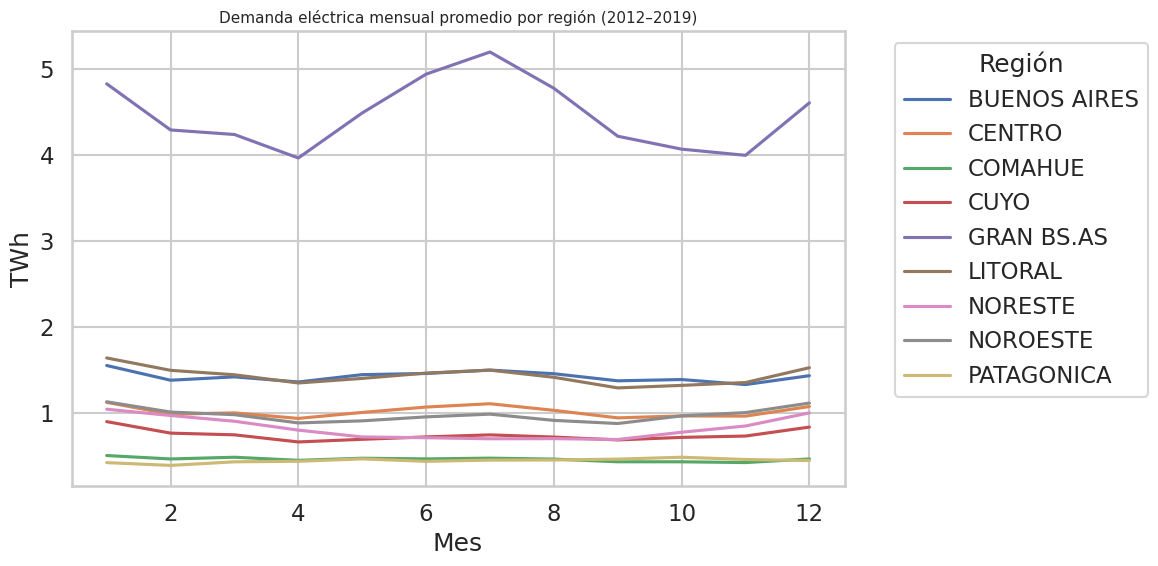

In [ ]:
# 1) Copia ordenada
dfp = df_demanda_mensual_region.sort_values(['anio', 'mes']).copy()

# 2) Elegir unidad común según el máximo del dataset

y_scaled, y_unit = auto_scale_energy(dfp["demanda_mensual_MWh"], base_unit="MWh")

# 3) Guardar la columna convertida
dfp["demanda_plot"] = y_scaled

# 4) Plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=dfp,
    x="mes",
    y="demanda_plot",
    hue="region",
    estimator="mean",
    errorbar=None
)

plt.title("Demanda eléctrica mensual promedio por región (2012–2019)")
plt.xlabel("Mes")
plt.ylabel(y_unit)  # <- acá queda MWh / GWh / TWh según corresponda

plt.legend(title="Región", bbox_to_anchor=(1.05, 1), loc="upper left")
set_plain_yaxis(ax)  # por si aparece notación científica igual

plt.tight_layout()
plt.show()

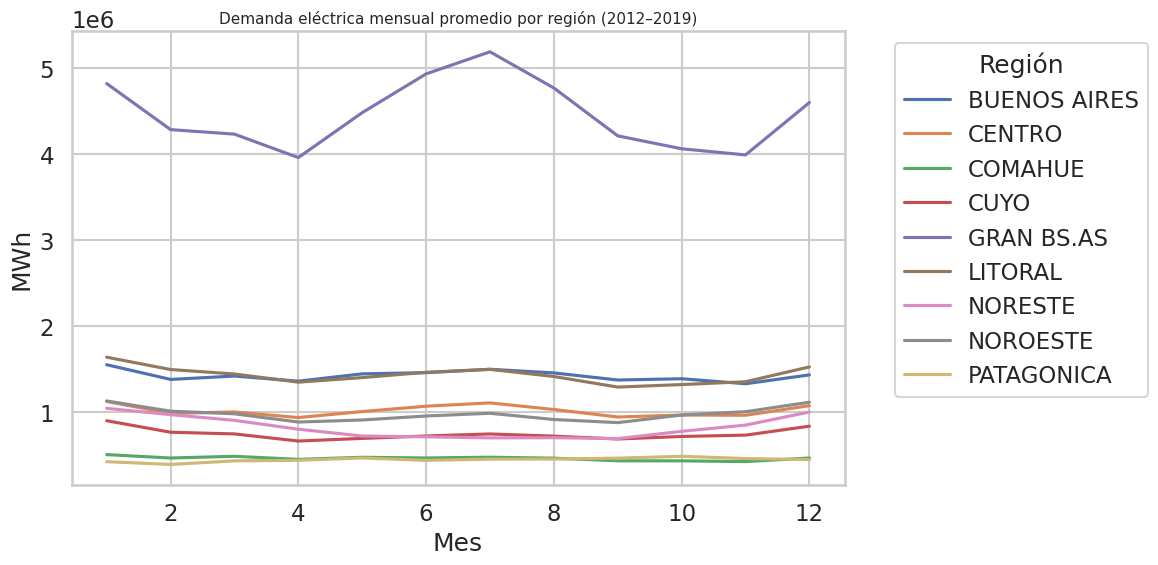

In [ ]:

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_demanda_mensual_region.sort_values(['anio', 'mes']),
    x='mes',
    y='demanda_mensual_MWh',
    hue='region',
    estimator='mean',
    errorbar=None
)

plt.title('Demanda eléctrica mensual promedio por región (2012–2019)')
plt.xlabel('Mes')
plt.ylabel('MWh')
plt.legend(title='Región', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-2113258898.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(demanda_prom["region"], rotation=45, ha="right")


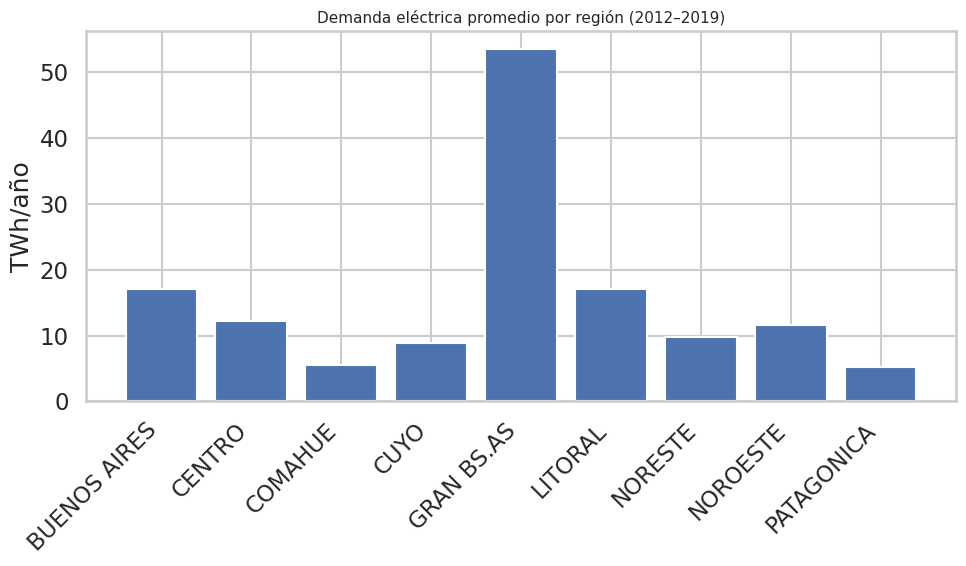

In [ ]:


demanda_prom = (
    demanda_total_anual
      .groupby("region", as_index=False)
      .agg(demanda_prom_MWh=("demanda_total_MWh", "mean"))
)

# Orden regional
orden_regiones = [
    "BUENOS AIRES","CENTRO","COMAHUE","CUYO","GRAN BS.AS",
    "LITORAL","NORESTE","NOROESTE","PATAGONICA"
]

demanda_prom["region"] = pd.Categorical(
    demanda_prom["region"], categories=orden_regiones, ordered=True
)
demanda_prom = demanda_prom.sort_values("region")

# ---- ESCALADO AUTOMÁTICO (evita 1e6 / 1e7) ----
y_scaled, y_unit = auto_scale_energy(demanda_prom["demanda_prom_MWh"], base_unit="MWh")
demanda_prom["demanda_plot"] = y_scaled

# ---- PLOT ----
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(demanda_prom["region"], demanda_prom["demanda_plot"])

ax.set_xticklabels(demanda_prom["region"], rotation=45, ha="right")
ax.set_ylabel(f"{y_unit}/año")
ax.set_title("Demanda eléctrica promedio por región (2012–2019)")

set_plain_yaxis(ax)  # opcional (por si aparece notación científica igual)
plt.tight_layout()
plt.show()

Evolución anual de la demanda eléctrica por región

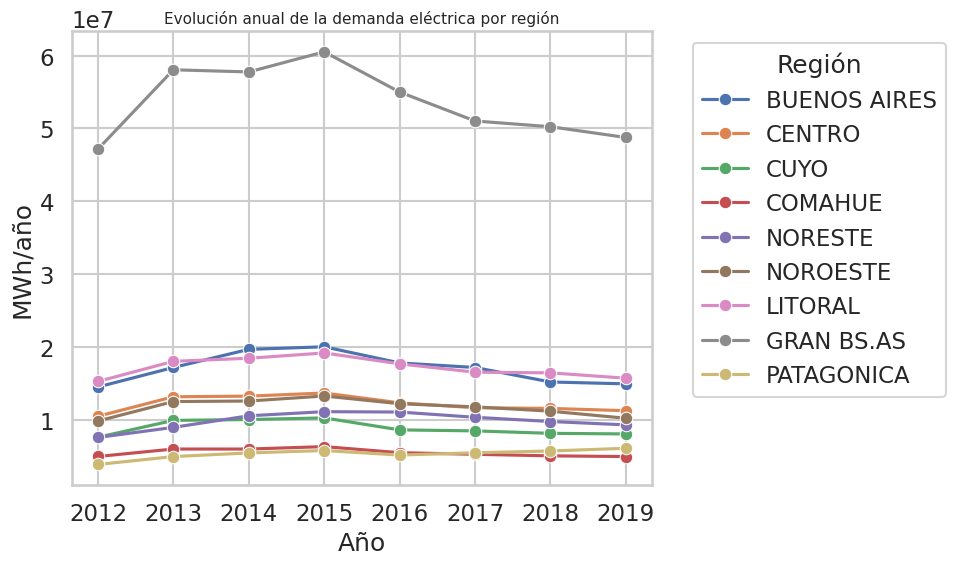

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=demanda_total_anual.sort_values('anio'),
    x='anio',
    y='demanda_total_MWh',
    hue='region',
    marker='o'
)

plt.title('Evolución anual de la demanda eléctrica por región')
plt.xlabel('Año')
plt.ylabel('MWh/año')
plt.legend(title='Región', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Boxplot distribución de la demanda anual por región

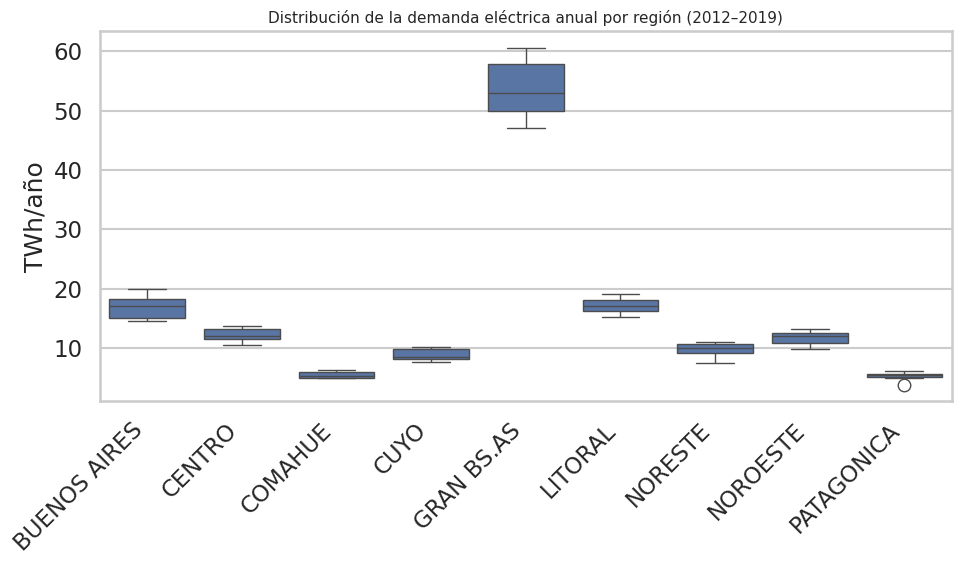

In [ ]:

# Copia para no tocar el df original
dfp = demanda_total_anual.copy()

# Escalado automático (una única unidad para todo el gráfico)
y_scaled, y_unit = auto_scale_energy(dfp["demanda_total_MWh"], base_unit="MWh")
dfp["demanda_plot"] = y_scaled

plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=dfp,
    x="region",
    y="demanda_plot"
)

plt.xticks(rotation=45, ha="right")
plt.title("Distribución de la demanda eléctrica anual por región (2012–2019)")
plt.ylabel(f"{y_unit}/año")
plt.xlabel("")  # elimina "region"

set_plain_yaxis(ax)  # opcional
plt.tight_layout()
plt.show()

Boxplot coeficiente de variación de la demanda por región

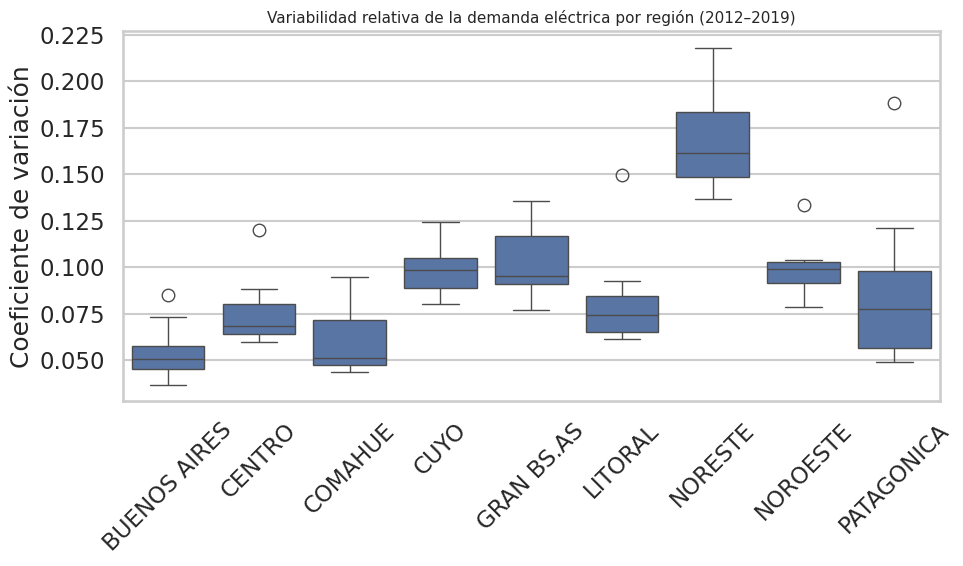

In [ ]:
#Boxplot de coef_variacion_demanda por región
plt.figure(figsize=(10,6))
sns.boxplot(
    data=demanda_anual,
    x="region",
    y="coef_variacion_demanda"
)
plt.xticks(rotation=45)
plt.title("Variabilidad relativa de la demanda eléctrica por región (2012–2019)")
plt.ylabel("Coeficiente de variación")
plt.xlabel("")  # <- elimina "region"
plt.tight_layout()
plt.show()


###3.2 Generación eléctrica

####3.2.1 Limpieza y filtrado inicial

In [ ]:
# Copia de trabajo
df_gen = df_generacion_raw.copy()

# Columnas relevantes
cols_gen_keep = [
    'anio', 'mes',
    'region', 'pais',
    'generacion_neta_MWh'
]
df_gen = df_gen[cols_gen_keep]

# Tipos
df_gen['anio'] = df_gen['anio'].astype(int)
df_gen['mes']  = df_gen['mes'].astype(int)

# Filtrar años
df_gen = df_gen.query('2012 <= anio <= 2019')

# Solo Argentina
df_gen['pais'] = df_gen['pais'].astype(str).str.upper()
df_gen = df_gen[df_gen['pais'] == 'ARGENTINA']

# Limpiar región
df_gen['region'] = df_gen['region'].astype(str).str.strip()
df_gen = df_gen[
    (df_gen['region'] != '') &
    (df_gen['region'].str.lower() != '(en blanco)')
]

# Excluir región "GENERACION MOVIL"
movil = df_gen['region'].str.contains('MOVIL', na=False)
print(f"Registros de región GENERACIÓN MÓVIL eliminados: {movil.sum()}")
df_gen = df_gen[~movil]

# Quitar generación negativa
neg_gen = (df_gen['generacion_neta_MWh'] < 0).sum()
print(f"Registros de generación negativos eliminados: {neg_gen}")
df_gen = df_gen[df_gen['generacion_neta_MWh'] >= 0]

validar_dataset(df_gen, "Generación limpia (2012–2019)")
display(df_gen.head())

Registros de región GENERACIÓN MÓVIL eliminados: 27499
Registros de generación negativos eliminados: 0

🔍 Validando: Generación limpia (2012–2019)
📊 Filas: 62,921  |  Columnas: 5

✅ No se detectaron valores nulos.


anio  mes        region       pais  generacion_neta_MWh
0  2012    1  BUENOS AIRES  ARGENTINA                0.000
1  2012    1       COMAHUE  ARGENTINA           21,868.984
2  2012    1       COMAHUE  ARGENTINA           24,144.517
3  2012    1       COMAHUE  ARGENTINA           24,259.713
4  2012    1       COMAHUE  ARGENTINA           26,832.135

####3.2.2 Normalización y validación territorial

---



In [ ]:
df_gen = normalizar_region(df_gen)
print ("REGIONES NORMALIZADAS")
df_gen['region'].unique()

REGIONES NORMALIZADAS


array(['BUENOS AIRES', 'COMAHUE', 'CUYO', 'NORESTE', 'PATAGONICA',
       'NOROESTE', 'GRAN BS.AS', 'CENTRO', 'LITORAL'], dtype=object)

####3.2.3 Agregación mensual por región


In [ ]:
df_generacion_mensual_region = agregar_periodo(
    df_gen,
    group_cols=["region", "anio", "mes"],
    value_col="generacion_neta_MWh",
    nombre_salida="generacion_mensual_MWh"
)

validar_dataset(
    df_generacion_mensual_region,
    "Generación mensual por región (2012–2019)",
    cols_clave=["region", "anio", "mes"]
)

display(df_generacion_mensual_region.head())


🔍 Validando: Generación mensual por región (2012–2019)
📊 Filas: 864  |  Columnas: 4
➡️ Duplicados en ['region', 'anio', 'mes']: 0

✅ No se detectaron valores nulos.


region  anio  mes  generacion_mensual_MWh
0  BUENOS AIRES  2012    1           2,110,122.159
1  BUENOS AIRES  2012    2           1,894,719.261
2  BUENOS AIRES  2012    3           1,667,789.087
3  BUENOS AIRES  2012    4           1,910,227.508
4  BUENOS AIRES  2012    5           1,883,486.290

In [ ]:
df_generacion_mensual_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   region                  864 non-null    object 
 1   anio                    864 non-null    int64  
 2   mes                     864 non-null    int64  
 3   generacion_mensual_MWh  864 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.1+ KB


####3.2.4 Agregación anual y métricas intra-anuales

In [ ]:
#Generación total anual
generacion_total_anual = agregar_periodo(
    df_generacion_mensual_region,
    group_cols=["region", "anio"],
    value_col="generacion_mensual_MWh",
    nombre_salida="generacion_total_MWh"
)

In [ ]:
#Métricas intra-anuales de generación
generacion_stats = (
    df_generacion_mensual_region
    .groupby(["region", "anio"], as_index=False)
    .agg(
        generacion_media_MWh=("generacion_mensual_MWh", "mean"),  # media mensual
        generacion_std_MWh=("generacion_mensual_MWh", "std"),     # desvío mensual
        generacion_max_MWh=("generacion_mensual_MWh", "max"),     # mes de mayor generación
        generacion_min_MWh=("generacion_mensual_MWh", "min")      # mes de menor generación
    )
)


In [ ]:
#Coeficiente de variación
cv_generacion = calcular_cv(
    df_generacion_mensual_region,
    group_cols=["region", "anio"],
    value_col="generacion_mensual_MWh",
    nombre_cv="coef_variacion_generacion"
)

In [ ]:
#Integración del dataset anual de generación
generacion_anual = (
    generacion_total_anual
    .merge(generacion_stats, on=["region", "anio"])
    .merge(cv_generacion, on=["region", "anio"])
)


In [ ]:
#Indicador de dispersión extrema (max/min)
generacion_anual["ratio_max_min_generacion"] = np.where(
    generacion_anual["generacion_min_MWh"] > 0,
    generacion_anual["generacion_max_MWh"] / generacion_anual["generacion_min_MWh"],
    np.nan
)


####3.2.5 Validación final

In [ ]:
validar_dataset(
    generacion_anual,
    "Generación anual por región (2012–2019)",
    cols_clave=["region", "anio"]
)

display(generacion_anual.head())


🔍 Validando: Generación anual por región (2012–2019)
📊 Filas: 72  |  Columnas: 9
➡️ Duplicados en ['region', 'anio']: 0

✅ No se detectaron valores nulos.


region  anio  generacion_total_MWh  generacion_media_MWh  \
0  BUENOS AIRES  2012        22,851,045.902         1,904,253.825   
1  BUENOS AIRES  2013        20,772,559.057         1,731,046.588   
2  BUENOS AIRES  2014        23,445,089.457         1,953,757.455   
3  BUENOS AIRES  2015        25,863,298.611         2,155,274.884   
4  BUENOS AIRES  2016        29,381,339.861         2,448,444.988   

   generacion_std_MWh  generacion_max_MWh  generacion_min_MWh  \
0         112,453.859       2,110,122.159       1,667,789.087   
1         213,349.545       2,043,349.057       1,431,465.494   
2         192,973.276       2,282,584.933       1,725,888.468   
3         270,248.841       2,421,776.251       1,644,181.540   
4         244,911.502       2,846,604.027       2,007,477.640   

   coef_variacion_generacion  ratio_max_min_generacion  
0                      0.059                     1.265  
1                      0.123                     1.427  
2                      0.099                     1.323  
3                      0.125                     1.473  
4                      0.100                     1.418

In [ ]:
generacion_anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     72 non-null     object 
 1   anio                       72 non-null     int64  
 2   generacion_total_MWh       72 non-null     float64
 3   generacion_media_MWh       72 non-null     float64
 4   generacion_std_MWh         72 non-null     float64
 5   generacion_max_MWh         72 non-null     float64
 6   generacion_min_MWh         72 non-null     float64
 7   coef_variacion_generacion  72 non-null     float64
 8   ratio_max_min_generacion   72 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 5.2+ KB


####3.2.6 Gráficos y visualizaciones

Generación eléctrica mensual promedio por región

/tmp/ipython-input-2571644735.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(gen_promedio["region"], rotation=45, ha="right")


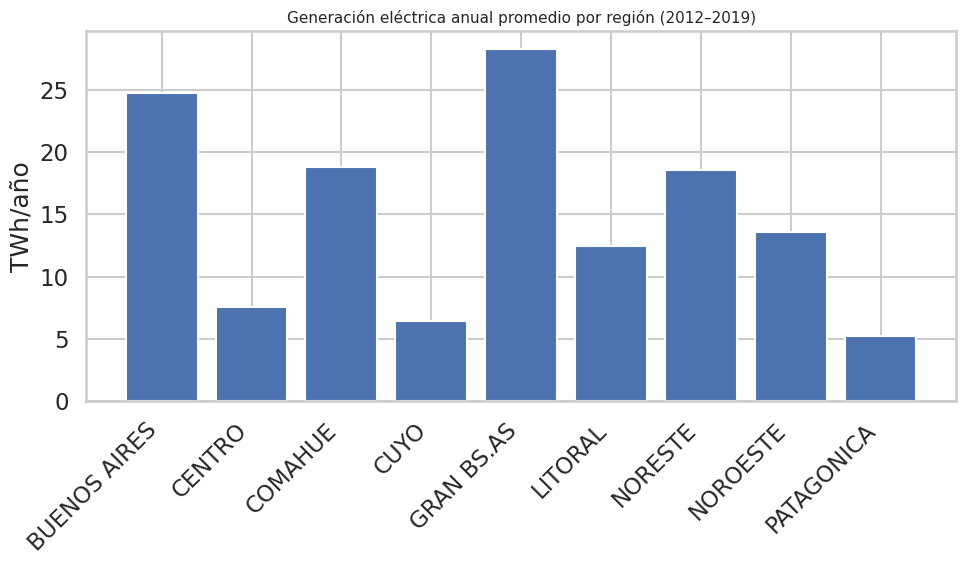

In [ ]:
# Promedio anual de generación por región
gen_promedio = (
    generacion_anual
    .groupby("region", as_index=False)
    .agg(generacion_promedio_MWh=("generacion_total_MWh", "mean"))
)

# Normalizar texto (igual que venís haciendo)
gen_promedio["region"] = (
    gen_promedio["region"]
    .astype(str)
    .str.strip()
    .str.upper()
)

# Orden regional (mismo que DEMANDA)
orden_regiones = [
    "BUENOS AIRES",
    "CENTRO",
    "COMAHUE",
    "CUYO",
    "GRAN BS.AS",
    "LITORAL",
    "NORESTE",
    "NOROESTE",
    "PATAGONICA"
]

gen_promedio["region"] = pd.Categorical(
    gen_promedio["region"],
    categories=orden_regiones,
    ordered=True
)
gen_promedio = gen_promedio.sort_values("region")

# ---- ESCALADO AUTOMÁTICO (evita 1e6 / 1e7) ----
y_scaled, y_unit = auto_scale_energy(gen_promedio["generacion_promedio_MWh"], base_unit="MWh")
gen_promedio["gen_plot"] = y_scaled

# ---- PLOT ----
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(gen_promedio["region"], gen_promedio["gen_plot"])

ax.set_title("Generación eléctrica anual promedio por región (2012–2019)")
ax.set_ylabel(f"{y_unit}/año")
ax.set_xticklabels(gen_promedio["region"], rotation=45, ha="right")

set_plain_yaxis(ax)
plt.tight_layout()
plt.show()

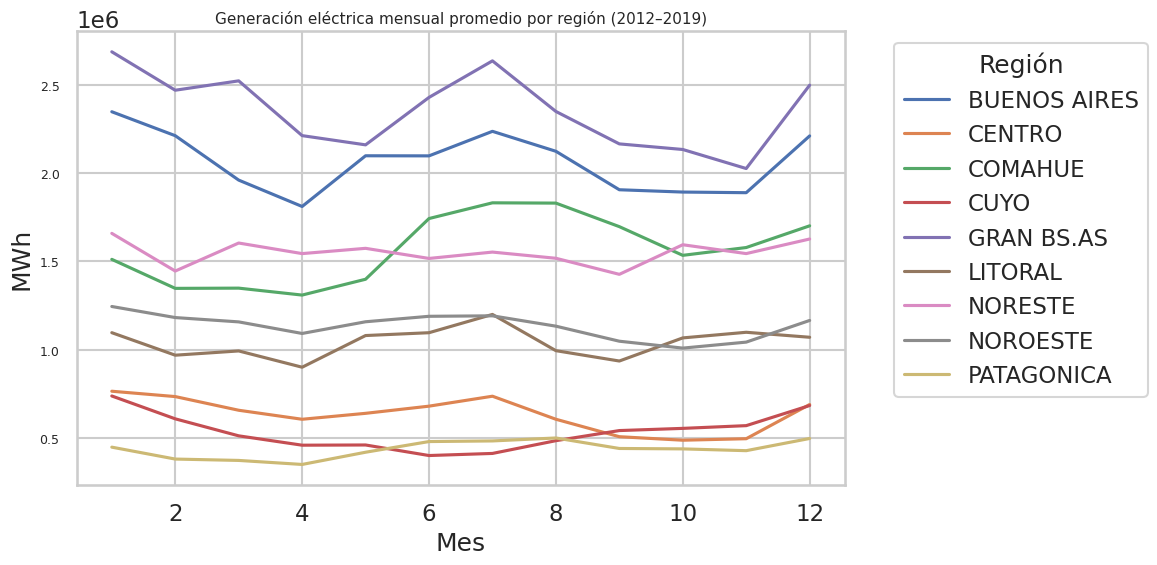

In [ ]:
#Generación mensual promedio por región (estacionalidad)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_generacion_mensual_region.sort_values(["anio", "mes"]),
    x="mes",
    y="generacion_mensual_MWh",
    hue="region",
    estimator="mean",
    errorbar=None
)

plt.title("Generación eléctrica mensual promedio por región (2012–2019)")
plt.xlabel("Mes")
plt.ylabel("MWh")
plt.yticks(fontsize=9)
plt.legend(title="Región", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Evolución anual de la generación eléctrica por región

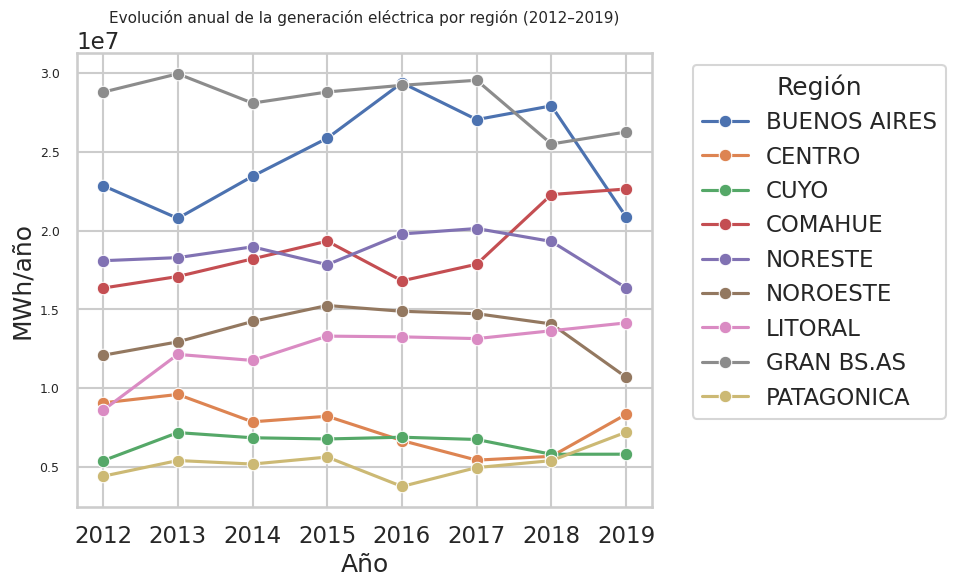

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=generacion_total_anual.sort_values("anio"),
    x="anio",
    y="generacion_total_MWh",
    hue="region",
    marker="o"
)

plt.title("Evolución anual de la generación eléctrica por región (2012–2019)")
plt.xlabel("Año")
plt.ylabel("MWh/año")
plt.yticks(fontsize=9)
plt.legend(title="Región", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



Boxplot distribución de la generación anual por región

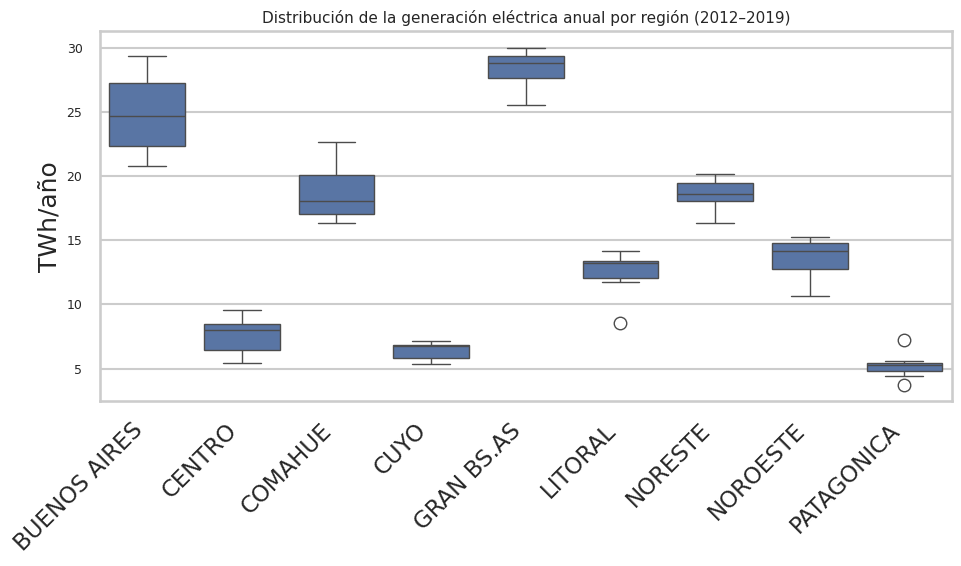

In [ ]:
# Copia para no tocar el df original
dfp = generacion_anual.copy()

# Normalizar región (por si viene con espacios/minúsculas)
dfp["region"] = dfp["region"].astype(str).str.strip().str.upper()

# Orden regional estándar (igual que demanda)
orden_regiones = [
    "BUENOS AIRES","CENTRO","COMAHUE","CUYO","GRAN BS.AS",
    "LITORAL","NORESTE","NOROESTE","PATAGONICA"
]
dfp["region"] = pd.Categorical(dfp["region"], categories=orden_regiones, ordered=True)

# Escalado automático (evita 1e6/1e7)
y_scaled, y_unit = auto_scale_energy(dfp["generacion_total_MWh"], base_unit="MWh")
dfp["generacion_plot"] = y_scaled

# Boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=dfp,
    x="region",
    y="generacion_plot"
)

plt.xticks(rotation=45, ha="right")
plt.title("Distribución de la generación eléctrica anual por región (2012–2019)")
plt.ylabel(f"{y_unit}/año")
plt.xlabel("")
plt.yticks(fontsize=9)

set_plain_yaxis(ax)  # opcional
plt.tight_layout()
plt.show()

Boxplot coeficiente de variación de la generación por región

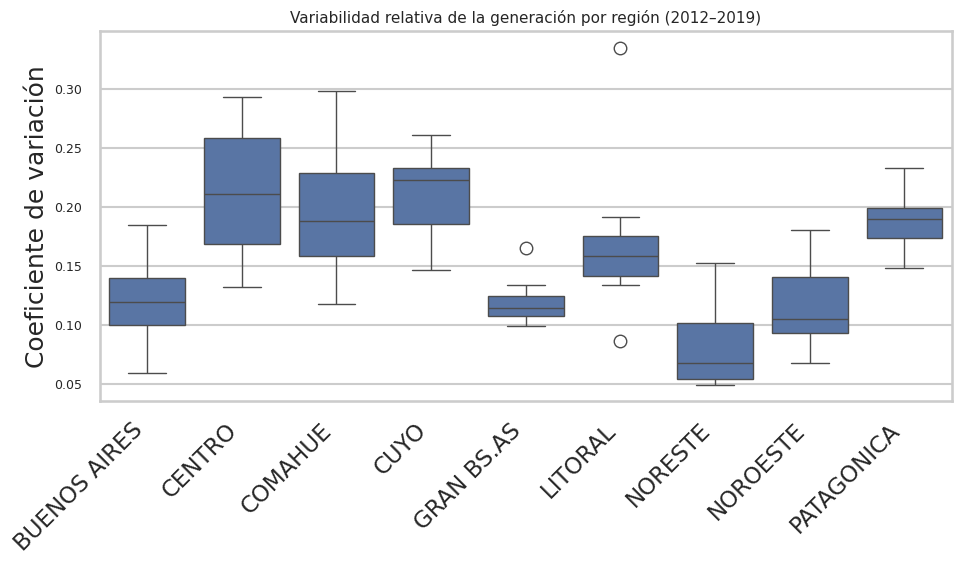

In [ ]:
# Boxplot: variabilidad relativa (CV) de la generación por región
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=generacion_anual,
    x="region",
    y="coef_variacion_generacion"
)

plt.xticks(rotation=45, ha="right")
plt.title("Variabilidad relativa de la generación por región (2012–2019)")
plt.ylabel("Coeficiente de variación")
plt.xlabel("")  # <- elimina "region"
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


###3.3 Integración Demanda - Generación

####3.3.1 Integración de datasets anuales

In [ ]:
df_balance = (
    demanda_anual
    .merge(
        generacion_anual,
        on=["region", "anio"],
        how="inner"
    )
)

In [ ]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     72 non-null     object 
 1   anio                       72 non-null     int64  
 2   demanda_total_MWh          72 non-null     float64
 3   demanda_media_MWh          72 non-null     float64
 4   demanda_std_MWh            72 non-null     float64
 5   demanda_max_MWh            72 non-null     float64
 6   demanda_min_MWh            72 non-null     float64
 7   coef_variacion_demanda     72 non-null     float64
 8   ratio_max_min_demanda      72 non-null     float64
 9   generacion_total_MWh       72 non-null     float64
 10  generacion_media_MWh       72 non-null     float64
 11  generacion_std_MWh         72 non-null     float64
 12  generacion_max_MWh         72 non-null     float64
 13  generacion_min_MWh         72 non-null     float64
 

####3.3.2 Indicadores de balance eléctrico

In [ ]:
df_balance['balance_MWh'] = (
    df_balance['generacion_total_MWh'] - df_balance['demanda_total_MWh']
)

In [ ]:
df_balance["balance_ratio"] = np.where(
    df_balance["demanda_total_MWh"] > 0,
    df_balance["generacion_total_MWh"] / df_balance["demanda_total_MWh"],
    np.nan
)

🔹Tabla – Indicadores base del balance eléctrico

Estos indicadores describen el balance eléctrico regional y constituyen la base para la construcción de métricas analíticas posteriores.

| Indicador              | Descripción                                                                 | Interpretación                                              |
|------------------------|-----------------------------------------------------------------------------|-------------------------------------------------------------|
| demanda_total_MWh      | Demanda eléctrica anual total de la región (suma de los 12 meses)           | Nivel total de consumo eléctrico regional                   |
| generacion_total_MWh   | Generación eléctrica anual total de la región                               | Capacidad anual de producción eléctrica regional            |
| balance_MWh            | Diferencia entre generación y demanda (generación − demanda)               | Superávit o déficit eléctrico absoluto                     |
| balance_ratio          | Cobertura relativa de la demanda por la generación (generación / demanda)  | Valores > 1 indican superávit; < 1 indican déficit          |


####3.3.3 Validación del dataset integrado

In [ ]:
validar_dataset(df_balance, "Demanda + Generación + Balance (features)", cols_clave=['region', 'anio'])
display(df_balance.head())



🔍 Validando: Demanda + Generación + Balance (features)
📊 Filas: 72  |  Columnas: 18
➡️ Duplicados en ['region', 'anio']: 0

✅ No se detectaron valores nulos.


region  anio  demanda_total_MWh  demanda_media_MWh  demanda_std_MWh  \
0  BUENOS AIRES  2012     14,497,572.186      1,208,131.015       44,616.316   
1  BUENOS AIRES  2013     17,175,302.820      1,431,275.235       66,219.705   
2  BUENOS AIRES  2014     19,664,678.841      1,638,723.237       85,256.820   
3  BUENOS AIRES  2015     20,018,695.265      1,668,224.605       70,074.316   
4  BUENOS AIRES  2016     17,802,014.904      1,483,501.242      126,486.172   

   demanda_max_MWh  demanda_min_MWh  coef_variacion_demanda  \
0    1,295,051.002    1,151,237.515                   0.037   
1    1,587,237.609    1,351,015.613                   0.046   
2    1,799,218.256    1,511,949.699                   0.052   
3    1,763,772.397    1,563,474.220                   0.042   
4    1,805,026.107    1,336,713.101                   0.085   

   ratio_max_min_demanda  generacion_total_MWh  generacion_media_MWh  \
0                  1.125        22,851,045.902         1,904,253.825   
1                  1.175        20,772,559.057         1,731,046.588   
2                  1.190        23,445,089.457         1,953,757.455   
3                  1.128        25,863,298.611         2,155,274.884   
4                  1.350        29,381,339.861         2,448,444.988   

   generacion_std_MWh  generacion_max_MWh  generacion_min_MWh  \
0         112,453.859       2,110,122.159       1,667,789.087   
1         213,349.545       2,043,349.057       1,431,465.494   
2         192,973.276       2,282,584.933       1,725,888.468   
3         270,248.841       2,421,776.251       1,644,181.540   
4         244,911.502       2,846,604.027       2,007,477.640   

   coef_variacion_generacion  ratio_max_min_generacion    balance_MWh  \
0                      0.059                     1.265  8,353,473.716   
1                      0.123                     1.427  3,597,256.237   
2                      0.099                     1.323  3,780,410.616   
3                      0.125                     1.473  5,844,603.346   
4                      0.100                     1.418 11,579,324.957   

   balance_ratio  
0          1.576  
1          1.209  
2          1.192  
3          1.292  
4          1.650

In [ ]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     72 non-null     object 
 1   anio                       72 non-null     int64  
 2   demanda_total_MWh          72 non-null     float64
 3   demanda_media_MWh          72 non-null     float64
 4   demanda_std_MWh            72 non-null     float64
 5   demanda_max_MWh            72 non-null     float64
 6   demanda_min_MWh            72 non-null     float64
 7   coef_variacion_demanda     72 non-null     float64
 8   ratio_max_min_demanda      72 non-null     float64
 9   generacion_total_MWh       72 non-null     float64
 10  generacion_media_MWh       72 non-null     float64
 11  generacion_std_MWh         72 non-null     float64
 12  generacion_max_MWh         72 non-null     float64
 13  generacion_min_MWh         72 non-null     float64
 

3.3.4 EDA y visualizaciones (Balance)

Promedios(generación-demanda) por región

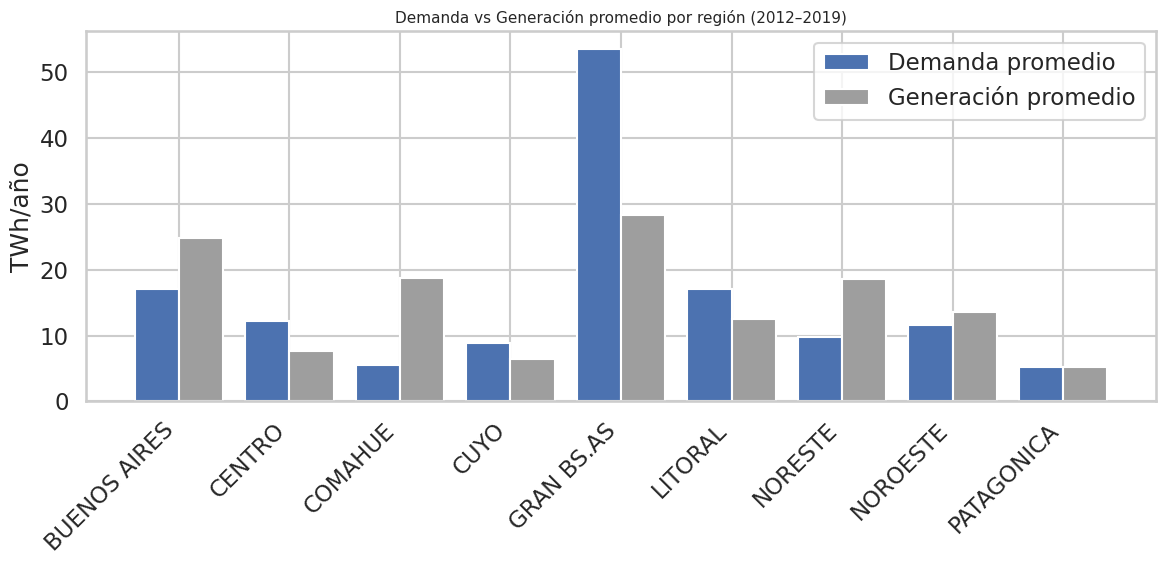

In [ ]:
# Promedios por región
demanda_prom = (
    demanda_anual.groupby("region", as_index=False)
    .agg(demanda_prom_MWh=("demanda_total_MWh", "mean"))
)

gen_prom = (
    generacion_anual.groupby("region", as_index=False)
    .agg(generacion_prom_MWh=("generacion_total_MWh", "mean"))
)

df_gyc = demanda_prom.merge(gen_prom, on="region", how="inner")

# Normalizar región (por si acaso)
df_gyc["region"] = df_gyc["region"].astype(str).str.strip().str.upper()

# Orden regional estándar
orden_regiones = [
    "BUENOS AIRES","CENTRO","COMAHUE","CUYO","GRAN BS.AS",
    "LITORAL","NORESTE","NOROESTE","PATAGONICA"
]
df_gyc["region"] = pd.Categorical(df_gyc["region"], categories=orden_regiones, ordered=True)
df_gyc = df_gyc.sort_values("region")

# ---- ESCALADO AUTOMÁTICO COMÚN (para que demanda y generación queden en la misma unidad) ----
max_comb = np.nanmax(np.abs(pd.concat([df_gyc["demanda_prom_MWh"], df_gyc["generacion_prom_MWh"]], axis=0)))

# Creamos una serie "dummy" con ese máximo para elegir la unidad una sola vez
_, y_unit = auto_scale_energy([max_comb], base_unit="MWh")

factor = 1 if y_unit == "MWh" else (1e3 if y_unit == "GWh" else 1e6)

df_gyc["demanda_plot"] = df_gyc["demanda_prom_MWh"] / factor
df_gyc["generacion_plot"] = df_gyc["generacion_prom_MWh"] / factor

# ---- PLOT ----
x = np.arange(len(df_gyc))
width = 0.40

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, df_gyc["demanda_plot"], width, label="Demanda promedio", color="#4C72B0")
ax.bar(x + width/2, df_gyc["generacion_plot"], width, label="Generación promedio", color="#9E9E9E")

ax.set_xticks(x)
ax.set_xticklabels(df_gyc["region"], rotation=45, ha="right")
ax.set_ylabel(f"{y_unit}/año")
ax.set_title("Demanda vs Generación promedio por región (2012–2019)")
ax.legend()

set_plain_yaxis(ax)  # opcional
plt.tight_layout()
plt.show()

 Balance eléctrico regional

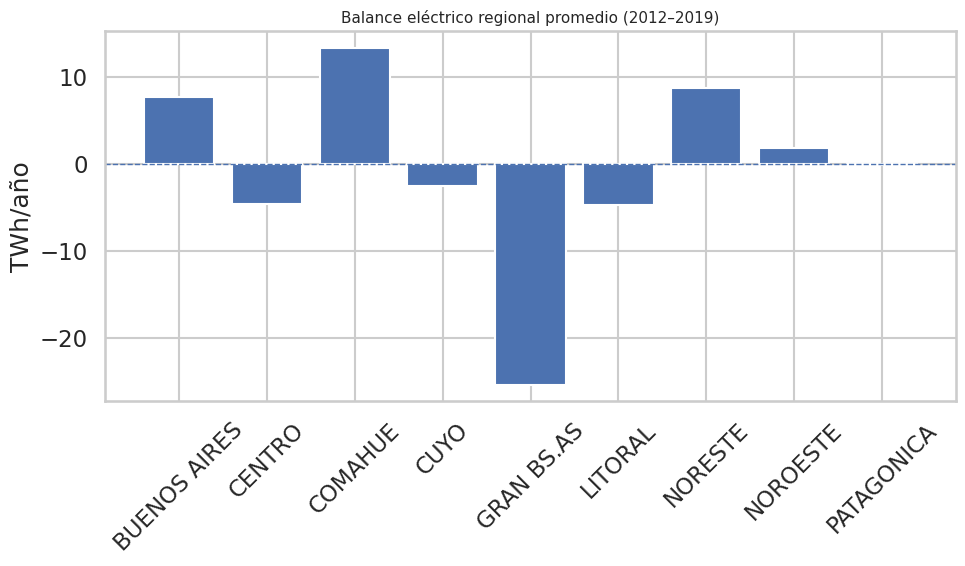

<Figure size 640x480 with 0 Axes>

In [ ]:
# Balance eléctrico por región (promedio)
balance_prom = (
    df_balance
        .groupby("region", as_index=False)
        .agg(balance_prom_MWh=("balance_MWh", "mean"))
)

# Normalizar región
balance_prom["region"] = balance_prom["region"].astype(str).str.strip().str.upper()

orden_regiones = [
    "BUENOS AIRES","CENTRO","COMAHUE","CUYO","GRAN BS.AS",
    "LITORAL","NORESTE","NOROESTE","PATAGONICA"
]
balance_prom["region"] = pd.Categorical(balance_prom["region"], categories=orden_regiones, ordered=True)
balance_prom = balance_prom.sort_values("region")

# ---- ESCALADO AUTOMÁTICO (considera positivos y negativos) ----
y_scaled, y_unit = auto_scale_energy(balance_prom["balance_prom_MWh"], base_unit="MWh")
balance_prom["balance_plot"] = y_scaled

# ---- PLOT ----

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(balance_prom["region"].astype(str), balance_prom["balance_plot"])

ax.axhline(0, linestyle="--", linewidth=1)
ax.set_ylabel(f"{y_unit}/año")
ax.set_title("Balance eléctrico regional promedio (2012–2019)")

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()


set_plain_yaxis(ax)  # opcional
plt.tight_layout()
plt.show()

In [ ]:
# promedio real de balance por región (en MWh)
balance_prom = df_balance.groupby("region", as_index=False)["balance_MWh"].mean()
balance_prom = balance_prom.sort_values("balance_MWh")
display(balance_prom)

region     balance_MWh
4    GRAN BS.AS -25,301,749.256
5       LITORAL  -4,665,805.913
1        CENTRO  -4,567,246.616
3          CUYO  -2,462,554.047
8    PATAGONICA     -71,081.006
7      NOROESTE   1,914,886.667
0  BUENOS AIRES   7,712,823.336
6       NORESTE   8,766,429.285
2       COMAHUE  13,327,252.274

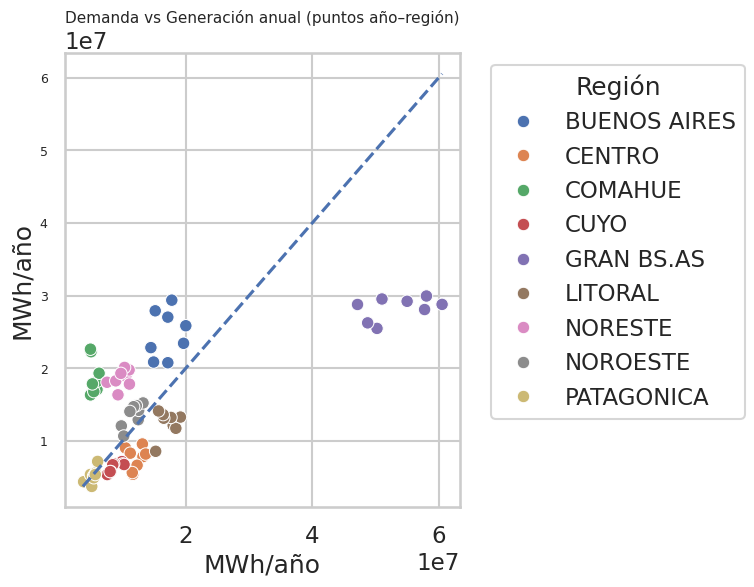

In [ ]:
df_comp = demanda_total_anual.merge(
    generacion_total_anual,
    on=["region", "anio"],
    how="inner"
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_comp,
    x="demanda_total_MWh",
    y="generacion_total_MWh",
    hue="region"
)

# Línea de equilibrio: generación = demanda
minv = min(df_comp["demanda_total_MWh"].min(), df_comp["generacion_total_MWh"].min())
maxv = max(df_comp["demanda_total_MWh"].max(), df_comp["generacion_total_MWh"].max())
plt.plot([minv, maxv], [minv, maxv], linestyle="--")

plt.title("Demanda vs Generación anual (puntos año–región)")
plt.xlabel("MWh/año")
plt.ylabel("MWh/año")
plt.yticks(fontsize=9)
plt.legend(title="Región", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


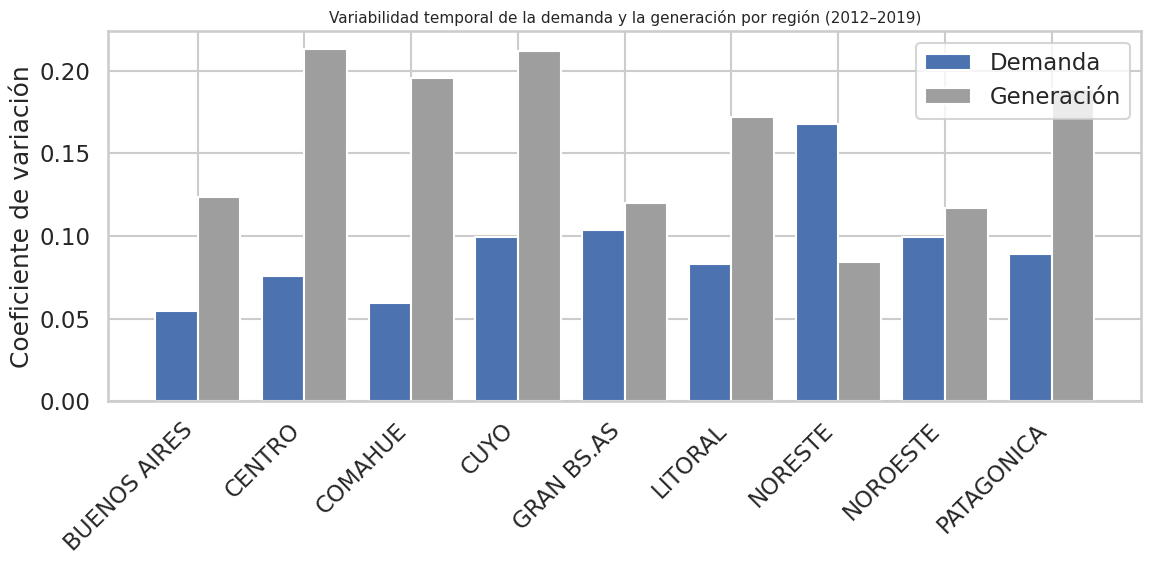

In [ ]:
# Coeficientes de variación promedio por región
cv_prom = (
    df_balance
        .groupby("region", as_index=False)
        .agg(
            cv_demanda=("coef_variacion_demanda", "mean"),
            cv_generacion=("coef_variacion_generacion", "mean")
        )
)

cv_prom["region"] = pd.Categorical(
    cv_prom["region"],
    categories=orden_regiones,
    ordered=True
)
cv_prom = cv_prom.sort_values("region")

x = range(len(cv_prom))

plt.figure(figsize=(12, 6))
plt.bar(x, cv_prom["cv_demanda"], width=0.4, label="Demanda", color="#4C72B0")
plt.bar([i + 0.4 for i in x], cv_prom["cv_generacion"], width=0.4, label="Generación", color="#9E9E9E")

plt.xticks([i + 0.2 for i in x], cv_prom["region"].astype(str), rotation=45, ha="right")
plt.ylabel("Coeficiente de variación")
plt.title("Variabilidad temporal de la demanda y la generación por región (2012–2019)")
plt.legend()
plt.tight_layout()
plt.show()

## 4.Construcción (IEER)

El Índice de Equilibrio Eléctrico Regional (IEER) se construye con el objetivo
de sintetizar, en un único indicador, el desempeño eléctrico relativo de cada
región, considerando tanto la cobertura de la demanda como la estabilidad
temporal del sistema.

###4.1 Selección de indicadores



🔹 Tabla – Indicadores utilizados en la construcción del IEER

| Indicador                    | Deriva de              | Rol en el IEER                          |
|-----------------------------|------------------------|-----------------------------------------|
| balance_ratio               | Generación / Demanda   | Componente de cobertura energética      |
| coef_variacion_demanda      | Demanda mensual        | Estabilidad de la demanda (menor = mejor) |
| coef_variacion_generacion   | Generación mensual     | Estabilidad de la generación (menor = mejor) |


El IEER no se construye a partir de magnitudes absolutas, sino de indicadores relativos y de estabilidad, con el objetivo de permitir comparaciones consistentes entre regiones de distinto tamaño y estructura productiva.

In [ ]:
df_ieer = df_balance.copy()

# Por seguridad, quitar filas con NaN en los indicadores clave
cols_clave_ieer = [
    'balance_ratio',
    'coef_variacion_demanda',
    'coef_variacion_generacion'
]
df_ieer = df_ieer.dropna(subset=cols_clave_ieer).reset_index(drop=True)

In [ ]:
df_ieer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     72 non-null     object 
 1   anio                       72 non-null     int64  
 2   demanda_total_MWh          72 non-null     float64
 3   demanda_media_MWh          72 non-null     float64
 4   demanda_std_MWh            72 non-null     float64
 5   demanda_max_MWh            72 non-null     float64
 6   demanda_min_MWh            72 non-null     float64
 7   coef_variacion_demanda     72 non-null     float64
 8   ratio_max_min_demanda      72 non-null     float64
 9   generacion_total_MWh       72 non-null     float64
 10  generacion_media_MWh       72 non-null     float64
 11  generacion_std_MWh         72 non-null     float64
 12  generacion_max_MWh         72 non-null     float64
 13  generacion_min_MWh         72 non-null     float64
 

###4.2 Normalización de componentes

Dado que los indicadores presentan escalas diferentes, se aplicó
una normalización min–max para garantizar comparabilidad y permitir
su agregación en un índice sintético.


In [ ]:
# Cobertura (mayor = mejor)
df_ieer['coverage_norm'] = min_max_norm(df_ieer['balance_ratio'])

# Estabilidad (menor variabilidad = mejor)
df_ieer['stab_demanda_norm'] = 1 - min_max_norm(df_ieer['coef_variacion_demanda'])
df_ieer['stab_generacion_norm'] = 1 - min_max_norm(df_ieer['coef_variacion_generacion'])


In [ ]:
df_ieer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     72 non-null     object 
 1   anio                       72 non-null     int64  
 2   demanda_total_MWh          72 non-null     float64
 3   demanda_media_MWh          72 non-null     float64
 4   demanda_std_MWh            72 non-null     float64
 5   demanda_max_MWh            72 non-null     float64
 6   demanda_min_MWh            72 non-null     float64
 7   coef_variacion_demanda     72 non-null     float64
 8   ratio_max_min_demanda      72 non-null     float64
 9   generacion_total_MWh       72 non-null     float64
 10  generacion_media_MWh       72 non-null     float64
 11  generacion_std_MWh         72 non-null     float64
 12  generacion_max_MWh         72 non-null     float64
 13  generacion_min_MWh         72 non-null     float64
 

In [ ]:
# Diccionario de etiquetas
LABELS_TESIS = {
    "coverage_norm": "Cobertura",
    "stab_demanda_norm": "Estab.de la demanda",
    "stab_generacion_norm": "Estab.de la generación",
    "IEER": "Índice de Equilibrio Eléctrico Regional (IEER)",
    "balance_ratio": "Relación generación/demanda",
    "balance_MWh": "Balance eléctrico (MWh)"
}
def lab(col):
    """Devuelve etiqueta linda para la tesis."""
    return LABELS_TESIS.get(col, col)

### 4.3 Validación de la normalización

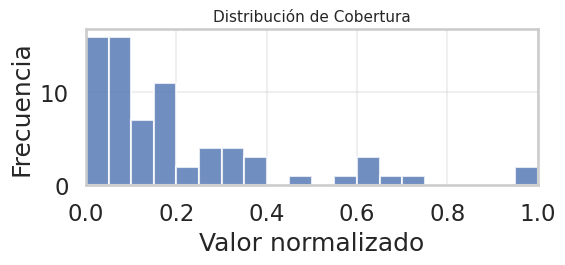

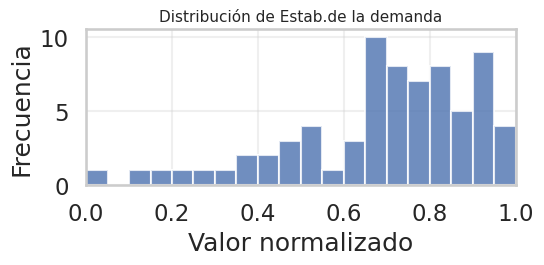

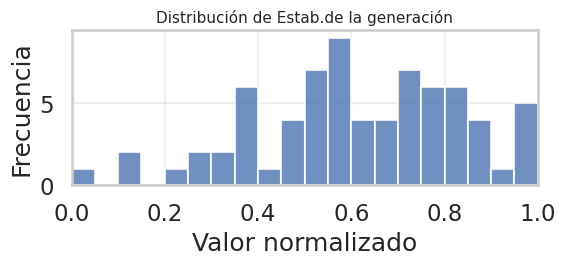

In [ ]:
cols = ["coverage_norm", "stab_demanda_norm", "stab_generacion_norm"]

for c in cols:
    plt.figure(figsize=(6,3))
    plt.hist(df_ieer[c].dropna(), bins=20, alpha=0.8)
    plt.xlim(0, 1)
    plt.xlabel("Valor normalizado")
    plt.ylabel("Frecuencia")
    plt.title(f"Distribución de {LABELS_TESIS.get(c, c)}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

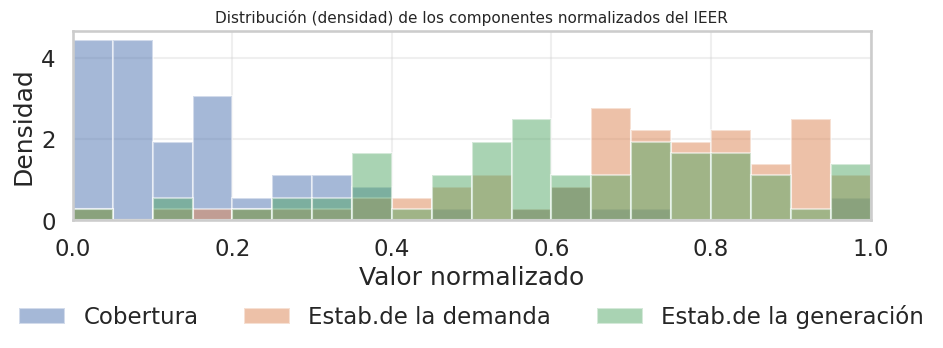

In [ ]:
plt.figure(figsize=(10,4))

for c in cols:
    plt.hist(
        df_ieer[c].dropna(),
        bins=20,
        alpha=0.5,
        density=True,
        label=lab(c)  # etiqueta en español
    )

plt.xlim(0, 1)
plt.xlabel("Valor normalizado")
plt.ylabel("Densidad")
plt.title("Distribución (densidad) de los componentes normalizados del IEER")
plt.legend(title=" ", bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=3, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Calculo IERR

In [ ]:
# Índice IEER (promedio de los tres componentes)
df_ieer['IEER'] = (
    df_ieer['coverage_norm'] +
    df_ieer['stab_demanda_norm'] +
    df_ieer['stab_generacion_norm']
) / 3

In [ ]:
df_ieer.head()

region  anio  demanda_total_MWh  demanda_media_MWh  demanda_std_MWh  \
0  BUENOS AIRES  2012     14,497,572.186      1,208,131.015       44,616.316   
1  BUENOS AIRES  2013     17,175,302.820      1,431,275.235       66,219.705   
2  BUENOS AIRES  2014     19,664,678.841      1,638,723.237       85,256.820   
3  BUENOS AIRES  2015     20,018,695.265      1,668,224.605       70,074.316   
4  BUENOS AIRES  2016     17,802,014.904      1,483,501.242      126,486.172   

   demanda_max_MWh  demanda_min_MWh  coef_variacion_demanda  \
0    1,295,051.002    1,151,237.515                   0.037   
1    1,587,237.609    1,351,015.613                   0.046   
2    1,799,218.256    1,511,949.699                   0.052   
3    1,763,772.397    1,563,474.220                   0.042   
4    1,805,026.107    1,336,713.101                   0.085   

   ratio_max_min_demanda  generacion_total_MWh  generacion_media_MWh  \
0                  1.125        22,851,045.902         1,904,253.825   
1                  1.175        20,772,559.057         1,731,046.588   
2                  1.190        23,445,089.457         1,953,757.455   
3                  1.128        25,863,298.611         2,155,274.884   
4                  1.350        29,381,339.861         2,448,444.988   

   generacion_std_MWh  generacion_max_MWh  generacion_min_MWh  \
0         112,453.859       2,110,122.159       1,667,789.087   
1         213,349.545       2,043,349.057       1,431,465.494   
2         192,973.276       2,282,584.933       1,725,888.468   
3         270,248.841       2,421,776.251       1,644,181.540   
4         244,911.502       2,846,604.027       2,007,477.640   

   coef_variacion_generacion  ratio_max_min_generacion    balance_MWh  \
0                      0.059                     1.265  8,353,473.716   
1                      0.123                     1.427  3,597,256.237   
2                      0.099                     1.323  3,780,410.616   
3                      0.125                     1.473  5,844,603.346   
4                      0.100                     1.418 11,579,324.957   

   balance_ratio  coverage_norm  stab_demanda_norm  stab_generacion_norm  IEER  
0          1.576          0.270              1.000                 0.966 0.745  
1          1.209          0.181              0.948                 0.740 0.623  
2          1.192          0.177              0.916                 0.826 0.640  
3          1.292          0.201              0.972                 0.733 0.635  
4          1.650          0.288              0.733                 0.822 0.614

In [ ]:
df_ieer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     72 non-null     object 
 1   anio                       72 non-null     int64  
 2   demanda_total_MWh          72 non-null     float64
 3   demanda_media_MWh          72 non-null     float64
 4   demanda_std_MWh            72 non-null     float64
 5   demanda_max_MWh            72 non-null     float64
 6   demanda_min_MWh            72 non-null     float64
 7   coef_variacion_demanda     72 non-null     float64
 8   ratio_max_min_demanda      72 non-null     float64
 9   generacion_total_MWh       72 non-null     float64
 10  generacion_media_MWh       72 non-null     float64
 11  generacion_std_MWh         72 non-null     float64
 12  generacion_max_MWh         72 non-null     float64
 13  generacion_min_MWh         72 non-null     float64
 

### 4.5 Resultados descriptivos

<Figure size 1000x600 with 0 Axes>

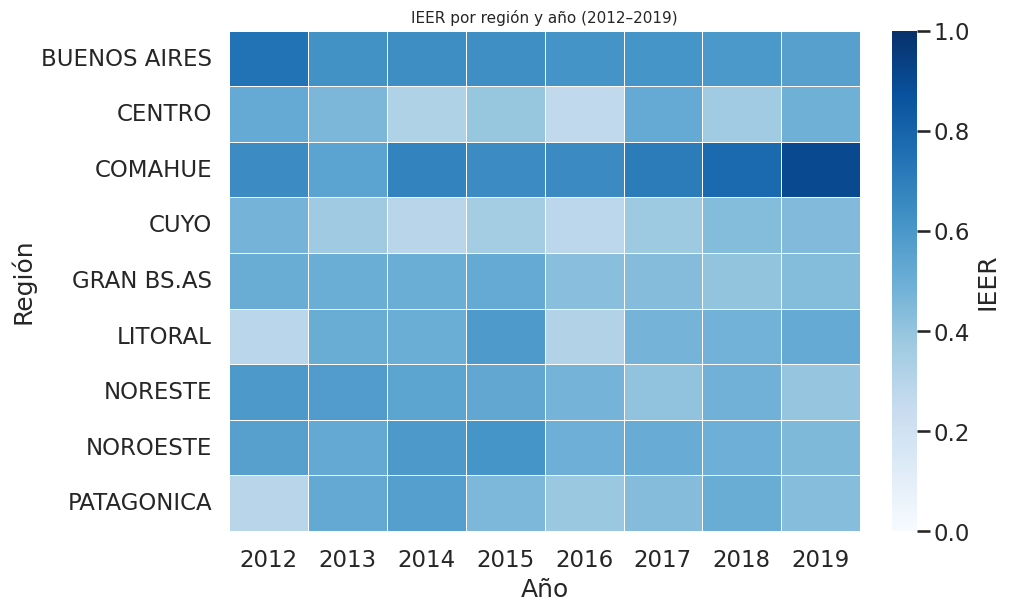

In [ ]:
# Tabla para heatmap: filas = región, columnas = año, valor = IEER
ieer_pivot = df_ieer.pivot(index='region', columns='anio', values='IEER')

# Orden CAMMESA (recomendado para lectura territorial)
orden_regiones = [
    "BUENOS AIRES",
    "CENTRO",
    "COMAHUE",
    "CUYO",
    "GRAN BS.AS",
    "LITORAL",
    "NORESTE",
    "NOROESTE",
    "PATAGONICA"
]
ieer_pivot = ieer_pivot.reindex(orden_regiones)

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

sns.heatmap(
    ieer_pivot,
    annot=False,
    cmap='Blues',
    vmin=0, vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'IEER'},
    ax=ax
)

ax.set_title('IEER por región y año (2012–2019)')
ax.set_xlabel('Año')
ax.set_ylabel('Región')

plt.show()


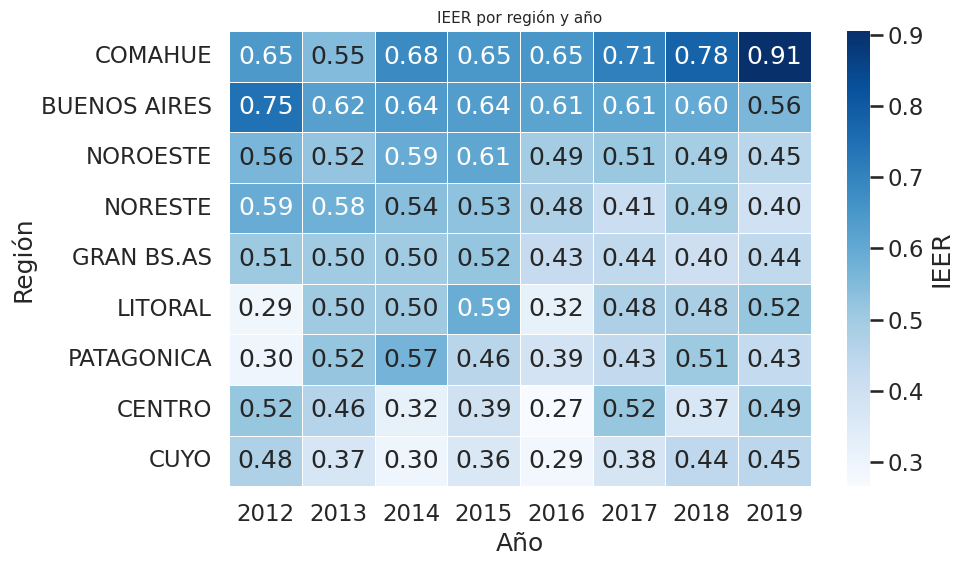

In [ ]:
# Tabla para heatmap: filas = región, columnas = año, valor = IEER
ieer_pivot = (
    df_ieer
      .pivot(index='region', columns='anio', values='IEER')
)

# (opcional) ordenar regiones por IEER promedio
orden_regiones = (
    df_ieer
      .groupby('region')['IEER']
      .mean()
      .sort_values(ascending=False)
      .index
)
ieer_pivot = ieer_pivot.loc[orden_regiones]

plt.figure(figsize=(10, 6))
sns.heatmap(
    ieer_pivot,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    linewidths=0.5,
    cbar_kws={'label': 'IEER'}
)
plt.title('IEER por región y año')
plt.xlabel('Año')
plt.ylabel('Región')
plt.tight_layout()
plt.show()


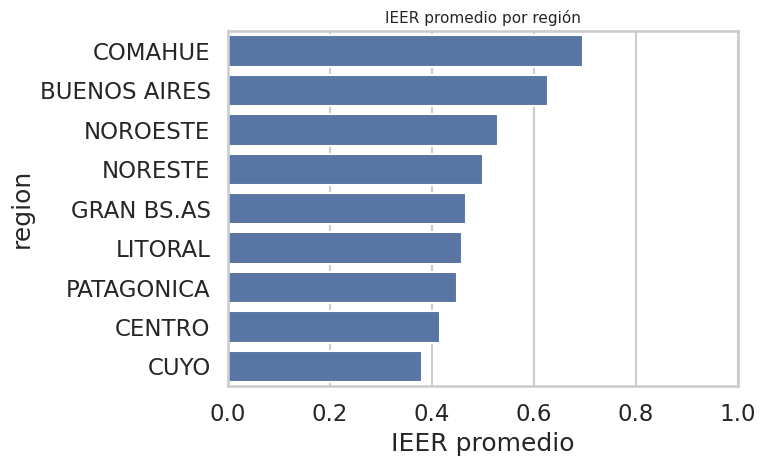

In [ ]:
#Muestra qué regiones tienen mejor desempeño en promedio.
ieer_region = (
    df_ieer
      .groupby('region')['IEER']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=ieer_region,
    x='IEER',
    y='region',
    color='#4C72B0'# azul
)
plt.title('IEER promedio por región')
plt.xlabel('IEER promedio')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

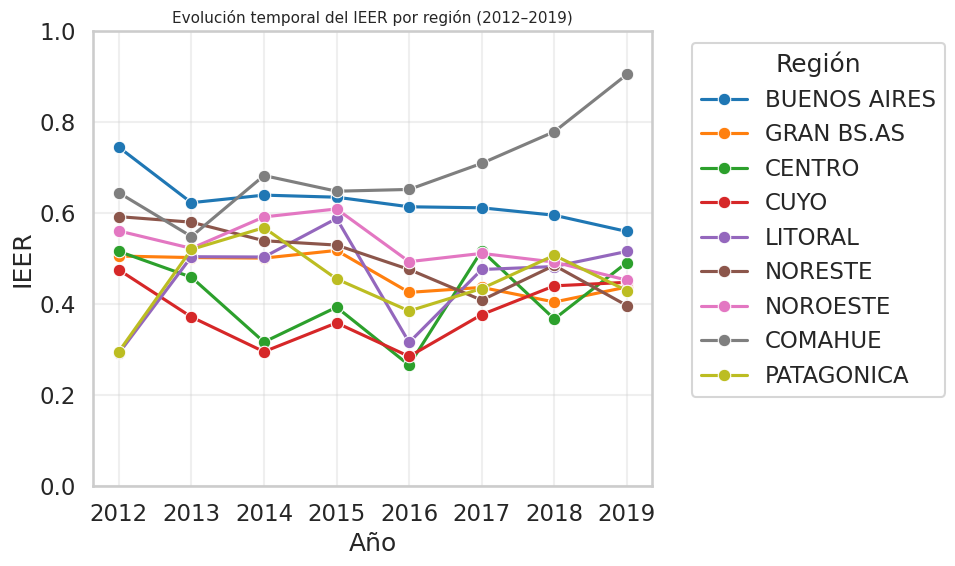

In [ ]:
# 1) Definir el orden regional
orden_regiones = [
    "BUENOS AIRES",
    "GRAN BS.AS",
    "CENTRO",
    "CUYO",
    "LITORAL",
    "NORESTE",
    "NOROESTE",
    "COMAHUE",
    "PATAGONICA"
]

# 2) Copia para no tocar el df original
df_plot = df_ieer.copy()

# Filtrar período por consistencia
df_plot = df_plot[df_plot["anio"].between(2012, 2019)]

# 3) Convertir region a categórica ordenada
df_plot["region"] = pd.Categorical(df_plot["region"], categories=orden_regiones, ordered=True)

# 4) Ordenar por region y año
df_plot = df_plot.sort_values(["region", "anio"])

# 5) Definir paleta de colores
colores = {
    "BUENOS AIRES": "#1f77b4",
    "GRAN BS.AS": "#ff7f0e",
    "CENTRO": "#2ca02c",
    "CUYO": "#d62728",
    "LITORAL": "#9467bd",
    "NORESTE": "#8c564b",
    "NOROESTE": "#e377c2",
    "COMAHUE": "#7f7f7f",
    "PATAGONICA": "#bcbd22"
}

# 6) Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_plot,
    x="anio",
    y="IEER",
    hue="region",
    hue_order=orden_regiones, # <-- esto ordena leyenda y trazos
    palette=colores,
    marker="o"
)

plt.title("Evolución temporal del IEER por región (2012–2019)")
plt.xlabel("Año")
plt.ylabel("IEER")
plt.ylim(0, 1)
plt.legend(title="Región", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


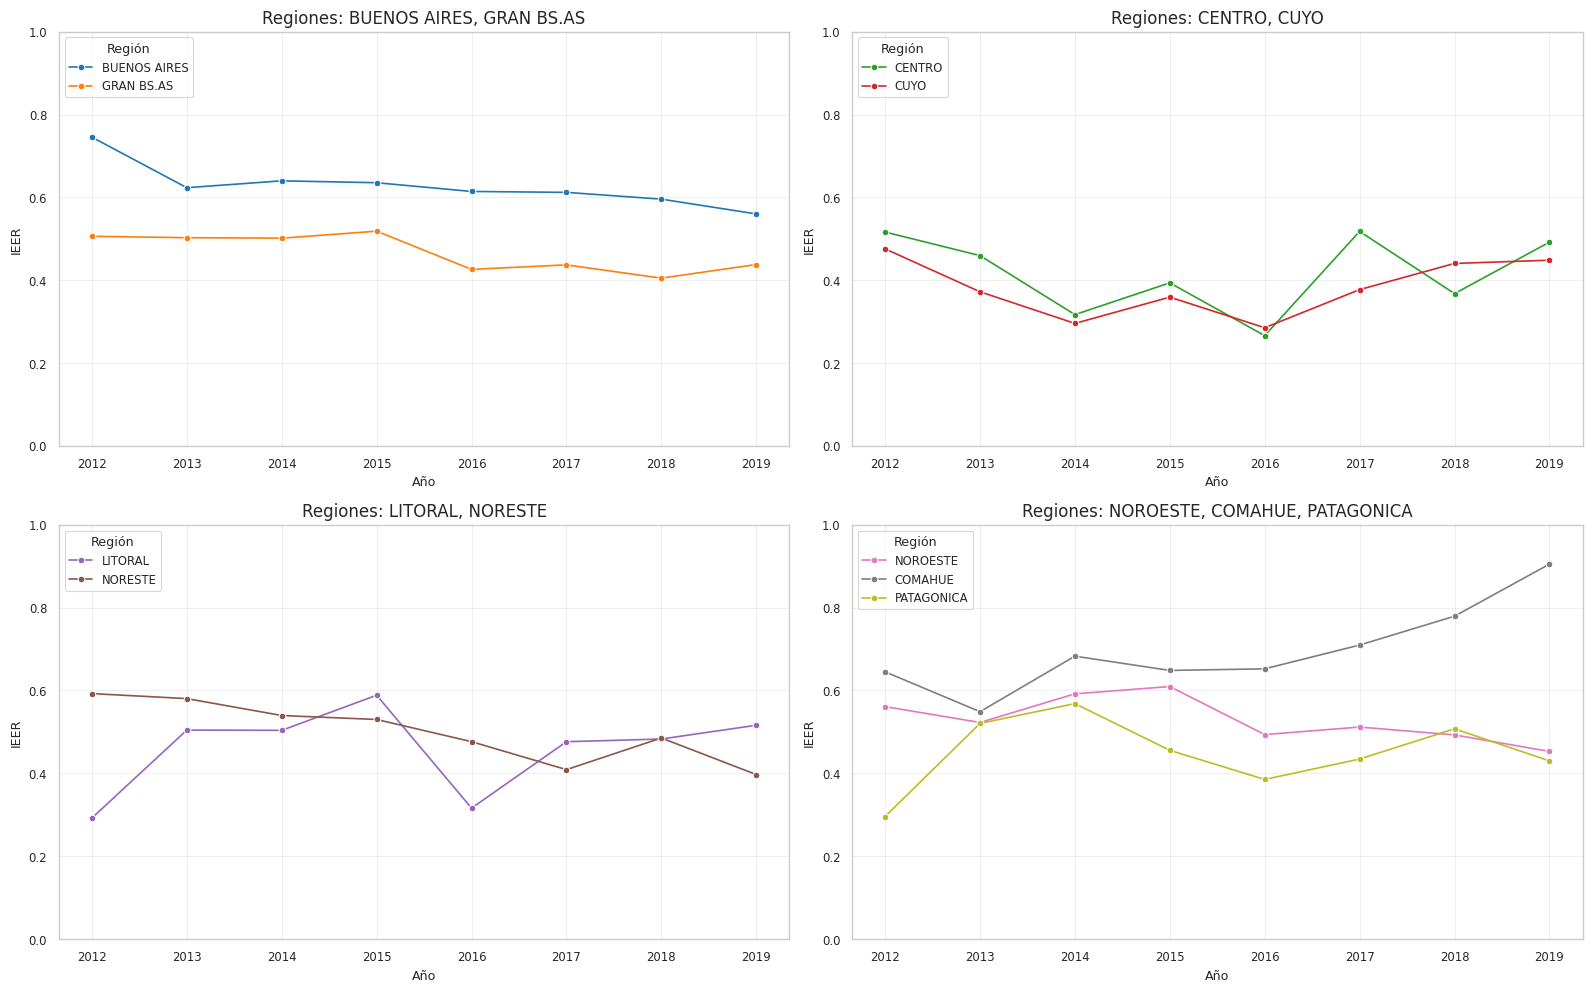

In [ ]:

# ================================
# 1) Copia del dataframe original
# ================================
df_plot = df_ieer.copy()  # tu df original
df_plot.columns = df_plot.columns.str.strip().str.lower()  # limpiar nombres

# Verificamos que exista la columna "region"
if "region" not in df_plot.columns:
    raise KeyError("No se encuentra la columna 'region'. Revisa los nombres del dataframe.")

# ================================
# 2) Filtrar período por consistencia
# ================================
df_plot = df_plot[df_plot["anio"].between(2012, 2019)]

# ================================
# 3) Definir orden regional y categorica
# ================================
orden_regiones = [
    "BUENOS AIRES",
    "GRAN BS.AS",
    "CENTRO",
    "CUYO",
    "LITORAL",
    "NORESTE",
    "NOROESTE",
    "COMAHUE",
    "PATAGONICA"
]

df_plot["region"] = pd.Categorical(df_plot["region"], categories=orden_regiones, ordered=True)
df_plot = df_plot.sort_values(["region", "anio"])

# ================================
# 4) Definir paleta de colores global
# ================================
colores = {
    "BUENOS AIRES": "#1f77b4",
    "GRAN BS.AS": "#ff7f0e",
    "CENTRO": "#2ca02c",
    "CUYO": "#d62728",
    "LITORAL": "#9467bd",
    "NORESTE": "#8c564b",
    "NOROESTE": "#e377c2",
    "COMAHUE": "#7f7f7f",
    "PATAGONICA": "#bcbd22"
}

# ================================
# 5) Definir grupos de regiones por subplot
# ================================
grupos = [
    ["BUENOS AIRES", "GRAN BS.AS"],
    ["CENTRO", "CUYO"],
    ["LITORAL", "NORESTE"],
    ["NOROESTE", "COMAHUE", "PATAGONICA"]
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2x2 grid
axes = axes.flatten()

# ================================
# 6) Plot por grupo con colores consistentes
# ================================
for i, grupo in enumerate(grupos):
    ax = axes[i]
    # Extraer solo los colores de este grupo
    paleta_grupo = {r: colores[r] for r in grupo}

    sns.lineplot(
        data=df_plot[df_plot["region"].isin(grupo)],
        x="anio",
        y="ieer",
        hue="region",
        hue_order=grupo,
        palette=paleta_grupo,   # <-- asignar colores
        marker="o",
        ax=ax
    )
    ax.set_title(f"Regiones: {', '.join(grupo)}", fontsize=12)
    ax.set_xlabel("Año")
    ax.set_ylabel("IEER")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Región", loc="upper left")

plt.tight_layout()
plt.show()


Nota: Gráficos por grupo, evolución fácil de visualizar.

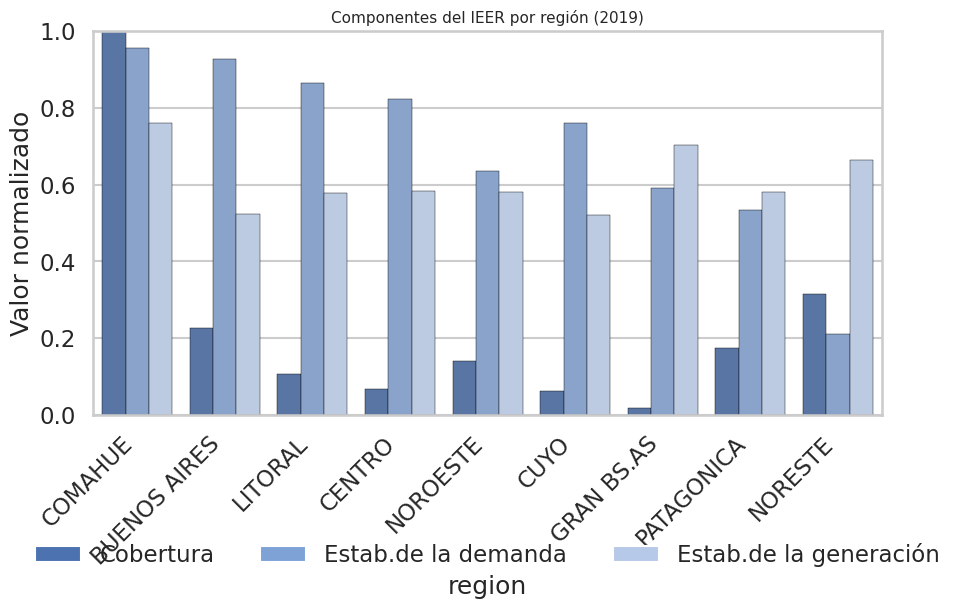

In [ ]:
# Comparación de componentes del IEER (un año puntual)
anio_ref = df_ieer["anio"].max()

df_comp = (
    df_ieer[df_ieer["anio"] == anio_ref]
      .sort_values("IEER", ascending=False)
)

plt.figure(figsize=(10, 6))

df_comp_plot = df_comp.melt(
    id_vars=["region"],
    value_vars=["coverage_norm", "stab_demanda_norm", "stab_generacion_norm"],
    var_name="componente",
    value_name="valor"
)

# Orden fijo de componentes
orden_componentes = ["coverage_norm", "stab_demanda_norm", "stab_generacion_norm"]
df_comp_plot["componente"] = pd.Categorical(
    df_comp_plot["componente"],
    categories=orden_componentes,
    ordered=True
)

# Paleta sobria (mismo color, distinta intensidad)
palette = {
    "coverage_norm": "#4C72B0",
    "stab_demanda_norm": "#7EA1D6",
    "stab_generacion_norm": "#B7C9E8"
}

ax = sns.barplot(
    data=df_comp_plot,
    x="region",
    y="valor",
    hue="componente",
    palette=palette,
    edgecolor="black",
    linewidth=0.3
)

# Leyenda manual usando etiquetas tesis
legend_elements = [
    Patch(facecolor=palette["coverage_norm"], label=lab("coverage_norm")),
    Patch(facecolor=palette["stab_demanda_norm"], label=lab("stab_demanda_norm")),
    Patch(facecolor=palette["stab_generacion_norm"], label=lab("stab_generacion_norm")),
]

# Leyenda abajo (más legible)
ax.legend(
    handles=legend_elements,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.28),
    ncol=3,
    frameon=False
)

plt.title(f"Componentes del IEER por región ({anio_ref})")
#plt.xlabel("Región")
plt.ylabel("Valor normalizado")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.subplots_adjust(bottom=0.28)
plt.show()

In [ ]:
df_ieer_region = (
    df_ieer
      .groupby('region', as_index=False)
      .agg(
          IEER_promedio=('IEER', 'mean'),
          IEER_std=('IEER', 'std'),
          IEER_min=('IEER', 'min'),
          IEER_max=('IEER', 'max')
      )
      .sort_values('IEER_promedio', ascending=False)
      .reset_index(drop=True)
)

display(df_ieer_region)

region  IEER_promedio  IEER_std  IEER_min  IEER_max
0       COMAHUE          0.696     0.107     0.549     0.905
1  BUENOS AIRES          0.628     0.054     0.560     0.745
2      NOROESTE          0.529     0.054     0.453     0.609
3       NORESTE          0.501     0.073     0.397     0.592
4    GRAN BS.AS          0.467     0.045     0.405     0.518
5       LITORAL          0.460     0.102     0.292     0.589
6    PATAGONICA          0.450     0.085     0.296     0.568
7        CENTRO          0.416     0.095     0.266     0.518
8          CUYO          0.382     0.070     0.285     0.476

In [ ]:
df_ieer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     72 non-null     object 
 1   anio                       72 non-null     int64  
 2   demanda_total_MWh          72 non-null     float64
 3   demanda_media_MWh          72 non-null     float64
 4   demanda_std_MWh            72 non-null     float64
 5   demanda_max_MWh            72 non-null     float64
 6   demanda_min_MWh            72 non-null     float64
 7   coef_variacion_demanda     72 non-null     float64
 8   ratio_max_min_demanda      72 non-null     float64
 9   generacion_total_MWh       72 non-null     float64
 10  generacion_media_MWh       72 non-null     float64
 11  generacion_std_MWh         72 non-null     float64
 12  generacion_max_MWh         72 non-null     float64
 13  generacion_min_MWh         72 non-null     float64
 

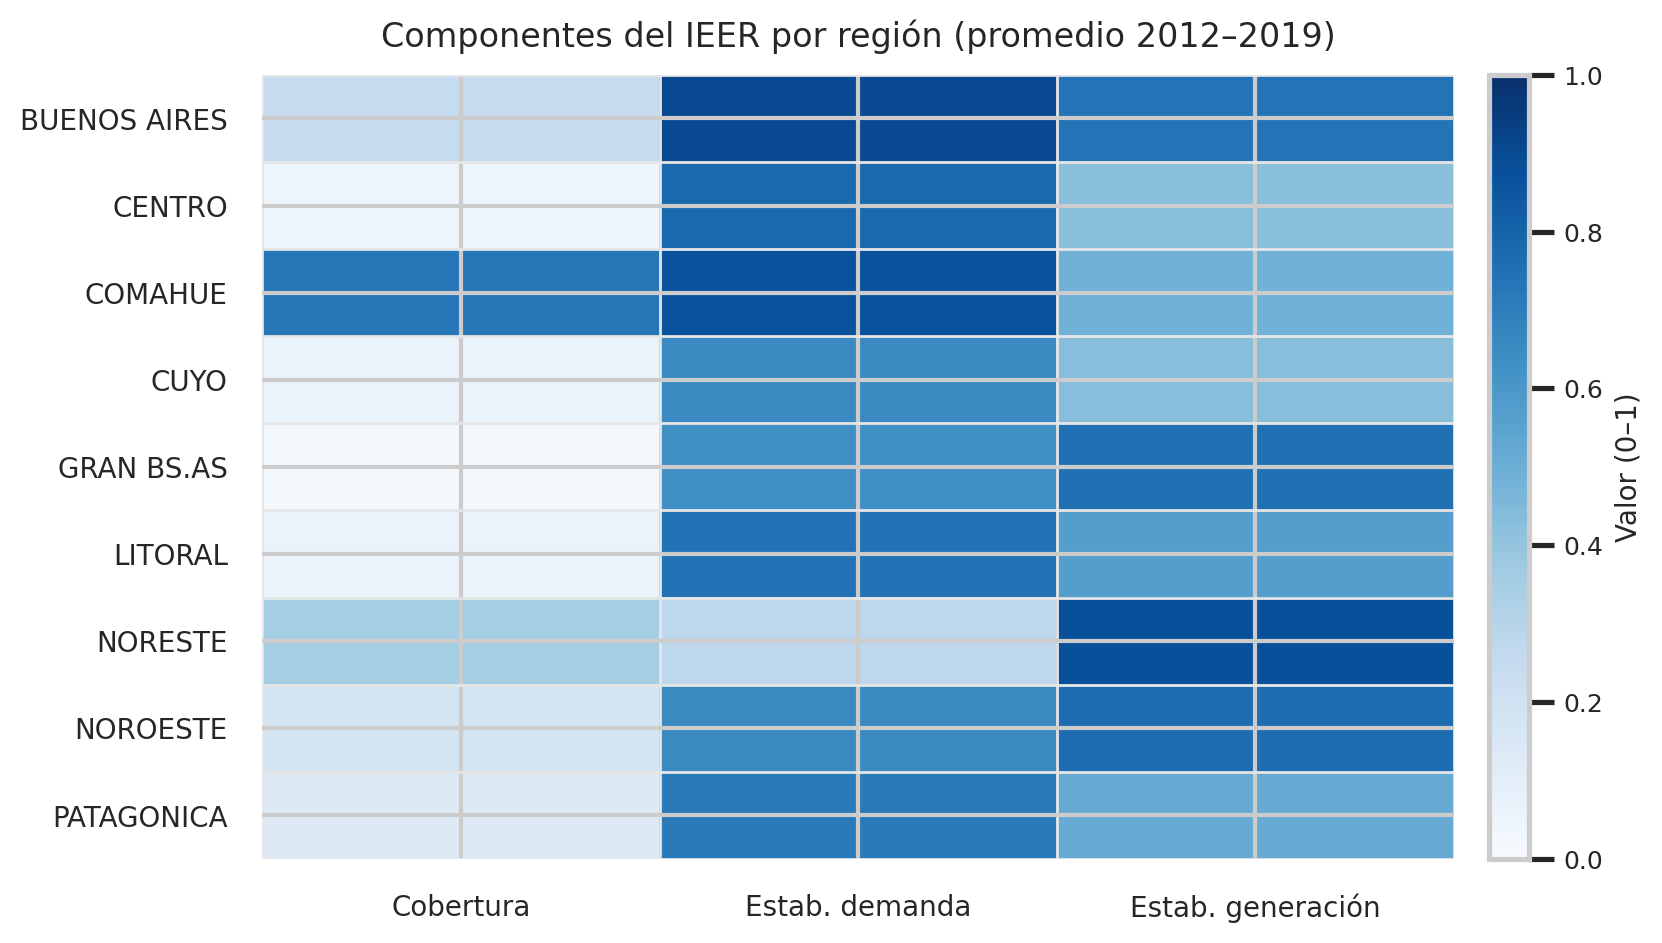

In [ ]:
cols = ["coverage_norm", "stab_demanda_norm", "stab_generacion_norm"]

orden_regiones = [
    "BUENOS AIRES", "CENTRO", "COMAHUE", "CUYO", "GRAN BS.AS",
    "LITORAL", "NORESTE", "NOROESTE", "PATAGONICA"
]

prom = (df_ieer
        .groupby("region")[cols]
        .mean()
        .rename(columns={
            "coverage_norm": "Cobertura",
            "stab_demanda_norm": "Estab. demanda",
            "stab_generacion_norm": "Estab. generación"
        }))

prom = prom.reindex([r for r in orden_regiones if r in prom.index])

fig, ax = plt.subplots(figsize=(8.2, 4.6), dpi=200, constrained_layout=True)

im = ax.imshow(
    prom.values,
    aspect="auto",
    cmap="Blues",
    vmin=0, vmax=1
)

ax.set_xticks(np.arange(prom.shape[1]))
ax.set_xticklabels(prom.columns, fontsize=10)
ax.set_yticks(np.arange(prom.shape[0]))
ax.set_yticklabels(prom.index, fontsize=10)

ax.set_xticks(np.arange(-.5, prom.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, prom.shape[0], 1), minor=True)
ax.grid(which="minor", color="0.90", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
cbar.set_label("Valor (0–1)", fontsize=10)
cbar.ax.tick_params(labelsize=9)

ax.set_title("Componentes del IEER por región (promedio 2012–2019)", fontsize=12, pad=10)
for spine in ax.spines.values():
    spine.set_visible(False)

# Export (si querés recorte, mantené bbox_inches="tight"; si querés tamaño fijo, sacalo)
fig.savefig("ieer_componentes_region.png", dpi=300, bbox_inches="tight")
fig.savefig("ieer_componentes_region.pdf", bbox_inches="tight")
plt.show()


In [ ]:
print(prom)

              Cobertura  Estab. demanda  Estab. generación
region                                                    
BUENOS AIRES      0.243           0.901              0.740
CENTRO            0.040           0.784              0.425
COMAHUE           0.730           0.874              0.486
CUYO              0.063           0.653              0.429
GRAN BS.AS        0.016           0.632              0.752
LITORAL           0.064           0.746              0.570
NORESTE           0.352           0.275              0.877
NOROESTE          0.170           0.655              0.763
PATAGONICA        0.127           0.711              0.510


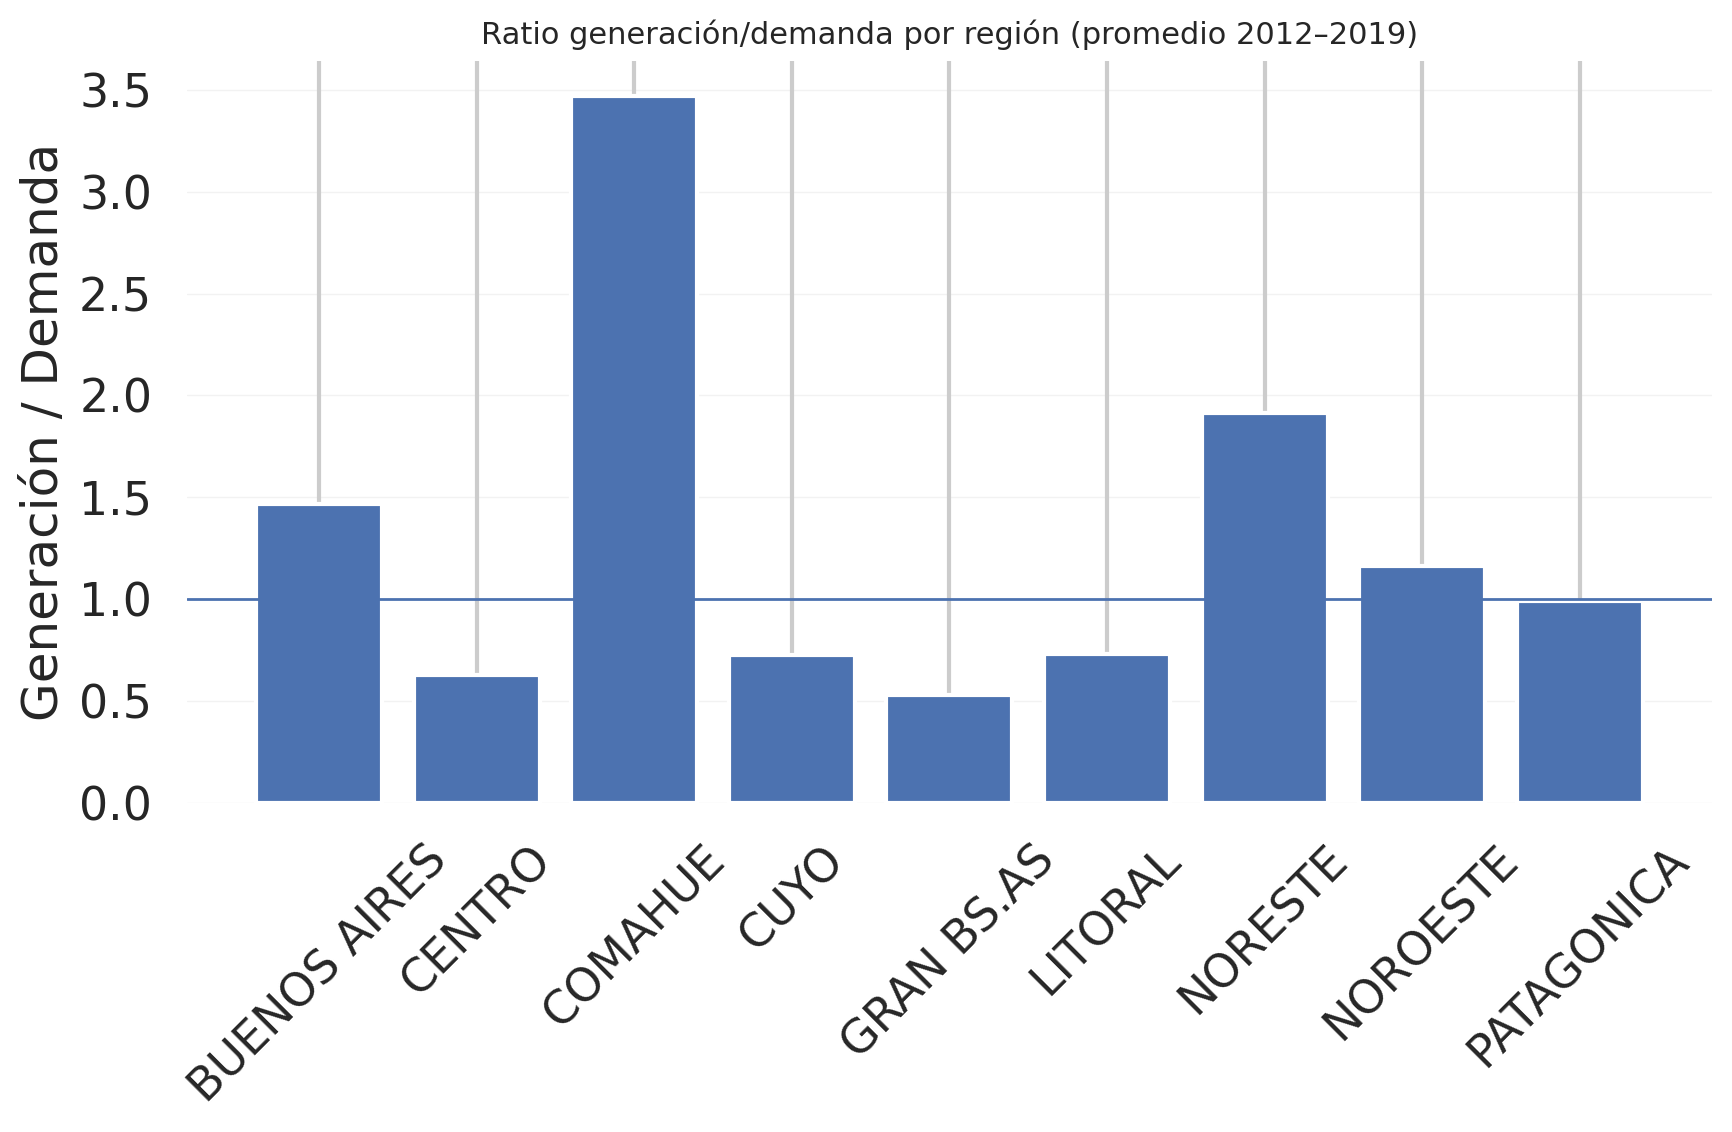

In [ ]:

df = df_ieer.copy()

# Ratio generación/demanda (si ya existe balance_ratio, lo usamos)
df["ratio_gd"] = df["balance_ratio"]  # o recalcular: df["generacion_total_MWh"]/df["demanda_total_MWh"]

# Promedio 2012–2019 por región
orden_regiones = [
    "BUENOS AIRES","CENTRO","COMAHUE","CUYO","GRAN BS.AS",
    "LITORAL","NORESTE","NOROESTE","PATAGONICA"
]

ratio_prom = (df.groupby("region")["ratio_gd"]
                .mean()
                .reindex([r for r in orden_regiones if r in df["region"].unique()]))

# --- Gráfico (académico) ---
fig, ax = plt.subplots(figsize=(9, 6), dpi=200)

ax.bar(ratio_prom.index, ratio_prom.values)

# Línea de referencia: equilibrio (=1)
ax.axhline(1, linewidth=1)

ax.set_ylabel("Generación / Demanda")
ax.set_title("Ratio generación/demanda por región (promedio 2012–2019)")

ax.tick_params(axis="x", rotation=45)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis="y", linestyle="-", linewidth=0.5, alpha=0.25)

plt.tight_layout()
plt.savefig("ratio_gen_dem_por_region.png", dpi=300, bbox_inches="tight")
plt.savefig("ratio_gen_dem_por_region.pdf", bbox_inches="tight")  # ideal para tesis
plt.show()

### 4.6 Exportables

In [ ]:
# Tabla para Anexo B.1
df_anexo_b1 = df_ieer.copy()
df_anexo_b1 = df_ieer[[
    "region",
    "anio",
    "coverage_norm",
    "stab_demanda_norm",
    "stab_generacion_norm",
    "IEER",
    "balance_ratio"  # si lo incluís
]]

#redondeo
df_anexo_b1 = df_anexo_b1.round(3)

df_anexo_b1.to_excel("Anexo_B1_IEER.xlsx", index=False)

In [ ]:
# Tabla para Anexo B.2
df_anexo_b2 = df_ieer.copy()
df_anexo_b2 = df_anexo_b2.round(3)
df_anexo_b2.to_excel("Anexo_B2_IEER.xlsx", index=False)

In [ ]:
sns.set(style="whitegrid")

## 5.Modelado: tipologías regionales mediante clustering (K-means)



### 5.1 Preparación del dataset multivariado


A partir del Índice de Equilibrio Eléctrico Regional (IEER) y sus componentes normalizados, se construyó un dataset multivariado con frecuencia anual y desagregado por región, que constituye la base para el análisis de agrupamientos y trayectorias temporales.

In [ ]:
# Dataset para clustering (72 filas: año–región)
df_cluster = df_ieer[['region', 'anio',
                      'coverage_norm',
                      'stab_demanda_norm', 'stab_generacion_norm']].copy()

df_cluster.shape  # (72, 6)

# Matriz numérica
X = df_cluster[['coverage_norm',
                'stab_demanda_norm', 'stab_generacion_norm']].values

In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   region                72 non-null     object 
 1   anio                  72 non-null     int64  
 2   coverage_norm         72 non-null     float64
 3   stab_demanda_norm     72 non-null     float64
 4   stab_generacion_norm  72 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


### 5.2 Estandarización de variables (z-score)

Dado que los indicadores presentan distintas distribuciones y varianzas, se aplicó una estandarización previa (media 0, desvío 1) para evitar que alguna variable domine el proceso de clustering.

In [ ]:
 #Estandarizar y calcular silhouette para varios k
# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

###5.3 Selección del número óptimo de clusters

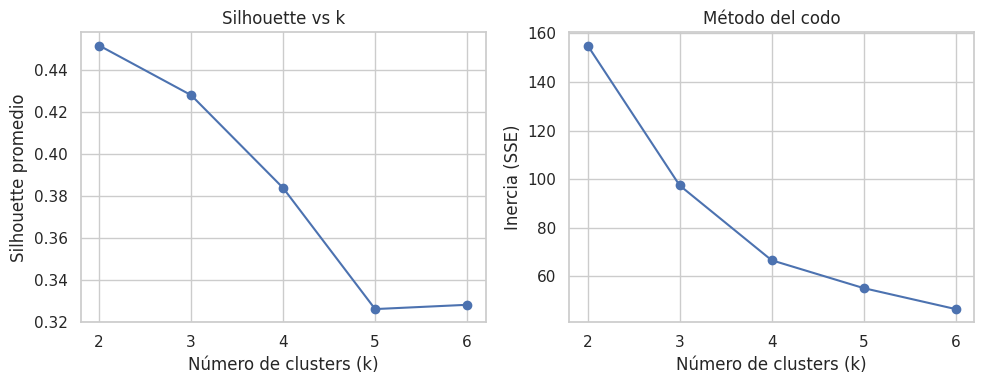

In [ ]:
Ks = range(2, 7)  # por ejemplo de 2 a 6 clusters
sil_scores = []
inertias = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
    labels = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    inertias.append(kmeans.inertia_)

# Gráfico de silhouette
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Ks, sil_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette promedio')
plt.title('Silhouette vs k')

# (opcional) gráfico de codo con la inercia
plt.subplot(1,2,2)
plt.plot(Ks, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del codo')
plt.tight_layout()
plt.show()

### 5.4 Ajuste del modelo K-means y asignación de cluster

Los clusters obtenidos representan tipologías regionales diferenciadas en términos de cobertura energética y estabilidad del sistema eléctrico, permitiendo clasificar a las regiones según su desempeño relativo.

In [ ]:
# Ajustar con k=3
kmeans = KMeans(n_clusters=3, random_state=0, n_init=20)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Tamaño de cada cluster
print(df_cluster['cluster'].value_counts())

# Perfil medio por cluster
print(
    df_cluster.groupby('cluster')[['coverage_norm',
                                    'stab_demanda_norm','stab_generacion_norm']].mean()
)

cluster
2    51
0    13
1     8
Name: count, dtype: int64
         coverage_norm  stab_demanda_norm  stab_generacion_norm
cluster                                                        
0                0.251              0.317                 0.805
1                0.730              0.874                 0.486
2                0.105              0.760                 0.589


In [ ]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   region                72 non-null     object 
 1   anio                  72 non-null     int64  
 2   coverage_norm         72 non-null     float64
 3   stab_demanda_norm     72 non-null     float64
 4   stab_generacion_norm  72 non-null     float64
 5   cluster               72 non-null     int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 3.2+ KB


### 5.5 Caracterización e interpreación de cluster(tipologías)

El análisis de pertenencia región–cluster muestra que algunas regiones mantienen una tipología estable a lo largo del período, mientras que otras presentan cambios, lo que sugiere dinámicas estructurales diferenciadas en el equilibrio eléctrico regional.

In [ ]:
df_cluster.groupby(['cluster', 'region']).size()

cluster  region      
0        GRAN BS.AS      2
         LITORAL         1
         NORESTE         8
         NOROESTE        1
         PATAGONICA      1
1        COMAHUE         8
2        BUENOS AIRES    8
         CENTRO          8
         CUYO            8
         GRAN BS.AS      6
         LITORAL         7
         NOROESTE        7
         PATAGONICA      7
dtype: int64

### 5.6 Trayectorias temporales y cluster predominante

Trayectorias temporales de las regiones. La matriz de trayectorias permite observar la evolución temporal de cada región dentro del espacio de clusters, identificando transiciones, persistencias y episodios de cambio estructural.

In [ ]:
#Para ver esas transiciones año a año (muy útil para las conclusiones)
trayectorias = df_cluster.pivot(index='anio', columns='region', values='cluster')
trayectorias

region  BUENOS AIRES  CENTRO  COMAHUE  CUYO  GRAN BS.AS  LITORAL  NORESTE  \
anio                                                                        
2012               2       2        1     2           2        2        0   
2013               2       2        1     2           2        2        0   
2014               2       2        1     2           2        2        0   
2015               2       2        1     2           2        2        0   
2016               2       2        1     2           0        0        0   
2017               2       2        1     2           2        2        0   
2018               2       2        1     2           0        2        0   
2019               2       2        1     2           2        2        0   

region  NOROESTE  PATAGONICA  
anio                          
2012           2           0  
2013           2           2  
2014           2           2  
2015           2           2  
2016           0           2  
2017           2           2  
2018           2           2  
2019           2           2

Cluster predominante

In [ ]:
# % por región y clúster dominante
df_pct = (
    df_cluster
    .groupby(['region', 'cluster'])
    .size()
    .reset_index(name='n')
)

df_pct['pct'] = df_pct.groupby('region')['n'].transform(lambda x: 100*x/x.sum())

# Tabla pivot (una columna por clúster)
df_pct_pivot = (
    df_pct
    .pivot(index='region', columns='cluster', values='pct')
    .fillna(0)
    .reset_index()
)

# Clúster dominante
df_dom = (
    df_cluster
    .groupby('region')['cluster']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name='cluster_dominante')
)

df_pct_pivot = df_pct_pivot.merge(df_dom, on='region', how='left')
df_pct_pivot

region       0       1       2  cluster_dominante
0  BUENOS AIRES   0.000   0.000 100.000                  2
1        CENTRO   0.000   0.000 100.000                  2
2       COMAHUE   0.000 100.000   0.000                  1
3          CUYO   0.000   0.000 100.000                  2
4    GRAN BS.AS  25.000   0.000  75.000                  2
5       LITORAL  12.500   0.000  87.500                  2
6       NORESTE 100.000   0.000   0.000                  0
7      NOROESTE  12.500   0.000  87.500                  2
8    PATAGONICA  12.500   0.000  87.500                  2

In [ ]:
# Mapa cluster -> tipología (según los centroides)
tip_map = {
    0: "Inestabilidad de la demanda",
    1: "Equilibrio relativo",
    2: "Déficit estructural"   # o "Déficit persistente"
}

# 1) Renombrar columnas de porcentaje (0/1/2 -> tipologías)
df_pct_pivot = df_pct_pivot.rename(columns=tip_map)

# 2) Agregar tipología dominante
df_pct_pivot["tipologia_dominante"] = df_pct_pivot["cluster_dominante"].map(tip_map)

# (Opcional) ordenar columnas prolijo
orden_cols = [
    "region",
    "Equilibrio relativo",
    "Déficit estructural",
    "Inestabilidad de la demanda",
    "cluster_dominante",
    "tipologia_dominante"
]
# si usás "Déficit persistente", cambiá ese string en la lista
df_pct_pivot = df_pct_pivot[orden_cols]

df_pct_pivot


region  Equilibrio relativo  Déficit estructural  \
0  BUENOS AIRES                0.000              100.000   
1        CENTRO                0.000              100.000   
2       COMAHUE              100.000                0.000   
3          CUYO                0.000              100.000   
4    GRAN BS.AS                0.000               75.000   
5       LITORAL                0.000               87.500   
6       NORESTE                0.000                0.000   
7      NOROESTE                0.000               87.500   
8    PATAGONICA                0.000               87.500   

   Inestabilidad de la demanda  cluster_dominante          tipologia_dominante  
0                        0.000                  2          Déficit estructural  
1                        0.000                  2          Déficit estructural  
2                        0.000                  1          Equilibrio relativo  
3                        0.000                  2          Déficit estructural  
4                       25.000                  2          Déficit estructural  
5                       12.500                  2          Déficit estructural  
6                      100.000                  0  Inestabilidad de la demanda  
7                       12.500                  2          Déficit estructural  
8                       12.500                  2          Déficit estructural

In [ ]:
df_tabla_tesis = df_pct_pivot.drop(columns=["cluster_dominante"])
df_tabla_tesis


region  Equilibrio relativo  Déficit estructural  \
0  BUENOS AIRES                0.000              100.000   
1        CENTRO                0.000              100.000   
2       COMAHUE              100.000                0.000   
3          CUYO                0.000              100.000   
4    GRAN BS.AS                0.000               75.000   
5       LITORAL                0.000               87.500   
6       NORESTE                0.000                0.000   
7      NOROESTE                0.000               87.500   
8    PATAGONICA                0.000               87.500   

   Inestabilidad de la demanda          tipologia_dominante  
0                        0.000          Déficit estructural  
1                        0.000          Déficit estructural  
2                        0.000          Equilibrio relativo  
3                        0.000          Déficit estructural  
4                       25.000          Déficit estructural  
5                       12.500          Déficit estructural  
6                      100.000  Inestabilidad de la demanda  
7                       12.500          Déficit estructural  
8                       12.500          Déficit estructural

In [ ]:
# 1) Frecuencias región–cluster (muestra cuántos años de cada región caen en cada cluster)
tabla_reg_cluster = pd.crosstab(df_cluster['region'], df_cluster['cluster'])
print("Frecuencias región–cluster:")
display(tabla_reg_cluster)

# 2) Proporciones por región (en %)
tabla_prop = tabla_reg_cluster.div(tabla_reg_cluster.sum(axis=1), axis=0) * 100
tabla_prop = tabla_prop.round(1)  # redondeo a 1 decimal
print("Proporciones región–cluster (%):")
display(tabla_prop)

# 3) Cluster predominante por región
cluster_dominante = (
    df_cluster.groupby('region')['cluster']
              .agg(lambda x: x.value_counts().idxmax())
)
print("Cluster predominante por región:")
display(cluster_dominante)

Frecuencias región–cluster:


cluster       0  1  2
region               
BUENOS AIRES  0  0  8
CENTRO        0  0  8
COMAHUE       0  8  0
CUYO          0  0  8
GRAN BS.AS    2  0  6
LITORAL       1  0  7
NORESTE       8  0  0
NOROESTE      1  0  7
PATAGONICA    1  0  7

Proporciones región–cluster (%):


cluster            0       1       2
region                              
BUENOS AIRES   0.000   0.000 100.000
CENTRO         0.000   0.000 100.000
COMAHUE        0.000 100.000   0.000
CUYO           0.000   0.000 100.000
GRAN BS.AS    25.000   0.000  75.000
LITORAL       12.500   0.000  87.500
NORESTE      100.000   0.000   0.000
NOROESTE      12.500   0.000  87.500
PATAGONICA    12.500   0.000  87.500

Cluster predominante por región:


region
BUENOS AIRES    2
CENTRO          2
COMAHUE         1
CUYO            2
GRAN BS.AS      2
LITORAL         2
NORESTE         0
NOROESTE        2
PATAGONICA      2
Name: cluster, dtype: int32

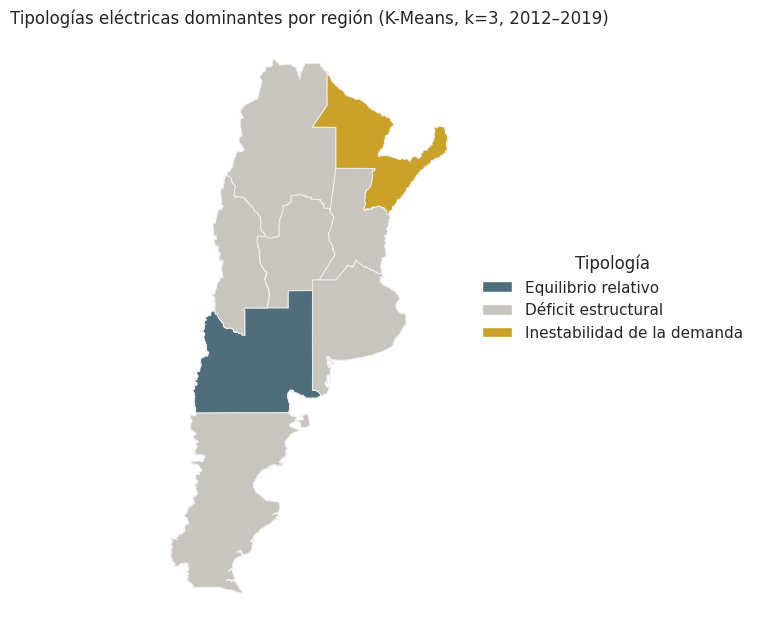

In [ ]:
# =====================================================
# 1) Construir geometría regional
# =====================================================

gdf_regiones = build_gdf_regiones(
    path_shape_provincias=PATH_SHAPE_PROVINCIAS,
    mapeo_regiones=MAPEO_REGIONES,
    excluir_tdf=True
)

# =====================================================
# 2) Cluster dominante por región
# =====================================================

cluster_dom = (
    df_cluster.groupby("region")["cluster"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
    .rename(columns={"cluster": "cluster_dom"})
)

# =====================================================
# 3) Mapear códigos a nombres
# =====================================================

labels = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

cluster_dom["tipologia"] = cluster_dom["cluster_dom"].map(labels)

# Configuración visual modular
orden, colores, cmap_tipologias, handles = configurar_tipologias()

cluster_dom["tipologia"] = (
    cluster_dom["tipologia"]
    .astype("category")
    .cat.set_categories(orden, ordered=True)
)

# =====================================================
# 4) Mapa
# =====================================================

gdf_mapa = plot_mapa_regional(
    gdf_regiones=gdf_regiones,
    df_valores_region=cluster_dom[["region", "tipologia"]],
    col_value="tipologia",
    titulo="Tipologías eléctricas dominantes por región (K-Means, k=3, 2012–2019)",
    cmap=cmap_tipologias,
    legend=False,
    figsize=(6, 8),
    edgecolor="#F0F0F0",
    linewidth=0.7,
    excluir_regiones=REGIONES_SIN_GEOMETRIA
)


# =====================================================
# 5) Leyenda
# =====================================================

plt.gca().legend(
    handles=handles,
    title="Tipología",
    loc="center left",
    #bbox_to_anchor=(1.02, 0.5),
    bbox_to_anchor=(1.02, 0.55),
    frameon=False
)

#plt.tight_layout()
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


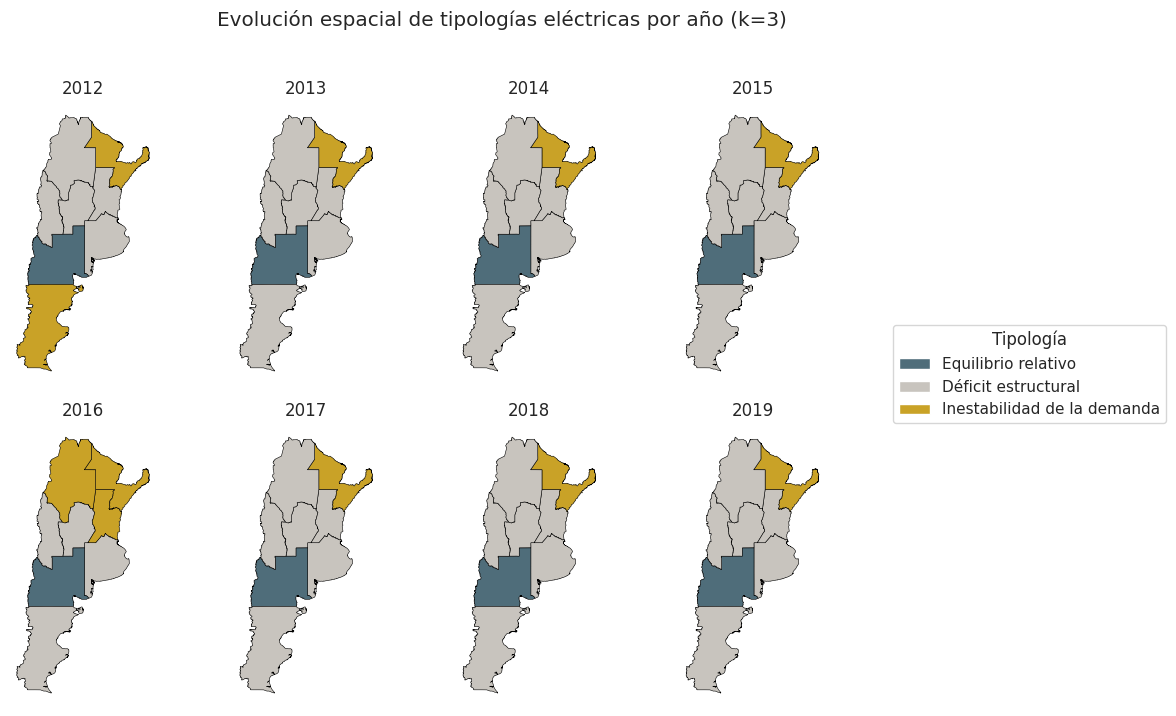

In [ ]:
# ============================================
# Evolución espacial por año (usando función)
# ============================================

anios = sorted(df_cluster["anio"].unique())

# Reutilizamos labels y orden
labels = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

orden = [
    "Equilibrio relativo",
    "Déficit estructural",
    "Inestabilidad de la demanda"
]

# Reutilizamos la configuración modular de colores
orden, colores, cmap_tipologias, handles = configurar_tipologias()

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for i, anio in enumerate(anios):

    df_y = df_cluster[df_cluster["anio"] == anio][["region", "cluster"]].copy()
    df_y["tipologia"] = df_y["cluster"].map(labels)

    df_y["tipologia"] = (
        df_y["tipologia"]
        .astype("category")
        .cat.set_categories(orden, ordered=True)
    )

    plot_mapa_regional(
        gdf_regiones=gdf_regiones,
        df_valores_region=df_y[["region", "tipologia"]],
        col_value="tipologia",
        titulo=str(anio),
        cmap=cmap_tipologias,
        legend=False,
        edgecolor="black",
        linewidth=0.4,
        ax=axes[i],
        excluir_regiones=REGIONES_SIN_GEOMETRIA
    )

# ============================================
# Leyenda única para toda la figura
# ============================================


fig.legend(
    handles=handles,  # <--- reutilizamos los mismos handles
    title="Tipología",
    loc="center right",
    bbox_to_anchor=(0.98, 0.5),
    frameon=True
)

fig.suptitle(
    "Evolución espacial de tipologías eléctricas por año (k=3)",
    y=1.02
)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


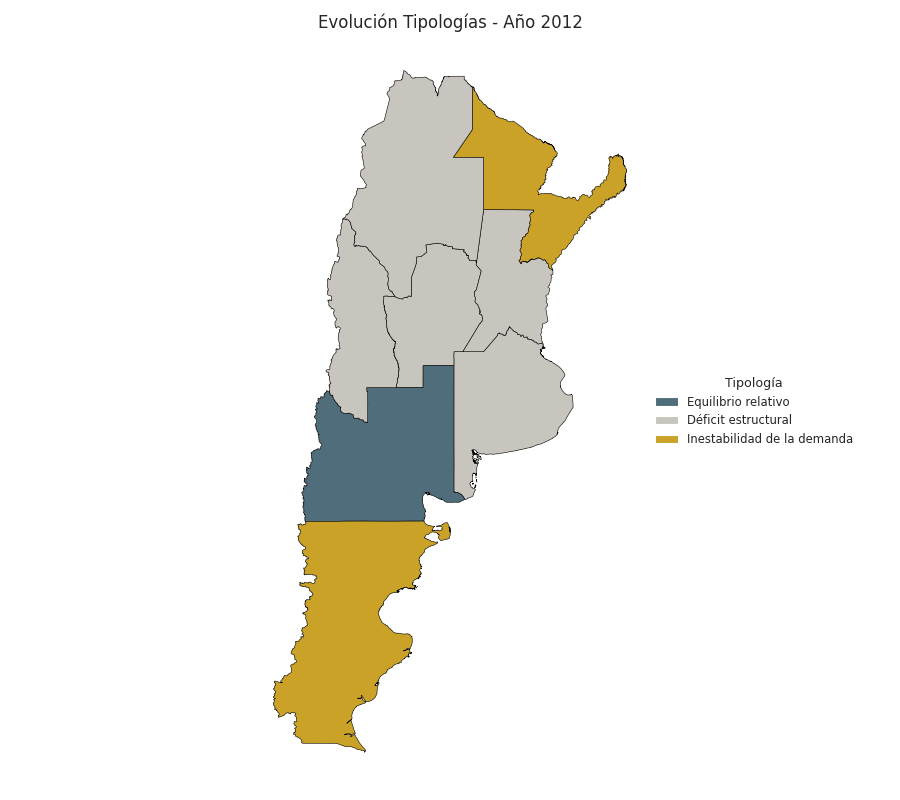

In [ ]:
# ============================================
# Preparación de datos y colores
# ============================================

anios = sorted(df_cluster["anio"].unique())

labels = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

orden, colores, cmap_tipologias, handles = configurar_tipologias()

# Regiones sin geometría oficial
REGIONES_SIN_GEOMETRIA = ["GRAN BS.AS"]

# ============================================
# Crear figura
# ============================================

fig, ax = plt.subplots(figsize=(9, 8))

# ============================================
# Función para actualizar cada frame
# ============================================

def update(i):
    ax.clear()
    anio = anios[i]

    df_y = df_cluster[df_cluster["anio"] == anio][["region", "cluster"]].copy()
    df_y["tipologia"] = df_y["cluster"].map(labels)
    df_y["tipologia"] = (
        df_y["tipologia"]
        .astype("category")
        .cat.set_categories(orden, ordered=True)
    )

    plot_mapa_regional(
        gdf_regiones=gdf_regiones,
        df_valores_region=df_y[["region", "tipologia"]],
        col_value="tipologia",
        titulo=f"Evolución Tipologías - Año {anio}",
        cmap=cmap_tipologias,
        legend=False,
        edgecolor="black",
        linewidth=0.4,
        ax=ax,
        excluir_regiones=REGIONES_SIN_GEOMETRIA
    )

    ax.legend(
        handles=handles,
        title="Tipología",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=False
    )

# ============================================
# Crear animación
# ============================================
plt.tight_layout()
anim = FuncAnimation(fig, update, frames=len(anios), interval=1000)

# ============================================
# Guardar animación como GIF
# ============================================

gif_path = "evolucion_tipologias.gif"
writer = PillowWriter(fps=1)
anim.save(gif_path, writer=writer)

plt.close(fig)
Image(filename=gif_path)

### 5.7 Visualización multivariada

In [ ]:
df_plot = df_ieer.merge(
    df_cluster[['region', 'anio', 'cluster']],
    on=['region', 'anio'],
    how='left'
)

In [ ]:
# Tabla de centroides
centroides = (
    df_cluster
    .groupby("cluster")[[
        "coverage_norm",
        "stab_demanda_norm",
        "stab_generacion_norm"
    ]]
    .mean()
)

centroides

coverage_norm  stab_demanda_norm  stab_generacion_norm
cluster                                                        
0                0.251              0.317                 0.805
1                0.730              0.874                 0.486
2                0.105              0.760                 0.589

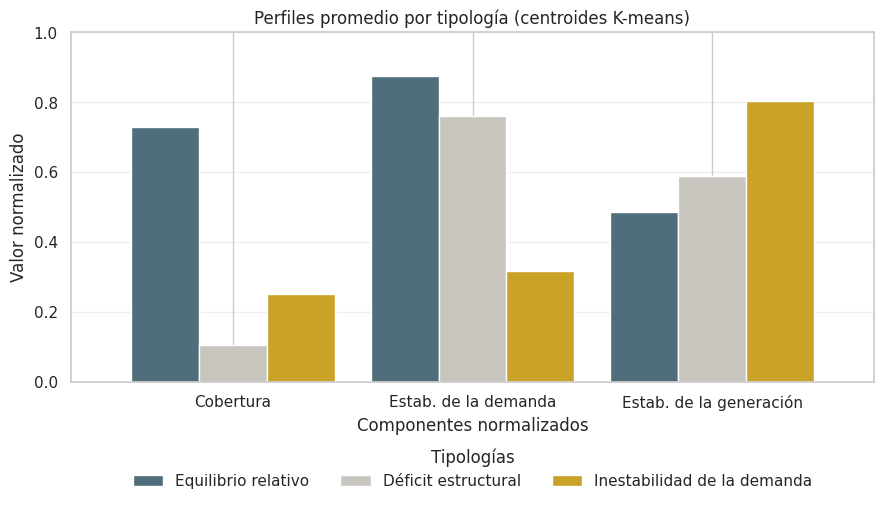

In [ ]:
labels = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

# --- Reusar colores/orden del mapa ---
orden, colores, cmap_tipologias, handles = configurar_tipologias()

# colores puede venir como dict o lista, lo dejamos robusto
if isinstance(colores, dict):
    color_map = colores
else:
    color_map = {orden[i]: colores[i] for i in range(len(orden))}

# --- Asegurar centroides con índice = cluster ---
# Si centroides tiene columna "cluster", descomentá:
# centroides = centroides.set_index("cluster")

cent_plot = centroides.copy()

# Renombrar clusters a tipologías (y reordenar)
cent_plot.index = cent_plot.index.map(labels)
cent_plot = cent_plot.reindex(orden)

# Renombrar columnas con títulos “lindos” (usa tu lab() / LABELS_TESIS)
cent_plot = cent_plot.rename(columns=lambda c: lab(c))

# --- Plot: componentes en X, tipologías como series (colores consistentes) ---
ax = cent_plot.T.plot(
    kind="bar",
    figsize=(9, 5),
    color=[color_map[name] for name in cent_plot.index],
    width=0.85
)
ax.set_xticks(range(len(ax.get_xticklabels())))  # asegura ticks en el centro de cada grupo
ax.set_xticklabels(["Cobertura", "Estab. de la demanda", "Estab. de la generación"],
                   rotation=0, ha="center")

plt.title("Perfiles promedio por tipología (centroides K-means)")
plt.xlabel("Componentes normalizados")
plt.ylabel("Valor normalizado")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

# Leyenda abajo (más legible)
plt.legend(
    title="Tipologías",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)  # espacio extra para la leyenda
plt.show()

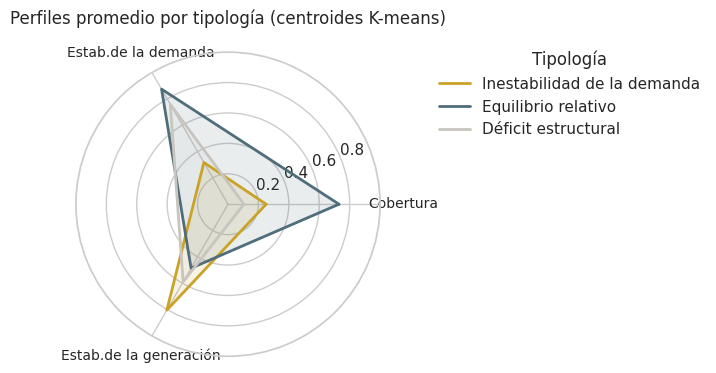

In [ ]:

labels_cluster = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

# Reusar colores consistentes (los mismos del gráfico anterior/mapas)
orden, colores, cmap_tipologias, handles = configurar_tipologias()

# colores puede venir como dict o lista -> lo convertimos a dict tipologia->color
if isinstance(colores, dict):
    color_map = colores
else:
    color_map = {orden[i]: colores[i] for i in range(len(orden))}

# Variables (componentes)
vars_radar = centroides.columns.tolist()
num_vars = len(vars_radar)

# Ángulos
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Figura
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

# Dibujar cada clúster con color de su tipología
for cluster in centroides.index:
    values = centroides.loc[cluster].values.tolist()
    values += values[:1]

    tipologia = labels_cluster.get(cluster, f"Clúster {cluster}")
    color = color_map.get(tipologia, None)  # si no encuentra, matplotlib elige

    ax.plot(angles, values, linewidth=2, label=tipologia, color=color)
    ax.fill(angles, values, alpha=0.12, color=color)

# Etiquetas en español (usa tu lab())
ax.set_xticks(angles[:-1])
ax.set_xticklabels([lab(v) for v in vars_radar], fontsize=10)

# Escala radial
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_ylim(0, 1)

plt.title("Perfiles promedio por tipología (centroides K-means)", pad=20)

plt.legend(
    title="Tipología",
    loc="upper left",
    bbox_to_anchor=(1.15, 1.05),
    frameon=False
)

plt.tight_layout()
plt.show()

In [ ]:
labels_cluster = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

orden, colores, cmap_tipologias, handles = configurar_tipologias()
color_map = colores if isinstance(colores, dict) else {orden[i]: colores[i] for i in range(len(orden))}

def scatter_con_centroides(df_cluster, centroides, yvar, titulo,
                           xvar="coverage_norm",
                           xlab="Cobertura (normalizada)",
                           ylab=None):
    if ylab is None:
        ylab = yvar

    plt.figure(figsize=(7, 5))

    # Observaciones por tipología
    for cl in sorted(df_cluster["cluster"].unique()):
        tip = labels_cluster.get(cl, f"Clúster {cl}")
        sub = df_cluster[df_cluster["cluster"] == cl]
        plt.scatter(sub[xvar], sub[yvar], s=35, alpha=0.55, color=color_map.get(tip), label=tip)

    # Centroides + etiquetas
    for cl in centroides.index:
        tip = labels_cluster.get(cl, f"Clúster {cl}")
        x0 = centroides.loc[cl, xvar]
        y0 = centroides.loc[cl, yvar]

        plt.scatter(x0, y0, s=220, marker="X",
                    color=color_map.get(tip, "black"),
                    edgecolor="black", linewidth=1.2, zorder=5)

        plt.annotate(tip, (x0, y0), textcoords="offset points",
                     xytext=(8, 6), fontsize=9, weight="bold")

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(titulo)

    legend_tipologias = [
        Line2D([0], [0], marker="o", color="w", label=tip,
               markerfacecolor=color_map[tip], markersize=8, alpha=0.8)
        for tip in orden
    ]
    legend_centroides = Line2D([0], [0], marker="X", color="black", label="Centroides",
                               linestyle="None", markersize=10)

    plt.legend(handles=legend_tipologias + [legend_centroides],
               title="Tipología", loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False)

    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

A) Cobertura vs Estabilidad de demanda

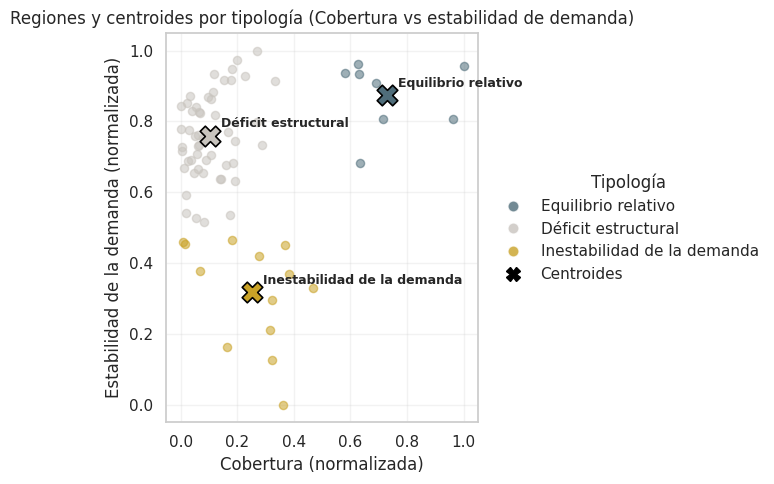

In [ ]:
scatter_con_centroides(
    df_cluster=df_cluster,
    centroides=centroides,
    yvar="stab_demanda_norm",
    titulo="Regiones y centroides por tipología (Cobertura vs estabilidad de demanda)",
    ylab="Estabilidad de la demanda (normalizada)"

)

B) Cobertura vs Estabilidad de generación

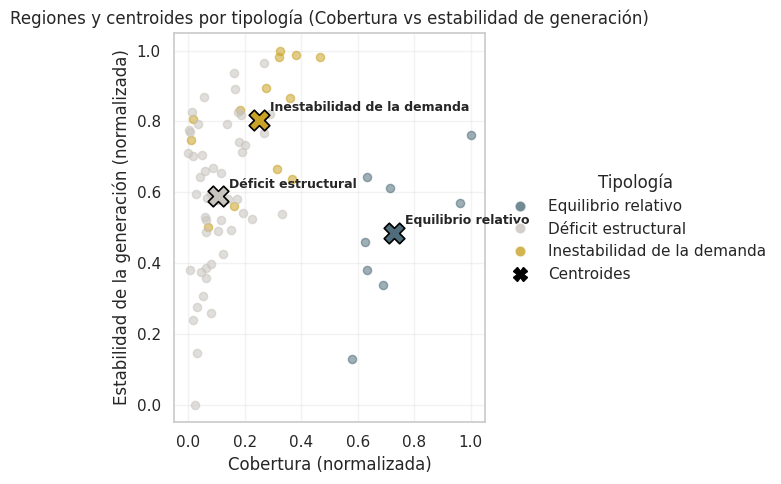

In [ ]:
scatter_con_centroides(
    df_cluster=df_cluster,
    centroides=centroides,
    yvar="stab_generacion_norm",
    titulo="Regiones y centroides por tipología (Cobertura vs estabilidad de generación)",
    ylab="Estabilidad de la generación (normalizada)"

)

En ambos gráficos, cada punto representa una observación región–año (2012–2019) ubicada según la cobertura (eje X) y una medida de estabilidad (eje Y). Los colores indican la tipología asignada por K-means, mientras que las X marcan los centroides, es decir, el perfil promedio de cada grupo.

En el plano cobertura–estabilidad de la demanda, se observa que el clúster de equilibrio relativo se concentra en valores altos de cobertura y alta estabilidad, el déficit estructural agrupa observaciones con baja cobertura pero demanda relativamente estable, y la inestabilidad de la demanda aparece asociada a menores niveles de estabilidad, con cobertura baja a media.

En el plano cobertura–estabilidad de la generación, la separación muestra que el equilibrio relativo combina alta cobertura con estabilidad de generación intermedia, el déficit estructural mantiene baja cobertura con estabilidad de generación moderada, y la tipología asociada a inestabilidad se desplaza hacia valores altos de variabilidad del sistema en esta dimensión. En conjunto, ambos gráficos confirman que las tipologías resultan de combinaciones consistentes entre cobertura y estabilidad, y que los centroides sintetizan esas diferencias estructurales entre regiones.

In [ ]:

# 1) Armar tabla anexo (ordenada + con tipología)
tip_map = {
    0: "Inestabilidad de la demanda",
    1: "Equilibrio relativo",
    2: "Déficit estructural"
}

df_anexo = df_cluster.copy()
df_anexo["tipologia"] = df_anexo["cluster"].map(tip_map)

cols = [
    "region", "anio", "cluster", "tipologia",
    "coverage_norm", "stab_demanda_norm", "stab_generacion_norm"
]
df_anexo = df_anexo[cols].sort_values(["region", "anio"])

# Redondeo prolijo
for c in ["coverage_norm", "stab_demanda_norm", "stab_generacion_norm"]:
    df_anexo[c] = df_anexo[c].round(3)

# 2) Exportar a Excel
out_xlsx = "Anexo_C1_observaciones_cluster.xlsx"
df_anexo.to_excel(out_xlsx, index=False)

# ============================================================
# 3) Formateo Excel (openpyxl)
# ============================================================

wb = load_workbook(out_xlsx)
ws = wb.active
ws.title = "C1_cluster"

# Congelar cabecera
ws.freeze_panes = "A2"

# Estilo cabecera
header_fill = PatternFill("solid", fgColor="1F4E79")
header_font = Font(color="FFFFFF", bold=True)
header_alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

for cell in ws[1]:
    cell.fill = header_fill
    cell.font = header_font
    cell.alignment = header_alignment

ws.row_dimensions[1].height = 22

# Formato numérico por nombre de columna (robusto)
headers = [c.value for c in ws[1]]
header_to_col = {h: i+1 for i, h in enumerate(headers) if h is not None}

cols_3dec = {"coverage_norm", "stab_demanda_norm", "stab_generacion_norm"}
for col_name in cols_3dec:
    if col_name in header_to_col:
        col_idx = header_to_col[col_name]
        for row in ws.iter_rows(min_row=2, min_col=col_idx, max_col=col_idx):
            row[0].number_format = "0.000"

# Auto-ajuste ancho de columnas (seguro)
for col_idx in range(1, ws.max_column + 1):
    max_len = 0
    col_letter = ws.cell(row=1, column=col_idx).column_letter
    for row_idx in range(1, ws.max_row + 1):
        v = ws.cell(row=row_idx, column=col_idx).value
        if v is None:
            continue
        max_len = max(max_len, len(str(v)))
    ws.column_dimensions[col_letter].width = max(10, min(max_len + 2, 28))

# Convertir a tabla con estilo (zebra)
ref = f"A1:{ws.cell(row=ws.max_row, column=ws.max_column).coordinate}"
base_name = "TablaClusterC1"
existing_names = {t.displayName for t in ws._tables}
table_name = base_name
k = 1
while table_name in existing_names:
    k += 1
    table_name = f"{base_name}_{k}"

tab = Table(displayName=table_name, ref=ref)
tab.tableStyleInfo = TableStyleInfo(
    name="TableStyleMedium9",
    showRowStripes=True,
    showColumnStripes=False
)
ws.add_table(tab)

wb.save(out_xlsx)

out_xlsx

'Anexo_C1_observaciones_cluster.xlsx'

/tmp/ipython-input-611475563.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfp.groupby("tipologia", as_index=False)


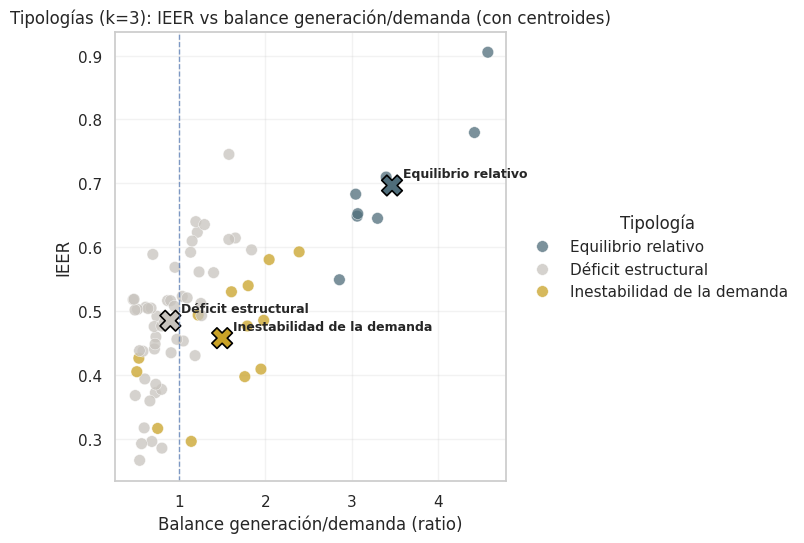

In [ ]:
# Tipologías (igual que mapas)
labels_cluster = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

# Colores consistentes (mapas / centroides)
orden, colores, cmap_tipologias, handles = configurar_tipologias()
color_map = colores if isinstance(colores, dict) else {orden[i]: colores[i] for i in range(len(orden))}

# Dataset para plot
dfp = df_plot.copy()
dfp["tipologia"] = dfp["cluster"].map(labels_cluster)
dfp["tipologia"] = (
    dfp["tipologia"].astype("category")
    .cat.set_categories(orden, ordered=True)
)

# Centroides en este plano (promedio por tipología)
cent_plano = (
    dfp.groupby("tipologia", as_index=False)
       .agg(
           balance_ratio=("balance_ratio", "mean"),
           IEER=("IEER", "mean")
       )
)

plt.figure(figsize=(7.8, 5.6))

# Puntos (observaciones)
sns.scatterplot(
    data=dfp,
    x="balance_ratio",
    y="IEER",
    hue="tipologia",
    palette=color_map,
    s=70,
    alpha=0.75,
    edgecolor="white",
    linewidth=0.4
)

# Línea referencia: generación ≈ demanda
plt.axvline(1, linestyle="--", linewidth=1, alpha=0.7)

# Centroides (X)
sns.scatterplot(
    data=cent_plano,
    x="balance_ratio",
    y="IEER",
    hue="tipologia",
    palette=color_map,
    marker="X",
    s=220,
    edgecolor="black",
    linewidth=1.2,
    legend=False
)

# Etiquetas de centroides
for _, r in cent_plano.iterrows():
    plt.annotate(
        r["tipologia"],
        (r["balance_ratio"], r["IEER"]),
        textcoords="offset points",
        xytext=(8, 6),
        fontsize=9,
        weight="bold"
    )

plt.title("Tipologías (k=3): IEER vs balance generación/demanda (con centroides)")
plt.xlabel("Balance generación/demanda (ratio)")
plt.ylabel("IEER")

plt.legend(
    title="Tipología",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

In [ ]:
# Paleta oficial
palette = {
    "Equilibrio relativo": "#4F6D7A",           # azul petróleo
    "Déficit estructural": "#C8C4BE",           # gris claro
    "Inestabilidad de la demanda": "#C9A227"    # amarillo mostaza
}

hue_order = ["Equilibrio relativo", "Déficit estructural", "Inestabilidad de la demanda"]

cluster_to_tip = {
    0: "Inestabilidad de la demanda",
    1: "Equilibrio relativo",
    2: "Déficit estructural"
}

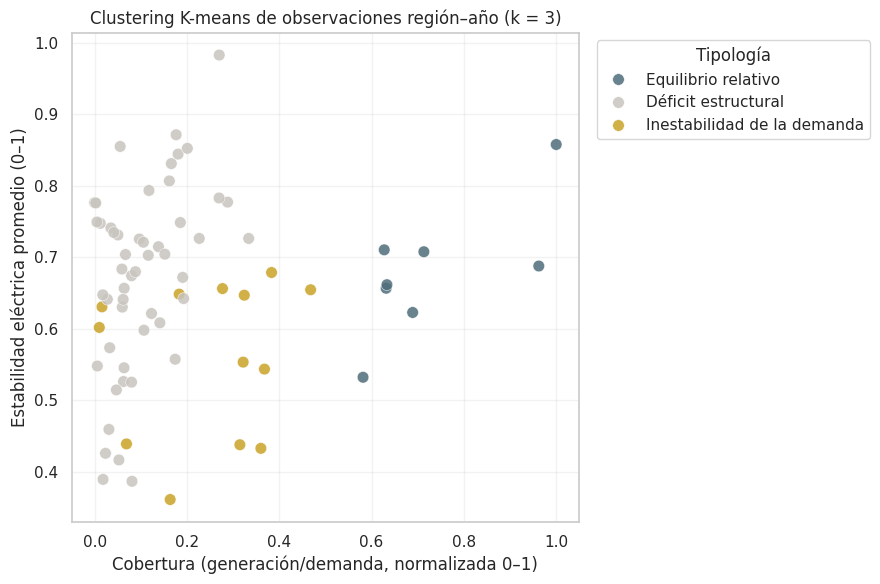

In [ ]:

cols = ["coverage_norm", "stab_demanda_norm", "stab_generacion_norm", "cluster"]
df_plot = df_cluster[cols].dropna().copy()

# Estabilidad eléctrica promedio
df_plot["estabilidad_prom"] = df_plot[["stab_demanda_norm", "stab_generacion_norm"]].mean(axis=1)

# Tipologías (para no mostrar 0/1/2)
df_plot["tipologia"] = df_plot["cluster"].map(cluster_to_tip)

plt.figure(figsize=(9, 6))

ax = sns.scatterplot(
    data=df_plot,
    x="coverage_norm",
    y="estabilidad_prom",
    hue="tipologia",
    hue_order=hue_order,
    palette=palette,
    s=70,
    alpha=0.85,
    edgecolor="white",
    linewidth=0.4
)

ax.set_title("Clustering K-means de observaciones región–año (k = 3)")
ax.set_xlabel("Cobertura (generación/demanda, normalizada 0–1)")
ax.set_ylabel("Estabilidad eléctrica promedio (0–1)")
ax.grid(True, alpha=0.25)

# Leyenda prolija
ax.legend(
    title="Tipología",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=True
)

plt.tight_layout()
plt.savefig("grafico_15_scatter_tipologias.png", dpi=300, bbox_inches="tight")
plt.savefig("grafico_15_scatter_tipologias.pdf", bbox_inches="tight")
plt.show()

##6.Dimensión demográfica

Este bloque integra población regional al análisis del IEER y a las tipologías (K-Means, k=3).

**Nota:** Se excluye *Tierra del Fuego* por no formar parte del SADI analizado (CAMMESA).

Se construyó una tabla de correspondencia entre jurisdicciones provinciales y regiones energéticas, permitiendo integrar información demográfica al análisis eléctrico regional.

### 6.1 Exploración y preparación de los datos poblacionales



In [ ]:
df_poblacion_raw.head()
df_poblacion_raw['Jurisdiccion'].unique()

array(['Gran Bs.As', 'Buenos Aires', 'Catamarca', 'Chaco', 'Chubut',
       'Córdoba', 'Corrientes', 'Entre Ríos', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén',
       'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz',
       'Santa Fe', 'Santiago del Estero',
       'Tierra del Fuego, Antártida e Islas del Atlántico Sur (1)',
       'Tucumán'], dtype=object)

In [ ]:
# Mapeo jurisdicción → región energética
df_regiones = (
    pd.Series(MAPEO_REGIONES, name="region")
      .rename_axis("Jurisdiccion")
      .reset_index()
)

display(df_regiones)

Jurisdiccion        region
0            Gran Bs.As    GRAN BS.AS
1          Buenos Aires  BUENOS AIRES
2               Córdoba        CENTRO
3              San Luis        CENTRO
4               Mendoza          CUYO
5              San Juan          CUYO
6              Santa Fe       LITORAL
7            Entre Ríos       LITORAL
8                 Chaco       NORESTE
9            Corrientes       NORESTE
10              Formosa       NORESTE
11             Misiones       NORESTE
12            Catamarca      NOROESTE
13                Jujuy      NOROESTE
14             La Rioja      NOROESTE
15                Salta      NOROESTE
16  Santiago del Estero      NOROESTE
17              Tucumán      NOROESTE
18              Neuquén       COMAHUE
19            Río Negro       COMAHUE
20             La Pampa       COMAHUE
21               Chubut    PATAGONICA
22           Santa Cruz    PATAGONICA

### 6.2 Agregacion censal por región (2010 y 2022)

In [ ]:
# Unir población (jurisdicción) con región
df_poblacion = df_poblacion_raw.copy()
df_poblacion["Jurisdiccion"] = df_poblacion["Jurisdiccion"].astype(str).str.strip()

df_pob_con_region = (
    df_poblacion
    .merge(df_regiones, on="Jurisdiccion", how="left")
    .dropna(subset=["region"])  # excluye jurisdicciones no consideradas (Tierra del Fuego)
)

# Agregar población 2010 y 2022 por región
df_pob_reg = (
    df_pob_con_region
    .groupby("region", as_index=False)[["Poblacion_2010", "Poblacion_2022"]]
    .sum()
)

display(df_pob_reg)

region  Poblacion_2010  Poblacion_2022
0  BUENOS AIRES         5708369         6674697
1        CENTRO         3741186         4382974
2       COMAHUE         1508862         1823441
3          CUYO         2419984         2866393
4    GRAN BS.AS        12806866        13971006
5       LITORAL         4430531         4970486
6       NORESTE         3679609         4228594
7      NOROESTE         4911412         5859115
8    PATAGONICA          783072          929847

### 6.3 Estimación anual de población (2012–2019)

 Nota metodológica:
La población anual se estimó mediante interpolación lineal entre los censos nacionales 2010 y 2022 (INDEC).

Dado que la población se utiliza como variable estructural de ponderación y no como objeto central de análisis, este método prioriza transparencia y comparabilidad temporal

In [ ]:
anios = list(range(ANIO_INICIO, ANIO_FIN + 1))

anio_a, anio_b = 2010, 2022
n_anios = anio_b - anio_a

registros = []

for _, row in df_pob_reg.iterrows():
    delta_anual = (row["Poblacion_2022"] - row["Poblacion_2010"]) / n_anios

    for anio in anios:
        poblacion_est = row["Poblacion_2010"] + delta_anual * (anio - anio_a)
        registros.append({
            "region": row["region"],
            "anio": anio,
            "poblacion_estimada": int(round(poblacion_est))
        })

df_pob_reg_anual = pd.DataFrame(registros)
validar_dataset(df_pob_reg_anual, "Población anual estimada (2012–2019)", ["region","anio"])
display(df_pob_reg_anual.head())

#  chequeo rápido
print("Regiones con población estimada:", sorted(df_pob_reg_anual["region"].unique()))




🔍 Validando: Población anual estimada (2012–2019)
📊 Filas: 72  |  Columnas: 3
➡️ Duplicados en ['region', 'anio']: 0

✅ No se detectaron valores nulos.


region  anio  poblacion_estimada
0  BUENOS AIRES  2012             5869424
1  BUENOS AIRES  2013             5949951
2  BUENOS AIRES  2014             6030478
3  BUENOS AIRES  2015             6111006
4  BUENOS AIRES  2016             6191533

Regiones con población estimada: ['BUENOS AIRES', 'CENTRO', 'COMAHUE', 'CUYO', 'GRAN BS.AS', 'LITORAL', 'NORESTE', 'NOROESTE', 'PATAGONICA']


### 6.4 Integración población – IEER – clusters

In [ ]:
df_ieer_pob = df_ieer.merge(
    df_pob_reg_anual,
    on=["region", "anio"],
    how="left"
)

validar_dataset(df_ieer_pob, "IEER + población", ["region","anio"])
display(df_ieer_pob.head())


🔍 Validando: IEER + población
📊 Filas: 72  |  Columnas: 23
➡️ Duplicados en ['region', 'anio']: 0

✅ No se detectaron valores nulos.


region  anio  demanda_total_MWh  demanda_media_MWh  demanda_std_MWh  \
0  BUENOS AIRES  2012     14,497,572.186      1,208,131.015       44,616.316   
1  BUENOS AIRES  2013     17,175,302.820      1,431,275.235       66,219.705   
2  BUENOS AIRES  2014     19,664,678.841      1,638,723.237       85,256.820   
3  BUENOS AIRES  2015     20,018,695.265      1,668,224.605       70,074.316   
4  BUENOS AIRES  2016     17,802,014.904      1,483,501.242      126,486.172   

   demanda_max_MWh  demanda_min_MWh  coef_variacion_demanda  \
0    1,295,051.002    1,151,237.515                   0.037   
1    1,587,237.609    1,351,015.613                   0.046   
2    1,799,218.256    1,511,949.699                   0.052   
3    1,763,772.397    1,563,474.220                   0.042   
4    1,805,026.107    1,336,713.101                   0.085   

   ratio_max_min_demanda  generacion_total_MWh  generacion_media_MWh  \
0                  1.125        22,851,045.902         1,904,253.825   
1                  1.175        20,772,559.057         1,731,046.588   
2                  1.190        23,445,089.457         1,953,757.455   
3                  1.128        25,863,298.611         2,155,274.884   
4                  1.350        29,381,339.861         2,448,444.988   

   generacion_std_MWh  generacion_max_MWh  generacion_min_MWh  \
0         112,453.859       2,110,122.159       1,667,789.087   
1         213,349.545       2,043,349.057       1,431,465.494   
2         192,973.276       2,282,584.933       1,725,888.468   
3         270,248.841       2,421,776.251       1,644,181.540   
4         244,911.502       2,846,604.027       2,007,477.640   

   coef_variacion_generacion  ratio_max_min_generacion    balance_MWh  \
0                      0.059                     1.265  8,353,473.716   
1                      0.123                     1.427  3,597,256.237   
2                      0.099                     1.323  3,780,410.616   
3                      0.125                     1.473  5,844,603.346   
4                      0.100                     1.418 11,579,324.957   

   balance_ratio  coverage_norm  stab_demanda_norm  stab_generacion_norm  \
0          1.576          0.270              1.000                 0.966   
1          1.209          0.181              0.948                 0.740   
2          1.192          0.177              0.916                 0.826   
3          1.292          0.201              0.972                 0.733   
4          1.650          0.288              0.733                 0.822   

   IEER  poblacion_estimada  
0 0.745             5869424  
1 0.623             5949951  
2 0.640             6030478  
3 0.635             6111006  
4 0.614             6191533

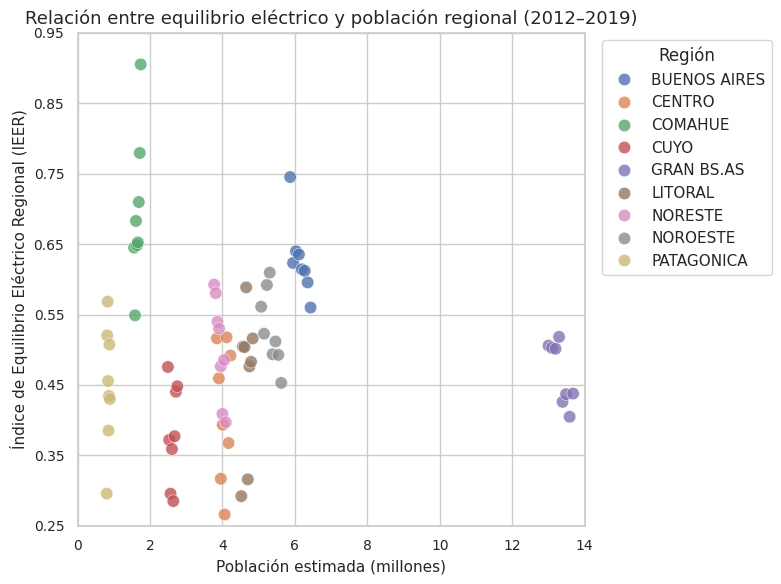

In [ ]:

dfp = df_ieer_pob.copy()
dfp["poblacion_millones"] = dfp["poblacion_estimada"] / 1e6

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=dfp,
    x="poblacion_millones",
    y="IEER",
    hue="region",
    s=80,
    alpha=0.8,
    edgecolor="white",
    linewidth=0.4
)

# Texto más prolijo
ax.set_title("Relación entre equilibrio eléctrico y población regional (2012–2019)", fontsize=13)
ax.set_xlabel("Población estimada (millones)", fontsize=11)
ax.set_ylabel("Índice de Equilibrio Eléctrico Regional (IEER)", fontsize=11)

# “Agrandar la escala” (más rango visible + ticks más claros)
ax.set_ylim(0.25, 0.95)
ax.set_yticks(np.arange(0.25, 0.96, 0.10))

ax.set_xlim(0, 14)
ax.set_xticks(np.arange(0, 15, 2))

ax.tick_params(axis="both", labelsize=10)

ax.legend(title="Región", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig("grafico_20_ieer_vs_poblacion.png", dpi=300, bbox_inches="tight")
plt.savefig("grafico_20_ieer_vs_poblacion.pdf", bbox_inches="tight")
plt.show()

In [ ]:
df_ieer_pob = df_ieer_pob.merge(df_cluster[["region","anio","cluster"]], on=["region","anio"], how="left")

In [ ]:
df_ieer_1219 = df_ieer_pob[df_ieer_pob["anio"].between(ANIO_INICIO, ANIO_FIN)].copy()

df_prom = (
    df_ieer_1219
    .groupby("region", as_index=False)
    .agg(
        IEER_promedio=("IEER", "mean"),
        poblacion_promedio=("poblacion_estimada", "mean")
    )
)

display(df_prom.sort_values("poblacion_promedio", ascending=False))

region  IEER_promedio  poblacion_promedio
4    GRAN BS.AS          0.467      13,340,430.125
0  BUENOS AIRES          0.628       6,151,269.375
7      NOROESTE          0.529       5,345,775.875
5       LITORAL          0.460       4,678,010.375
1        CENTRO          0.416       4,035,338.875
6       NORESTE          0.501       3,931,227.125
3          CUYO          0.382       2,624,588.125
2       COMAHUE          0.696       1,653,044.125
8    PATAGONICA          0.450         850,343.875

### 6.5 EDA (visualización población - IEER)

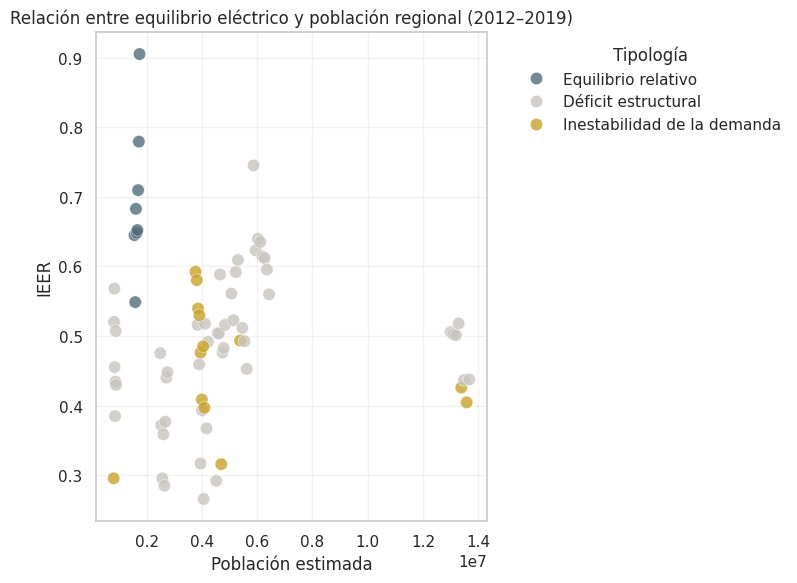

In [ ]:
# Tipologías (igual que mapas)
labels_cluster = {
    1: "Equilibrio relativo",
    2: "Déficit estructural",
    0: "Inestabilidad de la demanda"
}

# Colores consistentes (mapas / tipologías)
orden, colores, cmap_tipologias, handles = configurar_tipologias()
color_map = colores if isinstance(colores, dict) else {orden[i]: colores[i] for i in range(len(orden))}

dfp = df_ieer_pob.copy()

# Si tenés cluster, convertimos a tipología con orden fijo
if "cluster" in dfp.columns:
    dfp["tipologia"] = dfp["cluster"].map(labels_cluster)
    dfp["tipologia"] = (
        dfp["tipologia"].astype("category")
        .cat.set_categories(orden, ordered=True)
    )

plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=dfp,
    x="poblacion_estimada",
    y="IEER",
    hue="tipologia" if "cluster" in dfp.columns else "region",
    palette=color_map if "cluster" in dfp.columns else None,
    s=80,
    alpha=0.8,
    edgecolor="white",
    linewidth=0.4
)

plt.xlabel("Población estimada")
plt.ylabel("IEER")
plt.title("Relación entre equilibrio eléctrico y población regional (2012–2019)")

plt.legend(
    title="Tipología" if "cluster" in dfp.columns else "Región",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False
)

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

Se construyó una tabla de correspondencia entre jurisdicciones provinciales y regiones energéticas, permitiendo integrar información demográfica al análisis eléctrico regional.

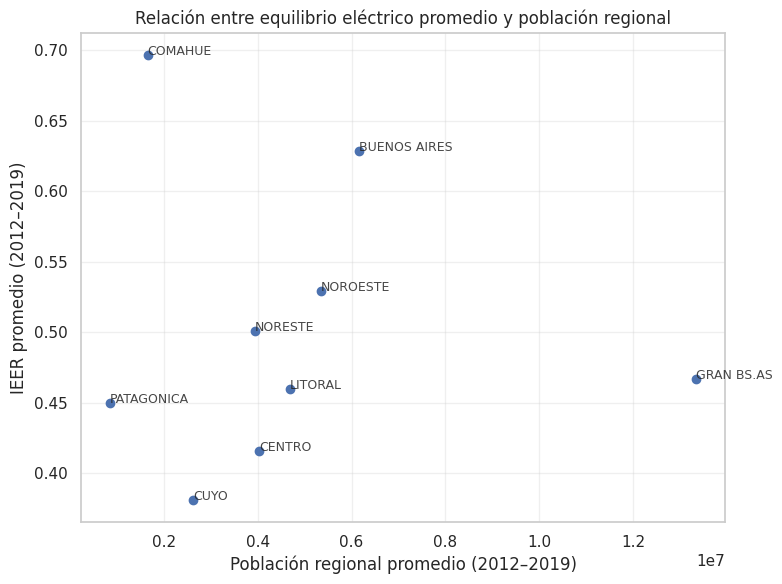

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_prom['poblacion_promedio'], df_prom['IEER_promedio'])

for _, r in df_prom.iterrows():
    plt.text(r['poblacion_promedio'], r['IEER_promedio'], r['region'],
             fontsize=9, alpha=0.85)

plt.xlabel('Población regional promedio (2012–2019)')
plt.ylabel('IEER promedio (2012–2019)')
plt.title('Relación entre equilibrio eléctrico promedio y población regional')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

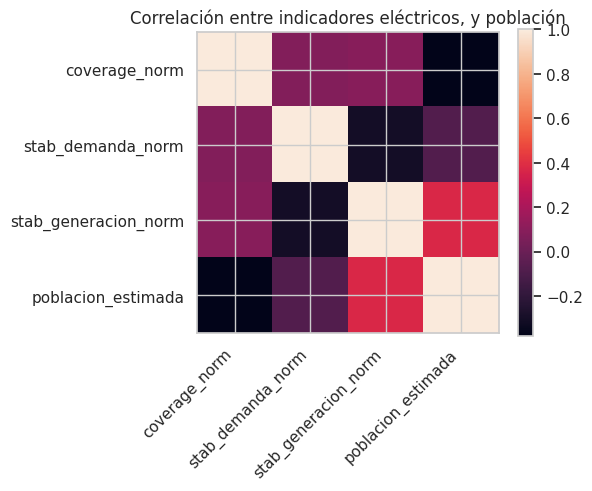

In [ ]:
# Elegí el df que estés usando (df_ieer_pob o df_ieer)
df_base = df_ieer_pob.copy()  # si usás df_ieer, cambiá acá

vars_corr = [
    "coverage_norm",
    "stab_demanda_norm",
    "stab_generacion_norm",
    "poblacion_estimada"   # sacala si no querés población en la matriz
]

corr = df_base[vars_corr].corr(numeric_only=True)

plt.figure(figsize=(6, 5))
plt.imshow(corr.values, interpolation="nearest")
plt.xticks(range(len(vars_corr)), vars_corr, rotation=45, ha="right")
plt.yticks(range(len(vars_corr)), vars_corr)
plt.title("Correlación entre indicadores eléctricos, y población")
plt.colorbar()
plt.tight_layout()

# Guardar para el anexo (opcional)
plt.savefig("Anexo_E3_correlacion.png", dpi=300, bbox_inches="tight")
plt.savefig("Anexo_E3_correlacion.pdf", bbox_inches="tight")

plt.show()


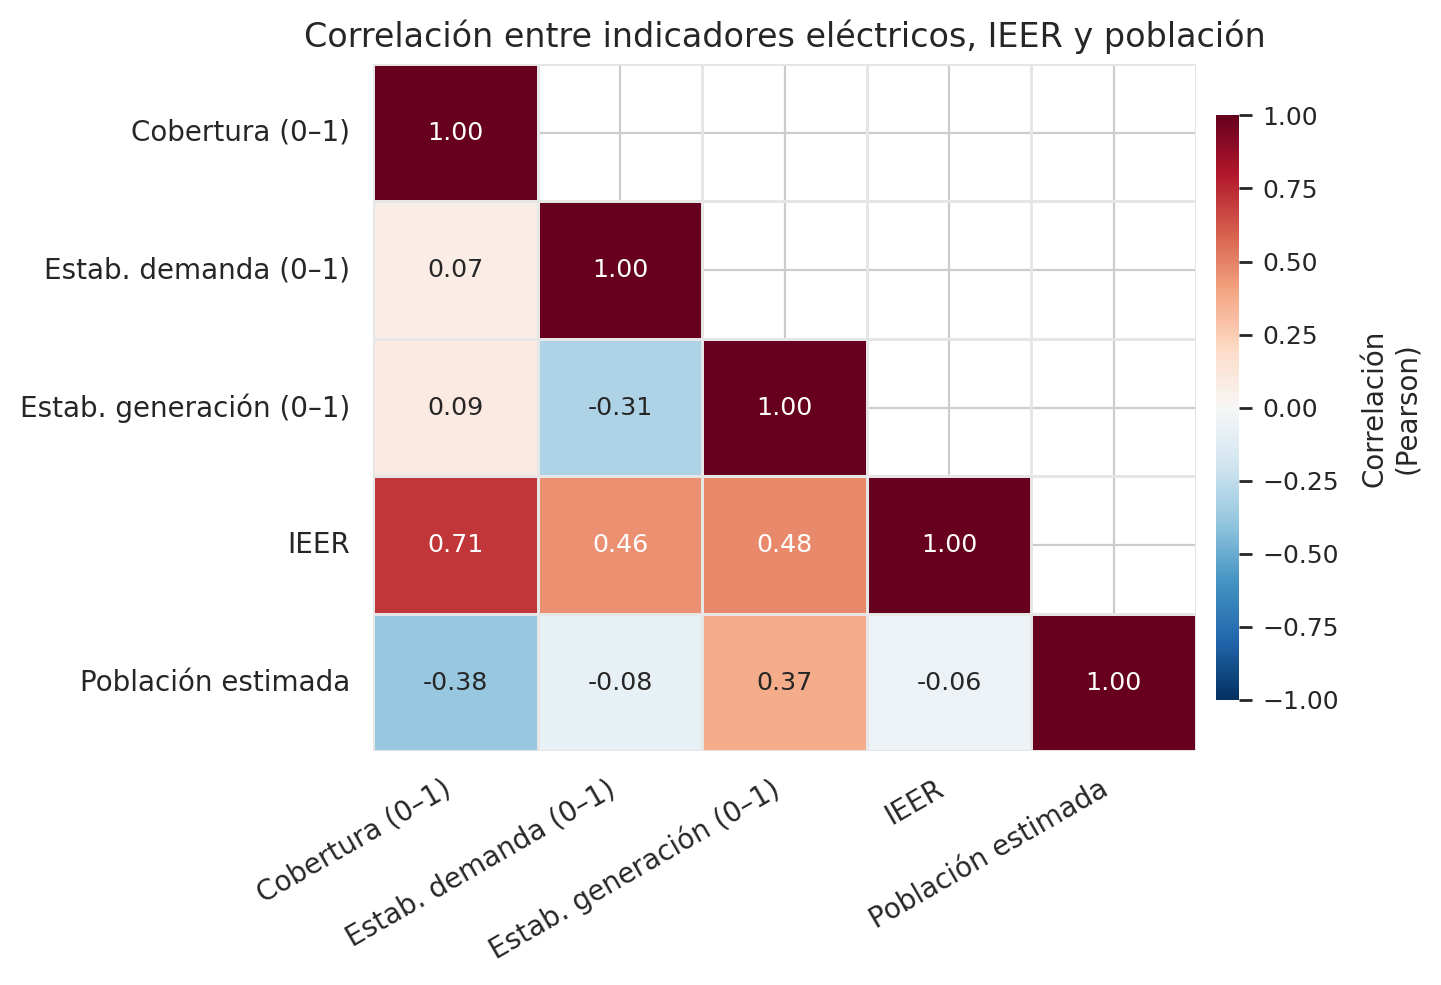

In [ ]:
# 1) Armar correlación (ajustá df_ieer_pob si tu DF se llama distinto)
cols = ["coverage_norm", "stab_demanda_norm", "stab_generacion_norm", "IEER", "poblacion_estimada"]

rename_map = {
    "coverage_norm": "Cobertura (0–1)",
    "stab_demanda_norm": "Estab. demanda (0–1)",
    "stab_generacion_norm": "Estab. generación (0–1)",
    "IEER": "IEER",
    "poblacion_estimada": "Población estimada"
}

corr = df_ieer_pob[cols].rename(columns=rename_map).corr(numeric_only=True)

# 2) Máscara: oculta triángulo superior (dejando diagonal y triángulo inferior)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# 3) Contexto "paper"
sns.set_context("paper", font_scale=0.95)

fig, ax = plt.subplots(figsize=(7.2, 5.0), dpi=200)

hm = sns.heatmap(
    corr,
    mask=mask,
    cmap="RdBu_r",
    vmin=-1, vmax=1, center=0,
    annot=True, fmt=".2f",
    linewidths=0.5, linecolor="#E6E6E6",
    cbar_kws={"shrink": 0.85, "pad": 0.02, "aspect": 25},
    ax=ax
)

ax.set_title("Correlación entre indicadores eléctricos, IEER y población", fontsize=12)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)

cbar = hm.collections[0].colorbar
cbar.set_label("Correlación\n(Pearson)", fontsize=10, labelpad=8)
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig("correlacion_ieer_poblacion.png", dpi=300, bbox_inches="tight")
plt.savefig("correlacion_ieer_poblacion.pdf", bbox_inches="tight")
plt.show()


In [ ]:
tabla_45c = (
    df_prom
    .sort_values('poblacion_promedio', ascending=False)
    .rename(columns={
        'region': 'Región',
        'poblacion_promedio': 'Población promedio (2012–2019)',
        'IEER_promedio': 'IEER promedio (2012–2019)',
        'cluster_dominante': 'Clúster dominante'
    })
)

tabla_45c

Región  IEER promedio (2012–2019)  Población promedio (2012–2019)
4    GRAN BS.AS                      0.467                  13,340,430.125
0  BUENOS AIRES                      0.628                   6,151,269.375
7      NOROESTE                      0.529                   5,345,775.875
5       LITORAL                      0.460                   4,678,010.375
1        CENTRO                      0.416                   4,035,338.875
6       NORESTE                      0.501                   3,931,227.125
3          CUYO                      0.382                   2,624,588.125
2       COMAHUE                      0.696                   1,653,044.125
8    PATAGONICA                      0.450                     850,343.875

In [ ]:
df_full = df_cluster.merge(
    df_pob_reg_anual,
    on=["region", "anio"],
    how="left"
)

df_full.head()
#df_full.isna().sum()


region  anio  coverage_norm  stab_demanda_norm  stab_generacion_norm  \
0  BUENOS AIRES  2012          0.270              1.000                 0.966   
1  BUENOS AIRES  2013          0.181              0.948                 0.740   
2  BUENOS AIRES  2014          0.177              0.916                 0.826   
3  BUENOS AIRES  2015          0.201              0.972                 0.733   
4  BUENOS AIRES  2016          0.288              0.733                 0.822   

   cluster  poblacion_estimada  
0        2             5869424  
1        2             5949951  
2        2             6030478  
3        2             6111006  
4        2             6191533

In [ ]:
# Filtrar período por consistencia
df_full_1219 = df_full[df_full['anio'].between(2012, 2019)].copy()

cluster_dom = (
    df_full_1219
    .groupby('region')['cluster']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name='cluster_dominante')
)

cluster_dom


region  cluster_dominante
0  BUENOS AIRES                  2
1        CENTRO                  2
2       COMAHUE                  1
3          CUYO                  2
4    GRAN BS.AS                  2
5       LITORAL                  2
6       NORESTE                  0
7      NOROESTE                  2
8    PATAGONICA                  2

In [ ]:
df_prom = df_prom.merge(cluster_dom, on='region', how='left')
df_prom

region  IEER_promedio  poblacion_promedio  cluster_dominante
0  BUENOS AIRES          0.628       6,151,269.375                  2
1        CENTRO          0.416       4,035,338.875                  2
2       COMAHUE          0.696       1,653,044.125                  1
3          CUYO          0.382       2,624,588.125                  2
4    GRAN BS.AS          0.467      13,340,430.125                  2
5       LITORAL          0.460       4,678,010.375                  2
6       NORESTE          0.501       3,931,227.125                  0
7      NOROESTE          0.529       5,345,775.875                  2
8    PATAGONICA          0.450         850,343.875                  2

Población vs desempeño eléctrico



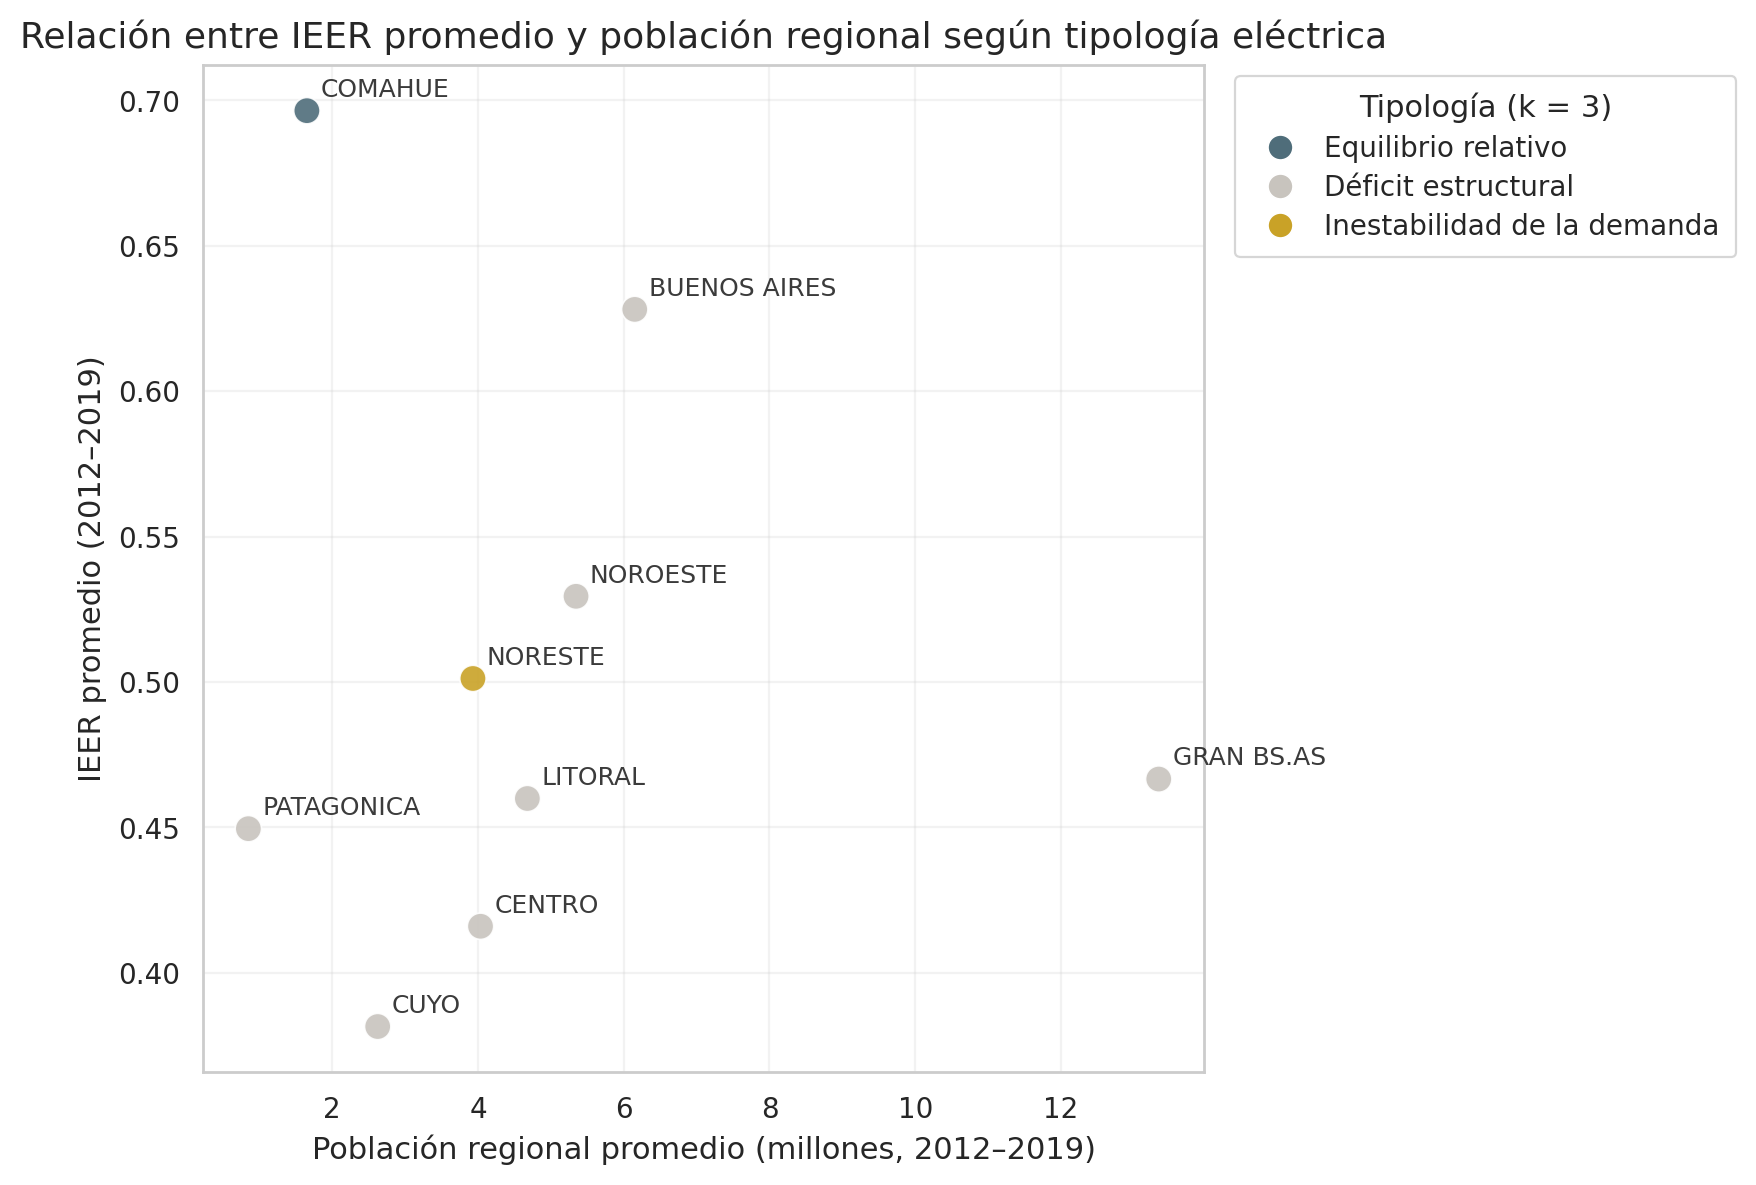

In [ ]:
# Paleta oficial
palette = {
    "Equilibrio relativo": "#4F6D7A",           # azul petróleo
    "Déficit estructural": "#C8C4BE",           # gris claro
    "Inestabilidad de la demanda": "#C9A227"    # mostaza
}

# Mapeo cluster
cluster_to_tip = {
    0: "Inestabilidad de la demanda",
    1: "Equilibrio relativo",
    2: "Déficit estructural"
}

hue_order = ["Equilibrio relativo", "Déficit estructural", "Inestabilidad de la demanda"]

# ---- Datos para plot ----
dfp = df_prom.copy()
dfp["tipologia"] = dfp["cluster_dominante"].map(cluster_to_tip)
dfp["pob_mill"] = dfp["poblacion_promedio"] / 1e6
dfp["color"] = dfp["tipologia"].map(palette)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8.6, 6), dpi=200)

ax.scatter(
    dfp["pob_mill"],
    dfp["IEER_promedio"],
    s=90,
    c=dfp["color"],
    alpha=0.90,
    edgecolors="white",
    linewidth=0.6
)

# Etiquetas de regiones
for _, r in dfp.iterrows():
    ax.annotate(
        r["region"],
        (r["pob_mill"], r["IEER_promedio"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha="left",
        fontsize=9,
        alpha=0.90
    )

ax.set_xlabel("Población regional promedio (millones, 2012–2019)", fontsize=11)
ax.set_ylabel("IEER promedio (2012–2019)", fontsize=11)
ax.set_title("Relación entre IEER promedio y población regional según tipología eléctrica", fontsize=13)

ax.grid(True, alpha=0.25)
ax.tick_params(axis="both", labelsize=10)

# Leyenda discreta (en vez de colorbar)
handles = [
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor=palette[t], markeredgecolor="white",
           markeredgewidth=0.6, markersize=9, label=t)
    for t in hue_order
]
ax.legend(
    handles=handles,
    title="Tipología (k = 3)",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=True,
    fontsize=10,        # ↓ texto más chico
    title_fontsize=11,  # ↓ título más chico
    borderpad=0.6,      # ↓ padding interno del cuadro
    labelspacing=0.4,   # ↓ espacio entre ítems
    handletextpad=0.6,  # ↓ espacio símbolo-texto
    borderaxespad=0.4   # ↓ separación del gráfico
)

plt.tight_layout()
plt.savefig("grafico_ieer_poblacion_tipologia.png", dpi=300, bbox_inches="tight")
plt.savefig("grafico_ieer_poblacion_tipologia.pdf", bbox_inches="tight")
plt.show()

## 7.Síntesis territorial del IEER

Se presenta el mapa del IEER promedio (2012–2019) a nivel de regiones energéticas, construido a partir de las geometrías regionales previamente definidas. La región Gran Buenos Aires no se representa cartográficamente por no contar con delimitación territorial oficial compatible con la regionalización energética utilizada; no obstante, su valor promedio se informa explícitamente en la figura.

La visualización permite identificar patrones espaciales del equilibrio eléctrico regional y sintetiza territorialmente los resultados obtenidos en los análisis previos.


🔍 Validando: IEER promedio por región (2012–2019)
📊 Filas: 9  |  Columnas: 5
➡️ Duplicados en ['region']: 0

✅ No se detectaron valores nulos.


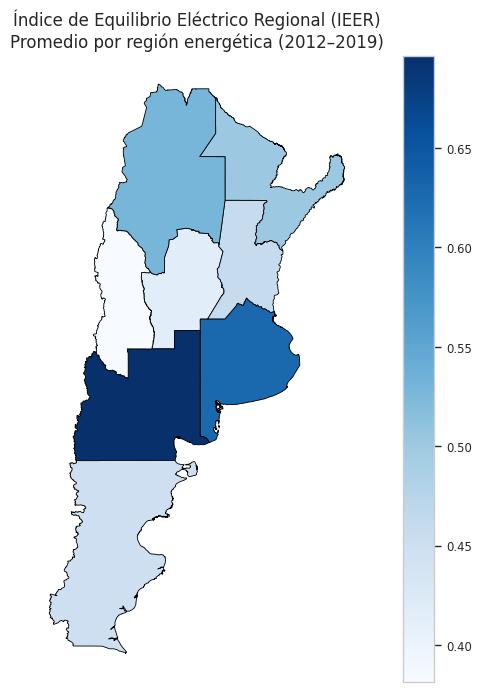

In [ ]:
# ============================================================
# Mapa IEER promedio 2012–2019 por región
# ============================================================

df_ieer_mapa = df_ieer_region.copy()

validar_dataset(
    df_ieer_mapa,
    "IEER promedio por región (2012–2019)",
    cols_clave=["region"]
)

# Excluir GBA del mapa (no tiene delimitación territorial oficial)
gdf_mapa_ieer = plot_mapa_regional(
    gdf_regiones=gdf_regiones,
    df_valores_region=df_ieer_mapa,
    col_value="IEER_promedio",
    titulo="Índice de Equilibrio Eléctrico Regional (IEER)\nPromedio por región energética (2012–2019)",
    cmap="Blues",
    excluir_regiones=REGIONES_SIN_GEOMETRIA
)


plt.show()


Nota: La región Gran Buenos Aires no se representa cartográficamente por no contar con delimitación territorial oficial compatible con la regionalización energética utilizada. Su IEER promedio para el período 2012–2019 es 0.467.

In [ ]:
#Distribución del IEER Promedio
df_ieer_mapa["IEER_promedio"].describe()


count   9.000
mean    0.503
std     0.101
min     0.382
25%     0.450
50%     0.467
75%     0.529
max     0.696
Name: IEER_promedio, dtype: float64